The notebook was implemented by Marouène Saidi, Artificial Intelligence Engineer.

# Federated Learning with BloodMNIST2D Dataset


Grab your favorite beverage ☕, put some lofi beats 🎙️ if you want to and lets start.

### Dependencies and Packages 🧰 
Let's get these out of the way first.

In [1]:
!python -m pip install -U pip
!python -m pip install tqdm torch torchvision medmnist imblearn
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

### Loading dependencies / Setting a seed for reproducibility

In [2]:
import numpy as np
from tqdm import tqdm
from pprint import pprint
from dataclasses import dataclass, field
import copy
import collections
from imblearn.under_sampling import RandomUnderSampler

import torch
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import label_binarize
import medmnist

import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, Subset

## Let's check the PyTorch and MedMNIST versions
print('PyTorch', torch.__version__)
print('MedMNIST', medmnist.__version__)

## Set a seed for reproducibility
np.random.seed(42) # Setting a fixed seed for numpy random number generator
torch.manual_seed(42)

PyTorch 2.3.0+cu121
MedMNIST 3.0.1


### Familiarize yourself with the Dataset 🧐

MedMNIST is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label) [1].

![Datasets in MedMNIST](https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/assets/medmnistv2.jpg)

Source: https://github.com/MedMNIST/MedMNIST

### Dataset Configuration ⚙️

In [3]:
# Load the BloodMNIST dataset
def load_data(DATASET_NAME: str, download: bool = False):
    """Load the BloodMNIST dataset."""

    info = medmnist.INFO[DATASET_NAME]
    DataClass = getattr(medmnist, info['python_class'])

    train_dataset = DataClass(split='train', download=download)
    test_dataset = DataClass(split='test', download=download)

    X_train, y_train = train_dataset.imgs, train_dataset.labels
    X_test, y_test = test_dataset.imgs, test_dataset.labels

    return (X_train, y_train), (X_test, y_test)


# Train/test options
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
DATASET_NAME = 'bloodmnist'
ds_info = medmnist.INFO[DATASET_NAME]
pprint(ds_info)

{'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c',
 'MD5_224': 'b718ff6835fcbdb22ba9eacccd7b2601',
 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b',
 'description': 'The BloodMNIST is based on a dataset of individual normal '
                'cells, captured from individuals without infection, '
                'hematologic or oncologic disease and free of any '
                'pharmacologic treatment at the moment of blood collection. It '
                'contains a total of 17,092 images and is organized into 8 '
                'classes. We split the source dataset with a ratio of 7:1:2 '
                'into training, validation and test set. The source images '
                'with resolution 3×360×363 pixels are center-cropped into '
                '3×200×200, and then resized into 3×28×28.',
 'label': {'0': 'basophil',
           '1': 'eosinophil',
           '2': 'erythroblast',
           '3': 'immature granulocytes(myelocytes, metamy

# Part 1. 💡 Federated Learning with independent and identically distributed (IID) label data distribution

In this section, our objectives are to:

1. **Set up the data and split it.**
2. **Initialize the federated and non-federated approaches.**
3. **Introduce the `FedAVG` aggregation and local update rule.**
4. **Build the training loop for federated learning.**

## I. Know your Dataset

Let's use some plotting tools here.

100%|██████████| 35461855/35461855 [00:02<00:00, 13003931.69it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


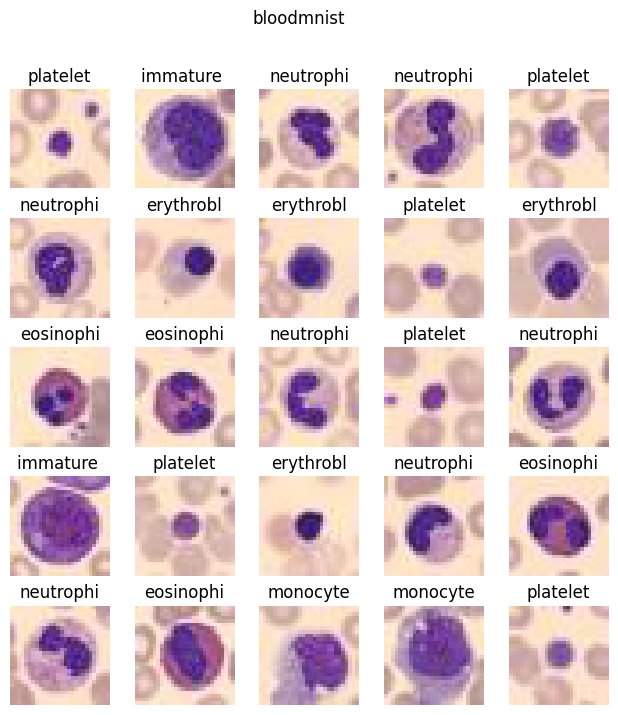

In [4]:

# Download raw numpy dataset
(x_train, y_train), (x_test, y_test) = load_data(DATASET_NAME, download=True)
# Visualize few samples
n_img = 5
train_samples = x_train[:n_img*n_img]

# Get the raw unique labels of the classes
label2str = list(ds_info['label'].values())

fig, ax = plt.subplots(n_img, n_img, figsize=(8, 8))

for k in range(len(train_samples)):
    i = k // n_img
    j = k % n_img
    img = train_samples[k]
    label = np.squeeze(y_train[k])
    ax[i, j].imshow(Image.fromarray(img))
    ax[i, j].title.set_text(label2str[label][:9])
    ax[i, j].axis('off')
plt.suptitle(DATASET_NAME)
fig.subplots_adjust(wspace=0.03, hspace=0.3)


### 1. Label Distribution Visualization of the original data split into train val

One key step before doing anything is to look at the labels distribution in the dataset.

In [5]:
# Function to visualize the distribution of labels using a bar plot
def plot_label_distribution(y, title="Label Distribution in BloodMNIST Dataset"):
    """
    Plot the label distribution.

    Parameters:
    - y: array-like, the labels of the dataset.
    - title: str, optional, the title of the plot (default is "Label Distribution in BloodMNIST Dataset").
    """

    # Get unique labels and their counts
    labels, counts = np.unique(y, return_counts=True)

    # Create a figure for the plot
    plt.figure(figsize=(10, 6))

    # Plot the label distribution as a bar plot
    plt.bar(labels, counts, tick_label=labels)

    # Set the x-axis label
    plt.xlabel('Label')

    # Set the y-axis label
    plt.ylabel('Count')

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()


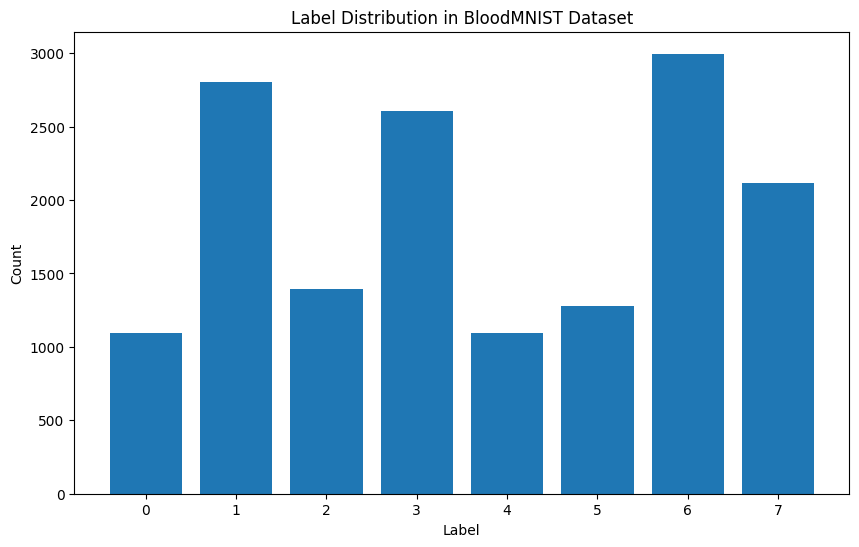

In [6]:
# Concatenate the training and testing feature sets
X_combined = np.concatenate((x_train, x_test), axis=0)

# Concatenate the training and testing label sets, and flatten the result
y_combined = np.concatenate((y_train, y_test), axis=0).flatten()

# Plot the distribution of the combined labels
plot_label_distribution(y_combined)

As you guys can see, the classes distribution are unbalanced. In order for the data to be IID, all the classes should have the same number of samples.

For this we will apply undersampling to reduce the number of samples in each class. In a nutshell, undersampling looks at the minority class and reduces the other classes to that level.

Before undersampling: Counter({6: 2996, 1: 2805, 3: 2605, 7: 2113, 2: 1396, 5: 1277, 0: 1096, 4: 1092})
After undersampling: Counter({0: 1092, 1: 1092, 2: 1092, 3: 1092, 4: 1092, 5: 1092, 6: 1092, 7: 1092})


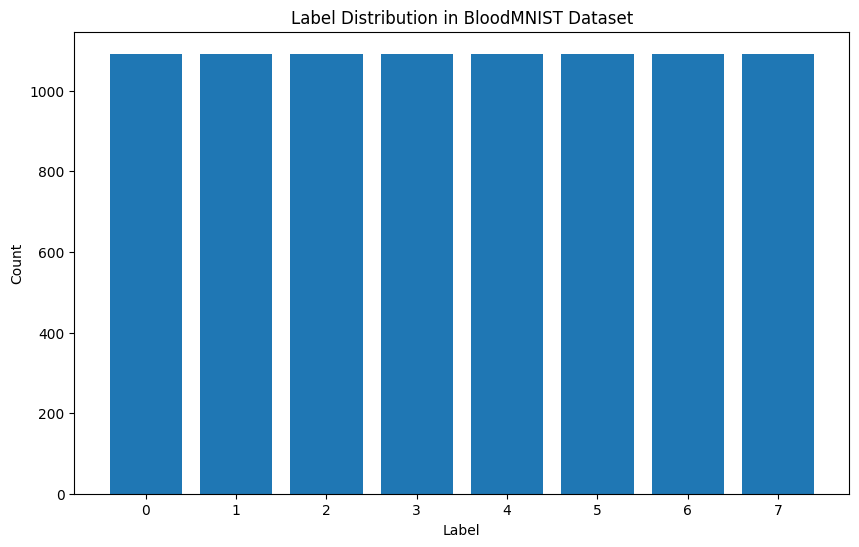

In [7]:
# Print the label distribution before undersampling
print(f"Before undersampling: {collections.Counter(y_combined)}")

# When undersampling or oversampling, the features need to be in a 2D array.
# We need to reshape our X_combined images from (n_samples, width, height, channels) to (n_samples, n_features)
# where n_features = width * height * channels
n_samples, width, height, channels = X_combined.shape

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)

# Calculate the number of features
n_features = width * height * channels

# Reshape X_combined and apply undersampling
X_combined_us, y_combined_us = undersampler.fit_resample(X_combined.reshape(n_samples, n_features), y_combined)

# After resampling, we reshape the images back to their original form (n_samples, width, height, channels)
# Note: since we don't know the new n_samples for X_combined_us, we can set it to -1 and keep the other dimensions as they were.
# This way, the numpy reshape function will estimate n_samples based on the other shape parameters.
X_combined_us = X_combined_us.reshape((-1, width, height, channels))

# Print the label distribution after undersampling
print(f"After undersampling: {collections.Counter(y_combined_us)}")

# Plot the label distribution after undersampling
plot_label_distribution(y_combined_us)


### 2. Define Dataset/Dataloader Classes

We'll create a simple PyTorch-style iterator dataset that returns single `numpy` elements as `torch.Tensor` objects. The class used for this will be `torch.utils.data.Dataset`.

We will then wrap this dataset object with a `DataLoader` class, which batches and shuffles the elements. The class used for this will be `torch.utils.data.DataLoader`.

But before that, we will use Stratified KFold to split our data (see *Federated Approach -> Prepare the dataset* section).
n).

In [8]:
# Create a PyTorch Dataset
class BloodMNISTDataset(Dataset):
    """
    This class is used to turn our dataset into a PyTorch-supported dataset.

    Parameters:
    - images: The images array from the MedMNIST dataset.
    - labels: The corresponding labels array for each image.
    - transform: Optional transformation to be applied to the images.
    """
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


class TransformDataset(Dataset):
    """
    Apply the transform to each element of the dataset.

    Parameters:
    - dataset: The dataset to be transformed.
    - transform: The transformation module containing the steps to apply to the data,
      such as converting to a tensor, normalization, feature augmentation, etc. Default is None.
    - target_transform: Transformation for the labels, used in cases where we have non-numerical
      or non-OneHotEncoded labels. Default is None.
    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.target_transform:
            label = self.target_transform(label)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)

        return img, label

# Since our data is composed of numpy arrays, we need to transform them to tensors to use them in PyTorch
transform = T.Compose([
    T.ToTensor(),
    # You can add more transformation tools here
])


In [9]:
# Example: Applying Stratified K-Fold Cross-Validation

# Define the number of splits for Stratified K-Fold
n_splits = 2

# Initialize the Stratified K-Fold with the specified number of splits, shuffle enabled, and a random state for reproducibility
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Split the combined undersampled dataset into stratified folds
splits = list(skf.split(X_combined_us, y_combined_us))

# Print the indices of the first fold as an example
train_idx, val_idx = splits[0]
print("Train indices of the first fold:", train_idx[:10])  # print first 10 indices for brevity
print("Validation indices of the first fold:", val_idx[:10])  # print first 10 indices for brevity

Train indices of first fold: [ 3  4  5  8  9 10 11 12 13 14]
Validation indices of first fold: [ 0  1  2  6  7 16 17 20 21 22]


### 3. T-SNE plot

T-SNE is a machine learning algorithm for dimensionality reduction that is particularly well-suited for the visualization of **high-dimensional** datasets. It reduces the dimensions of the data while **preserving** the relationships between the data points, making it easier to visualize complex datasets in 2 or 3 dimensions.

Mathematically, the t-SNE works in 3 main stages:

1. **Pairwise Affinities in High Dimension**:
For each pair of high-dimensional points $i$ and $j$, the similarity is measured using a [Gaussian distribution](https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use).



2. **Pairwise Affinities in Low Dimension**:
For each pair of low-dimensional points $y_{i}$ and $y_{j}$, the similarity is measured using a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with one degree of freedom (which is equivalent to the [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)).


3. **Minimizing the Kullback-Leibler (KL) Divergence**:
The cost function to minimize is the [KL divergence](https://towardsdatascience.com/understanding-kl-divergence-f3ddc8dff254) between the original distribution $P$ (in high-dimensional space) and the reduced distribution $Q$ (in low-dimensional space).


In [10]:
# Import the necessary libraries for t-SNE from sklearn
# and the libraries for displaying results

from sklearn.manifold import TSNE
from IPython.display import display, clear_output, HTML

In [11]:
label2str = list(ds_info['label'].values())

In [12]:

# Perform T-SNE
def perform_tsne(X):
    """
    Perform T-SNE dimensionality reduction on the input data.

    Parameters:
    X (numpy array): The input data.

    Returns:
    numpy array: The data transformed into 2D space using T-SNE.
    """
    # Initialize the TSNE model with specified parameters
    tsne = TSNE(n_components=2, random_state=42, verbose=True, n_iter=300, perplexity=30)

    # Reshape the data to be 2-dimensional if needed and fit_transform using TSNE
    X_tsne = tsne.fit_transform(X.reshape(X.shape[0], -1))

    return X_tsne

# Plotting function
def plot_tsne(X_tsne_train, X_tsne_test, y_train, y_test, show_train, show_test):
    """
    Plot the T-SNE transformed data for both training and test sets.

    Parameters:
    X_tsne_train (numpy array): T-SNE transformed training data.
    X_tsne_test (numpy array): T-SNE transformed test data.
    y_train (numpy array): Training labels.
    y_test (numpy array): Test labels.
    show_train (bool): Flag to indicate whether to plot training data.
    show_test (bool): Flag to indicate whether to plot test data.
    """
    plt.figure(figsize=(10, 6))

    # Combine training and test labels to find unique classes
    y_combined = np.concatenate((y_train, y_test))
    unique_classes = np.unique(y_combined)

    # Define a color map for plotting
    colors = {i: color for i, color in enumerate([
        '#f38181', '#95e1d3', '#fce38a', '#252a34',
        '#eaeaea', '#ff2e63', '#08d9d6', '#eaffd0'
    ])}

    # Plot training data if show_train is True
    if show_train:
        for i, class_value in enumerate(unique_classes):
            idx = y_train == class_value
            plt.scatter(X_tsne_train[idx, 0], X_tsne_train[idx, 1],
                        color=colors[i], label=f'{label2str[class_value]}', alpha=0.2)

    # Plot test data if show_test is True
    if show_test:
        for i, class_value in enumerate(unique_classes):
            idx = y_test == class_value
            plt.scatter(X_tsne_test[idx, 0], X_tsne_test[idx, 1],
                        color=colors[i], label=f'{label2str[class_value]}', alpha=0.2)

    # Add legend, title, and axis labels to the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title('T-SNE of BloodMNIST Dataset')
    plt.xlabel('T-SNE Component 1')
    plt.ylabel('T-SNE Component 2')
    plt.show()


In [13]:
## Apply the T-SNE
print("T-SNE for the train set and test set ...")
X_tsne  = perform_tsne(X_combined_us)

# Interactive widget
train_checkbox = widgets.Checkbox(value=True, description='Show Train Set')
test_checkbox = widgets.Checkbox(value=True, description='Show Test Set')

ui = widgets.HBox([train_checkbox, test_checkbox])

# Output widget for the plot
output = widgets.Output()

def update_plot(change):
    with output:
        clear_output(wait=True)
        plot_tsne(X_tsne[train_idx], X_tsne[val_idx], y_combined_us[train_idx], y_combined_us[val_idx], train_checkbox.value, test_checkbox.value)

train_checkbox.observe(update_plot, 'value')
test_checkbox.observe(update_plot, 'value')

# Initial plot
with output:
    plot_tsne(X_tsne[train_idx], X_tsne[val_idx], y_combined_us[train_idx], y_combined_us[val_idx], train_checkbox.value, test_checkbox.value)

# Display widgets and plot
display(ui)
display(output)

T-SNE for the train set and test set ...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8736 samples in 0.044s...
[t-SNE] Computed neighbors for 8736 samples in 25.272s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8736
[t-SNE] Computed conditional probabilities for sample 2000 / 8736
[t-SNE] Computed conditional probabilities for sample 3000 / 8736
[t-SNE] Computed conditional probabilities for sample 4000 / 8736
[t-SNE] Computed conditional probabilities for sample 5000 / 8736
[t-SNE] Computed conditional probabilities for sample 6000 / 8736
[t-SNE] Computed conditional probabilities for sample 7000 / 8736
[t-SNE] Computed conditional probabilities for sample 8000 / 8736
[t-SNE] Computed conditional probabilities for sample 8736 / 8736
[t-SNE] Mean sigma: 392.248474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.788010
[t-SNE] KL divergence after 300 iterations: 3.348747


Output()

### 3. Intensity distribution

To measure and plot the intensity distribution of the images for each class we will use the **Kernel Density Estimate (KDE) Plot**.

It is a **non-parametric** way to estimate the probability density function of a continuous random variable. It smooths the sample data using a [Gaussian kernel](https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use) function, which can be thought of as a smooth, continuous curve drawn over the data points to show the distribution of the data.

Given a set of data points $\{x_{1}, x_{2}, ..., x_{n}\}$, the KDE is defined as:

$$\hat{f}(x) = \frac{1}{nh} \sum^{n}_{i=1}{K(\frac{x-x_{i}}{h})}$$

where:

* $\hat{f}(x)$ is the estimated density function.
* $n$ is the number of data points.
* $h$ is the bandwidth (a smoothing parameter).
* $K$ is the kernel function, which is often a Gaussian (normal) function: $K(u) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{u^2}{2}}$.

In [14]:
# Plotting function for KDE
def plot_kde(X_train, X_test, y_train, y_test, show_train, show_test, show_labels):


  plt.figure(figsize=(10, 6))
  plt.grid()
  if show_train:
    if show_labels != [0,0,0,0,0,0,0,0]:
      for k in np.where(np.array(show_labels) == 1)[0]:
        print("Processing Train Label:", k)
        sns.kdeplot(X_train[y_train == k].flatten(), label=f'Train Label {label2str[k]}', fill=False, alpha=0.5)

  if show_test:
    if show_labels != [0,0,0,0,0,0,0,0]:
      for k in np.where(np.array(show_labels) == 1)[0]:
        print("Processing Test Label:", k)
        sns.kdeplot(X_test[y_test == k].flatten(), label=f'Test Label {label2str[k]}', fill=False, alpha=0.5)

  plt.legend()
  plt.title('KDE of BloodMNIST Dataset')
  plt.xlabel('Intensity')
  plt.show()


In [15]:
# Interactive widget
train_checkbox = widgets.Checkbox(value=True, description='Show Train Set')
test_checkbox = widgets.Checkbox(value=True, description='Show Test Set')
labels_checkboxs = [widgets.Checkbox(value=False, description=label) for i,label in enumerate(label2str)]

# Widgets for each label

trainTest_box = widgets.HBox([train_checkbox, test_checkbox])
labels_box = widgets.HBox(labels_checkboxs)

box_splits = widgets.VBox([widgets.Label("Data splits"), trainTest_box])
box_labels = widgets.VBox([widgets.Label("Labels"), labels_box])

ui = widgets.VBox([box_splits, box_labels])

# Output widget for the plot
output = widgets.Output()

def update_plot(change):
    with output:
        clear_output(wait=True)
        plot_kde(X_combined_us[train_idx], X_combined_us[val_idx], y_combined_us[train_idx], y_combined_us[val_idx], train_checkbox.value, test_checkbox.value, [int(label_chk.value) for label_chk in labels_checkboxs])
        # checker(train_checkbox.value, test_checkbox.value, [int(label_chk.value) for label_chk in labels_checkboxs])

train_checkbox.observe(update_plot, 'value')
test_checkbox.observe(update_plot, 'value')
for box in labels_checkboxs:
    box.observe(update_plot, 'value')

# Initial plot
with output:
    plot_kde(X_combined_us[train_idx], X_combined_us[val_idx], y_combined_us[train_idx], y_combined_us[val_idx], train_checkbox.value, test_checkbox.value, [int(label_chk.value) for label_chk in labels_checkboxs])
    # checker(train_checkbox.value, test_checkbox.value, [int(label_chk.value) for label_chk in labels_checkboxs])


# Display widgets and plot
display(ui)
display(output)

Output()

Selecting by labels in our plots and looking at the interaction between the training and testing sets in regards to the label can be very helpful.

In [16]:
# Plotting function
def plot_tsne_by_label(X_tsne_train, X_tsne_test, y_train, y_test, show_train, show_test, show_labels):
    plt.figure(figsize=(10, 6))
    if show_train:
      if show_labels != [0,0,0,0,0,0,0,0]:
        for k in np.where(np.array(show_labels) == 1)[0]:
          print("Processing Train Label:", k)
          plt.scatter(X_tsne_train[np.where(y_train == k)[0], 0], X_tsne_train[np.where(y_train == k)[0], 1], c="blue", label=f'{label2str[k]}', cmap='tab10', alpha=0.2)
    if show_test:
      if show_labels != [0,0,0,0,0,0,0,0]:
        for k in np.where(np.array(show_labels) == 1)[0]:
          print("Processing Train Label:", k)
          plt.scatter(X_tsne_test[np.where(y_test == k)[0], 0], X_tsne_test[np.where(y_test == k)[0], 1], c="red", label=f'{label2str[k]}', cmap='tab10', alpha=0.2)

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title('T-SNE of BloodMNIST Dataset')
    plt.xlabel('T-SNE Component 1')
    plt.ylabel('T-SNE Component 2')
    plt.show()

In [17]:
# Interactive widget
train_checkbox = widgets.Checkbox(value=True, description='Show Train Set')
test_checkbox = widgets.Checkbox(value=True, description='Show Test Set')
labels_checkboxs = [widgets.Checkbox(value=False, description=label) for i,label in enumerate(label2str)]

# Widgets for each label

trainTest_box = widgets.HBox([train_checkbox, test_checkbox])
labels_box = widgets.HBox(labels_checkboxs)

box_splits = widgets.VBox([widgets.Label("Data splits"), trainTest_box])
box_labels = widgets.VBox([widgets.Label("Labels"), labels_box])

ui = widgets.VBox([box_splits, box_labels])

# Output widget for the plot
output = widgets.Output()

def update_plot(change):
    with output:
        clear_output(wait=True)
        plot_tsne_by_label(X_tsne[train_idx], X_tsne[val_idx], y_combined_us[train_idx], y_combined_us[val_idx], train_checkbox.value, test_checkbox.value, [int(label_chk.value) for label_chk in labels_checkboxs])

train_checkbox.observe(update_plot, 'value')
test_checkbox.observe(update_plot, 'value')
for box in labels_checkboxs:
    box.observe(update_plot, 'value')

# Initial plot
with output:
    plot_tsne_by_label(X_tsne[train_idx], X_tsne[val_idx], y_combined_us[train_idx], y_combined_us[val_idx], train_checkbox.value, test_checkbox.value, [int(label_chk.value) for label_chk in labels_checkboxs])

# Display widgets and plot
display(ui)
display(output)

Output()

## II. Base Deep Learning Model

In this section we will:
* Define a CNN model for image classification we will can `Net`.

### 1. Building the model

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """
    The CNN architecture for image classification.

    Parameters:
    - in_channels: The number of channels in an image.
    - num_classes: The number of classes we expect to predict.
    """

    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        # Layer 1: Convolutional layer
        # Input shape: (batch_size, in_channels, height, width)
        # Output shape: (batch_size, 16, height - 2, width - 2) assuming no padding
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        # Layer 2: Convolutional layer followed by max pooling
        # Input shape: (batch_size, 16, height - 2, width - 2)
        # Output shape: (batch_size, 16, (height - 2) // 2, (width - 2) // 2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        """
        Forward pass of the CNN model.

        Parameters:
        - x: The input batch of shape (batch_size, in_channels, height, width).

        Returns:
        - x: The output feature tensor of shape (batch_size, num_classes).
        """

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x


In [19]:
# Example

# Create a centralized_model using the Net module defined earlier.
# This model is initialized with parameters based on dataset information.
centralized_model = Net(in_channels=ds_info['n_channels'],
                        num_classes=len(ds_info['label']))

# Print the summary of the centralized_model.
print(centralized_model)

# Calculate and print the total number of parameters in the model.
print('Total Parameters:', sum([torch.numel(p) for p in centralized_model.parameters()]))

# Calculate and print the number of trainable parameters in the model.
print('Trainable Parameters:', sum([torch.numel(p) for p in centralized_model.parameters() if p.requires_grad]))


Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

## III. Federated vs non-federated approaches

### 1. Prepare the dataset

We will first split the data into <kbd>global sets</kbd>. Each set is for a specific client and the last set is for the global testing. Then we split each client global set into tiny local set where *80%* is for training and *20%* is for testing.

To ensure that each local set maintains the same proportion of each class as the global set thus why we will use **Stratified K-Fold**.

**Stratified K-Fold** Cross-Validation is a variation of **K-Fold** Cross-Validation that ensures that each fold (subsample) of the dataset maintains the **same proportion** of each class as the original dataset. This is particularly useful in classification problems where class **imbalance** can lead to biased results.

In standard K-Fold Cross-Validation, the data is randomly split into $k$ qually sized folds. In each iteration, one fold is used for testing, and the remaining $k-1$ folds are used for training. This process is repeated $k$ times, with each fold used exactly once as the test set. However, if the data is imbalanced (i.e., some classes are underrepresented), this random split might result in some folds not representing the minority class well, leading to misleading performance metrics.

[Stratified K-Fold Cross-Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) addresses this by splitting the data in such a way that each fold has the same proportion of samples from each class as the original dataset.

Below we represent in the [figure](https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation) how stratified K-Fold maintains the same proportions of samples from each class as the original dataset.

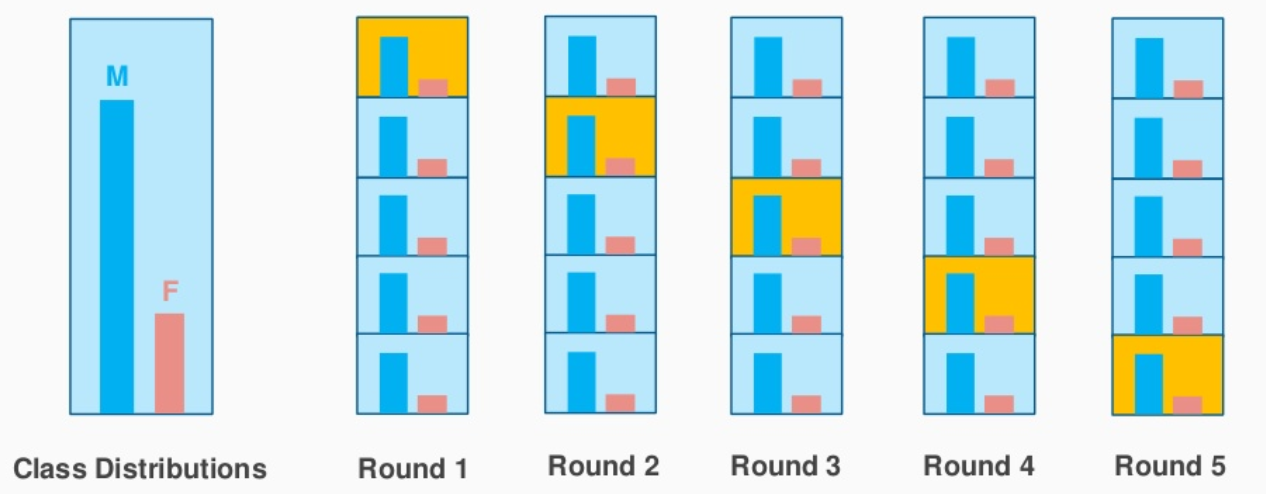



In [20]:
# Apply Stratified K-Fold to create the local client datasets + global testing datasets
# We are fetching the data that we engineered using undersampling to ensure the IID scenario
# wich is X_combined_us for the images and y_combined_us for the labels

# Setup the number of clients in n_clients
n_clients = 4

# The n_localSplits is the n_clients + 1 for the global testing datasets
n_localSplits = n_clients + 1
local_skf = StratifiedKFold(n_splits=n_localSplits, shuffle=True, random_state=42)
local_splits = list(local_skf.split(X_combined_us, y_combined_us))

In [21]:
#  Get train and test indicies ratios for each client local set
for i in range(len(local_splits)-1):
    #  Get train ans test indicies for each client
    train_idx, val_idx = local_splits[i]
    print(f"Client {i+1} has {np.round((len(train_idx)/len(y_combined_us[train_idx.tolist()+val_idx.tolist()])),2)} train and {np.round((len(val_idx)/len(y_combined_us[train_idx.tolist()+val_idx.tolist()])),2)} test.")


Client 1 has 0.8 train and 0.2 test.
Client 2 has 0.8 train and 0.2 test.
Client 3 has 0.8 train and 0.2 test.
Client 4 has 0.8 train and 0.2 test.


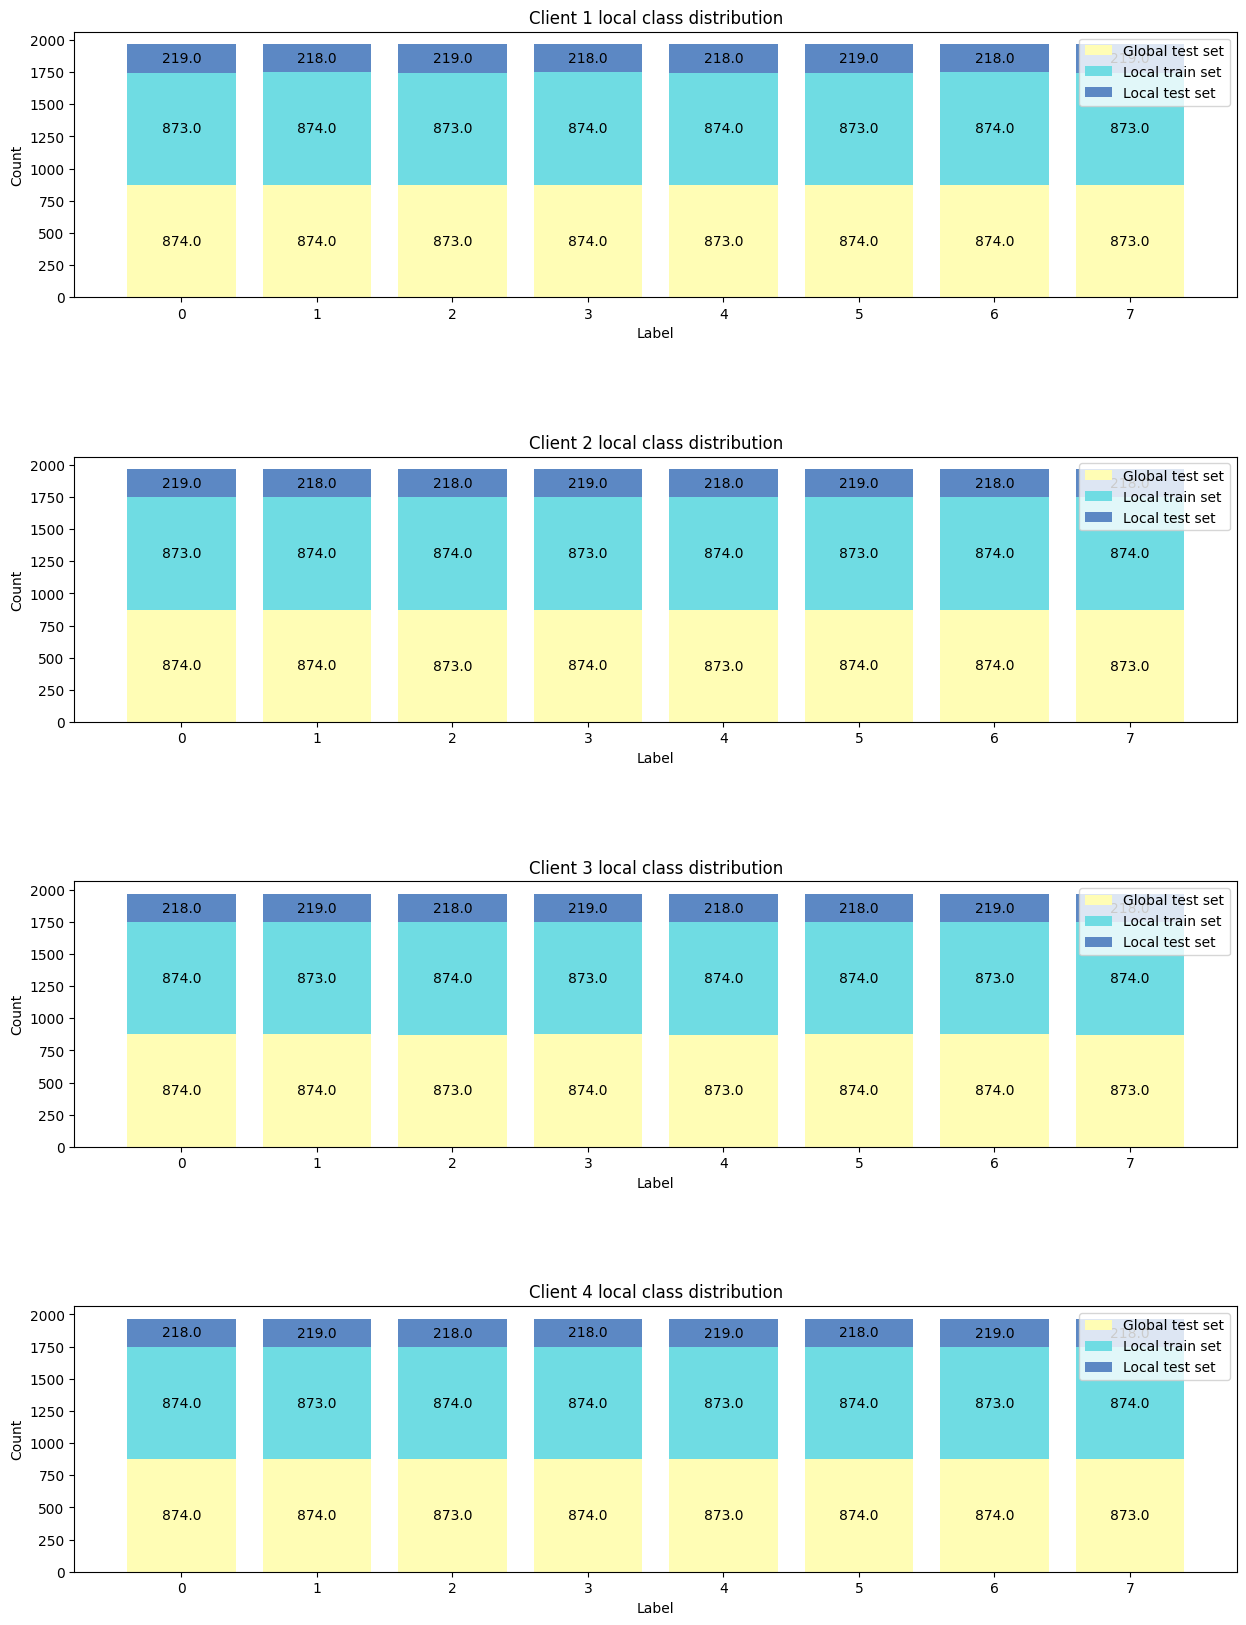

In [22]:
# Check the distribution of labels for each client local set
fig, ax = plt.subplots(n_clients, figsize=(15, 20))

# Check the distribution of labels for each client's local fold
for i in range(n_clients):
    train_idx, val_idx = local_splits[i]
    labels, counts_train = np.unique(y_combined_us[train_idx], return_counts=True)
    labels, counts_test = np.unique(y_combined_us[val_idx], return_counts=True)

    # Get the global test set ( it is the last one in the splits list )
    global_test = y_combined_us[local_splits[-1][0]]
    labels, counts_global_test = np.unique(global_test, return_counts=True)

    ax[i].bar(labels, counts_global_test, color='#fffdb5', tick_label=labels, label='Global test set')
    ax[i].bar(labels, counts_train, color='#6fdce3', tick_label=labels, label='Local train set', bottom=counts_global_test)
    ax[i].bar(labels, counts_test, color='#5c88c4', tick_label=labels, label='Local test set', bottom=counts_global_test + counts_train)

    for xpos, ypos, yval in zip(labels, counts_global_test/2, counts_global_test):
      ax[i].text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip(labels, counts_global_test + counts_train/2, counts_train):
      ax[i].text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
    for xpos, ypos, yval in zip(labels, counts_global_test + counts_train + counts_test/2, counts_test):
      ax[i].text(xpos, ypos, "%.1f"%yval, ha="center", va="center")

    ax[i].set_xlabel('Label')
    ax[i].set_ylabel('Count')
    ax[i].set_title(f'Client {i+1} local class distribution')
    ax[i].legend(loc="upper right")




fig.subplots_adjust(hspace=0.6, wspace=0.6)
plt.legend(loc='upper right')
plt.show()

100%|██████████| 5/5 [06:01<00:00, 72.22s/it]


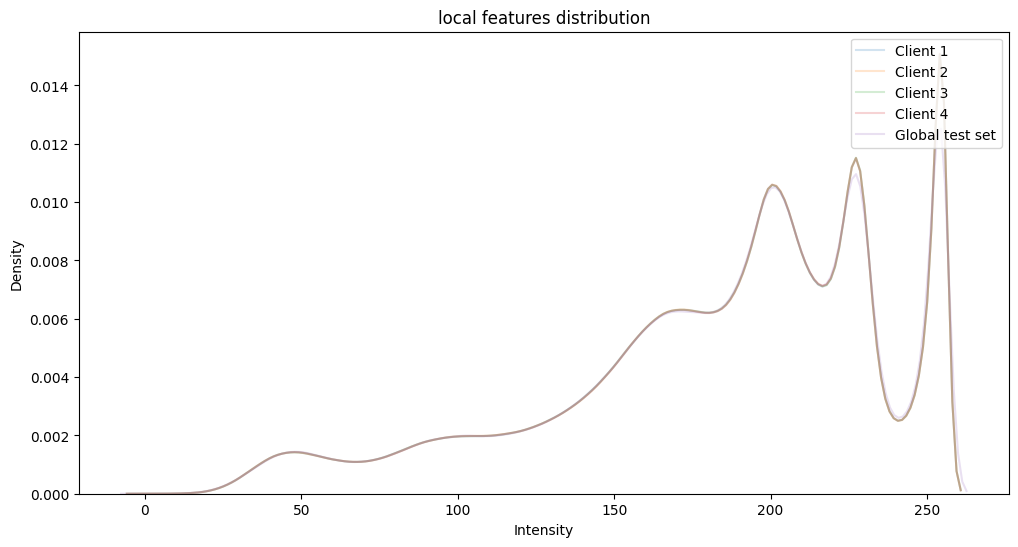

In [23]:
# Prepare the plot placeholder
# Note: We will use the X_combined_us images and the y_combined_us classes,
# which are the concatenated and then undersampled data from our dataset.
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate through local_splits to visualize distributions
for i in tqdm(range(len(local_splits))):
    train_idx, val_idx = local_splits[i]

    # Calculate class labels and counts for training data
    labels, counts = np.unique(y_combined_us[train_idx], return_counts=True)

    # Plot kernel density estimate (KDE) for each client or global test set
    if i < len(local_splits) - 1:
        sns.kdeplot(X_combined_us[train_idx].flatten(), label=f'Client {i+1}', fill=False, alpha=0.2)
    else:
        sns.kdeplot(X_combined_us[val_idx].flatten(), label=f'Global test set', fill=False, alpha=0.2)

    # Set x-axis label and plot title
    ax.set_xlabel('Intensity')
    ax.set_title('Local Features Distribution')

    # Add legend to the plot
    ax.legend(loc="upper right")

# Add legend to the overall plot
plt.legend(loc='upper right')

# Display the plot
plt.show()


Before getting into implementing the federated approach, we must accomplish some steps first:

* Build the client training and testing datasets (same as in the beginning).
* Wrap these datasets (local train and test sets + global test set) with a `DataLoader` class that batches and shuffles the elements. Class: `torch.utils.data.DataLoader`.
* Implement the **aggregation** function and the **update rule** for **FedAVG**.

**Note**: We will use the model architecture `Net(...)` that we built before.


In [24]:
torch.manual_seed(42)

# Convert it to a PyTorch Dataset
train_client_datasets = []
test_client_datasets = []

for i in range(len(local_splits) - 1):

    # Append to the clients' local train and test datasets
    train_client_datasets.append(TransformDataset(Subset(BloodMNISTDataset(X_combined_us, y_combined_us), local_splits[i][0]), transform=transform))
    test_client_datasets.append(TransformDataset(Subset(BloodMNISTDataset(X_combined_us, y_combined_us), local_splits[i][1]), transform=transform))

# Append the global test dataset
global_test_dataset = TransformDataset(Subset(BloodMNISTDataset(X_combined_us, y_combined_us), local_splits[-1][0]), transform=transform)

# Now we will build our dataloaders, which are modules that help us iterate over each batch of the data

# We set the batch size (you can change it and experiment with other values and look at the results)
BATCH_SIZE = 32

# We start by building a list of loaders for the local train sets for n_clients
train_client_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in train_client_datasets]

# Then we build another list of loaders for the local test sets for n_clients
test_client_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in test_client_datasets]

# And we finish with the global test set
global_test_loader = DataLoader(global_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


### 2. Define the Client and Server objects

In [25]:
class Client:
    """
     A class representing a client.

      Attributes:
      - device: The device on which the client's model and data will be loaded (CPU or CUDA).
      - model: The initial model assigned to the client.
      - optimizer: An optimizer for the model.
      - criterion: The loss function.
      - data: The dataloader assigned to the client.
      - id: A unique identifier for the client.
    """
    def __init__(self, initial_model, optimizer, learning_rate, criterion, dataloader, id):
      """
        Parameters:
        - initial_model: The intial model.
        - optimizer: An optimizer for the model.
        - learning_rate: The learning rate of the model.
        - criterion: The loss function.
        - dataloader: The train dataloader.
        - id: A unique identifier for the client.
      """

      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.model = copy.deepcopy(initial_model.to(self.device))
      self.optimizer = optimizer(self.model.parameters(), lr=learning_rate)
      self.criterion = criterion
      self.data = dataloader
      self.id = id

    def get_model_params(self):
      """
       Returns the state dictionary of the clients' model.

       Returns:
       - state_dict: The state dictionary of the clients' model.
      """

      return self.model.state_dict()

    def set_model_params(self, params):
      """
      Sets the state dictionary of the clients' model to the params

      Parameters:
      - params: The parameter to load into the client state_dict.
      """

      self.model.load_state_dict(params)


    def train_client(self, nbre_epochs):
      """
        This function handles the training of the client model. You just have to provide the number
        of epochs to run for and, after each epoch, it will return a dictionnary that containes
        the client id, the training accuracy, and the training loss.

        Parameters:
        - nbre_epochs: Number of epochs to run the training for.

        Returns:
        - dict: A dictionnairy that has the client id, the training accuracy, and the training loss

      """

      self.model.train() # set the model to train

      train_acc = []
      train_loss = []

      for epoch in range(nbre_epochs):
        losses = []
        correct = 0
        total = 0
        for inputs, targets in tqdm(self.data, desc="train"):

          self.optimizer.zero_grad()

          # Forward pass
          outputs = self.model(inputs.to(self.device))
          targets = targets.long().to(self.device)

          # PyTorch cross entropy loss automatically applies softmax
          # hence why we don't need to explicit it
          loss = self.criterion(outputs, targets)

          # Backward pass and optimization
          loss.backward()
          self.optimizer.step()

          losses.append(loss.item())
          total += targets.shape[0]
          correct += torch.sum(outputs.max(1)[1] == targets).item()

        # Calculate the accuracy after one epoch
        # and append it with the average of the losses the the train_acc list
        # and train_loss list.
        train_acc.append(np.round(correct / total, 8))
        train_loss.append(np.round(np.mean(losses), 8))

        print(f'[{self.id}] ==> Epoch {epoch}: train_acc: {np.round(correct / total, 8)}, train_loss: {np.round(np.mean(losses), 8)}')
      return {
            'client_id': self.id,
            'train_acc': train_acc,
            'train_loss': train_loss
        }

The **FedAvg** algorithm [3] is a cornerstone of federated learning, **balancing** model accuracy and communication efficiency. By leveraging *local data updates* and *secure aggregation*, FedAvg enables scalable, privacy-preserving machine learning across distributed devices.

The complete equation for updating the global model parameters in Federated Averaging is:

$$w^{t+1} = \dfrac{1}{n}\sum_{k=1}^{K} w_{k}^{t+1}$$

Each term represents:
* $w^{t+1}$: Updated global model parameters after round $t$.
* $n$: Total number of clients.
* $w_{k}^{t+1}$: Updated model parameters from client $k$ after local training.

After we performe **FedAVG** to compute the global model parameters, we braodcast it back to the clients and sum the global model parameters and the local model parameters then averaging them.

The complete equation for updating the local model parameters in Federated Averaging is:

$$w_{k}^{t+1} = \dfrac{w^{t+1}+w_{k}^{t+1}}{2}$$

Each term represents:
* $w^{t+1}$: Updated global model parameters after round $t$.
* $w_{k}^{t+1}$: Updated model parameters from client $k$ after local training.

In [26]:
# The aggregation and the update rule are both going to be implemented in the server class

class Server:
    """
    A class representing a central server.

    Attributes:
    - device: The device on which the server's global model will be loaded (CPU or CUDA).
    - global_model: The global model maintained by the server.
    - local_send_avg: Mimicking if we are sending the weights from server to client with averaging or without.
    """

    def __init__(self, initial_model, local_send_avg=True):
      """
      Parameters:
      - initial_model: the intial model.
      - local_send_avg: Mimicking if we are sending the weights from server to client with averaging or without.
      """
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.global_model = copy.deepcopy(initial_model.to(self.device))
      self.local_send_avg = local_send_avg



    # Federated Averaging
    def fed_avg(self, clients):
        """
        In this function we apply the aggregation and the we update the clients weights
        after we check if we will average the clients weights with the server weights or not.

        Parameters:
        - clients: A list of clients.
        """

        # Run the aggregation
        self.aggregate_avg(clients)

        if self.local_send_avg:

          # Update the clients
          print("Update clients with averaging")

          self.update_with_local_avg(clients)
        else:

          # Update the clients
          print("Update clients without averaging")
          self.update_without_local_avg(clients)


    def aggregate_avg(self, clients):
        """
        This function will first implement aggregate the weights from the clients and then average them.

        Parameters:
        - clients: A list of clients.
        """

        # Let's a copy of the state_dict of the global_model
        global_dict = self.global_model.state_dict()

        # We iterate for each layer in the model architecture
        for k in global_dict.keys():

            # Aggregate the clients weights of the selected layer. And the averaging using the 'mean' function in PyTorch
            # TODO: Implement the aggregation of the server model for every defined layer k.
            # Hint: use torch.stack to put the client_models state_dict weight on top of each other and then you can average by
            # the axis=0 using the built in function mean in troch.stack
            
            global_dict[k] = torch.stack([clients[i].get_model_params()[k] for i in range(len(clients))], 0).float().mean(0)

        # Update the global model weights
        self.global_model.load_state_dict(global_dict)

    def update_without_local_avg(self, clients):
      """
      This function updates the local clients weights by updating them with the server model weights.

      Parameters:
      - clients: A list of clients we will update their parameters weights.
      """

      # Let's copy the state_dict of the global_model
      server_dict = self.global_model.state_dict()

      # For each client in the client list
      for client in clients:

        # We update the client weights with the server weights
        client.set_model_params(server_dict)


    # Federated update client with local averaging
    def update_with_local_avg(self, clients):
      """
      This function updates the local clients weights by summing the current client weights
      with the server model weights and then averaging them.

      Parameters:
      - clients: A list of the clients we will update their models.
      """

      # Let's copy the state_dict of the global_model
      client_dict = self.global_model.state_dict()

      # For each client we have
      for client in clients:

        # For each layer in the model represented by a key 'k'
        for k in client_dict.keys():

          # We apply the averaging rule by summing the global_model weights
          # and the client_model weights for the 'k' layer and then average them
          # TODO: Implement the client update rule for each layer using the client_dict

          client_dict[k] = (self.global_model.state_dict()[k] + client.get_model_params()[k])/2

        ##We update the client weights
        client.set_model_params(client_dict)

To draw the losses easily of the local models, without going back and writing it again, we create the following <kbd>plot_train_metrics</kbd>

In [27]:
## Plot the client loss

def plot_train_loss(client_metrics, epochs, title="Loss plot"):
  """
  This function plots the losses from the client models along a certain number of epochs.

  Parameters:
  - client_metrics: A list of dictionnaries for each client that contain calculated metrics.
  - epochs: The number of epoch the model ran for. For federated models it's the number of epochs multiplied
    by the number of rounds.
  - title: The title of the plot. Default is 'Loss plot'.
  """

  fig, ax = plt.subplots(figsize=(24, 8))
  client_id = [i for i in range(1,n_clients+1)]

  for i in range(n_clients):
    ax.plot(list(range(1,epochs+1, 1)), client_metrics[i]['train_loss'], label=f'Client {client_id[i]} loss')
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.set_xlim(1,epochs)
    ax.set_xticks(list(range(1,epochs+1, 1)))
  ax.legend(loc="upper right")

  ax.set_title(f"Client {n_clients+1}")

  # Add titles for each row
  ax.set_title(title)

  # Add spacing between plots
  plt.show()


### 4. Non-Federated (local model trained with no Fed)

In [28]:
# Let's first initialize our initial_model.
torch.manual_seed(42) # Reminder: we will set a seed for reproducibility
initial_model = Net(in_channels=ds_info['n_channels'], num_classes=len(ds_info['label']))

In [29]:
# Initialize non-federated clients
LEARNING_RATE = 1e-4

clients_noFed = [
    Client(initial_model, torch.optim.Adam, LEARNING_RATE, nn.CrossEntropyLoss(), train_client_loaders[i], id=i) for i in range(n_clients)
    ]

In [30]:
# Local training for each client
client_metrics_noFed = []

# Set the hyperparameters for the epochs
NUM_EPOCHS = 20
# Train each client for "n" epochs
for client in clients_noFed:

  metrics = client.train_client(NUM_EPOCHS)
  client_metrics_noFed.append(metrics)

train: 100%|██████████| 219/219 [00:12<00:00, 17.03it/s]


[0] ==> Epoch 0: train_acc: 0.67344018, train_loss: 1.03871438


train: 100%|██████████| 219/219 [00:12<00:00, 17.49it/s]


[0] ==> Epoch 1: train_acc: 0.8371494, train_loss: 0.4711408


train: 100%|██████████| 219/219 [00:12<00:00, 17.63it/s]


[0] ==> Epoch 2: train_acc: 0.87349742, train_loss: 0.35801385


train: 100%|██████████| 219/219 [00:12<00:00, 17.71it/s]


[0] ==> Epoch 3: train_acc: 0.90183171, train_loss: 0.28836461


train: 100%|██████████| 219/219 [00:12<00:00, 17.64it/s]


[0] ==> Epoch 4: train_acc: 0.9188609, train_loss: 0.23806938


train: 100%|██████████| 219/219 [00:23<00:00,  9.29it/s]


[0] ==> Epoch 5: train_acc: 0.930166, train_loss: 0.20114483


train: 100%|██████████| 219/219 [00:12<00:00, 18.11it/s]


[0] ==> Epoch 6: train_acc: 0.9420435, train_loss: 0.17712571


train: 100%|██████████| 219/219 [00:12<00:00, 17.57it/s]


[0] ==> Epoch 7: train_acc: 0.95220378, train_loss: 0.14382376


train: 100%|██████████| 219/219 [00:12<00:00, 17.68it/s]


[0] ==> Epoch 8: train_acc: 0.96236405, train_loss: 0.1186136


train: 100%|██████████| 219/219 [00:12<00:00, 17.24it/s]


[0] ==> Epoch 9: train_acc: 0.9708071, train_loss: 0.09770731


train: 100%|██████████| 219/219 [00:12<00:00, 17.19it/s]


[0] ==> Epoch 10: train_acc: 0.97925014, train_loss: 0.07303761


train: 100%|██████████| 219/219 [00:14<00:00, 15.08it/s]


[0] ==> Epoch 11: train_acc: 0.98082427, train_loss: 0.0663345


train: 100%|██████████| 219/219 [00:12<00:00, 17.00it/s]


[0] ==> Epoch 12: train_acc: 0.98955352, train_loss: 0.04296418


train: 100%|██████████| 219/219 [00:12<00:00, 16.91it/s]


[0] ==> Epoch 13: train_acc: 0.99270177, train_loss: 0.03618049


train: 100%|██████████| 219/219 [00:13<00:00, 16.58it/s]


[0] ==> Epoch 14: train_acc: 0.99642244, train_loss: 0.02530897


train: 100%|██████████| 219/219 [00:13<00:00, 15.94it/s]


[0] ==> Epoch 15: train_acc: 0.99341729, train_loss: 0.02840694


train: 100%|██████████| 219/219 [00:12<00:00, 17.09it/s]


[0] ==> Epoch 16: train_acc: 0.99499141, train_loss: 0.02496421


train: 100%|██████████| 219/219 [00:12<00:00, 16.89it/s]


[0] ==> Epoch 17: train_acc: 0.99656554, train_loss: 0.01791028


train: 100%|██████████| 219/219 [00:12<00:00, 16.90it/s]


[0] ==> Epoch 18: train_acc: 0.99742416, train_loss: 0.01498149


train: 100%|██████████| 219/219 [00:12<00:00, 17.24it/s]


[0] ==> Epoch 19: train_acc: 0.99928449, train_loss: 0.00922985


train: 100%|██████████| 219/219 [00:12<00:00, 17.40it/s]


[1] ==> Epoch 0: train_acc: 0.6711976, train_loss: 1.02992307


train: 100%|██████████| 219/219 [00:12<00:00, 17.17it/s]


[1] ==> Epoch 1: train_acc: 0.84504221, train_loss: 0.45489144


train: 100%|██████████| 219/219 [00:12<00:00, 16.99it/s]


[1] ==> Epoch 2: train_acc: 0.87866648, train_loss: 0.34578209


train: 100%|██████████| 219/219 [00:12<00:00, 16.94it/s]


[1] ==> Epoch 3: train_acc: 0.90213192, train_loss: 0.27640607


train: 100%|██████████| 219/219 [00:12<00:00, 16.85it/s]


[1] ==> Epoch 4: train_acc: 0.92202032, train_loss: 0.22572335


train: 100%|██████████| 219/219 [00:12<00:00, 16.94it/s]


[1] ==> Epoch 5: train_acc: 0.93146373, train_loss: 0.19492662


train: 100%|██████████| 219/219 [00:12<00:00, 16.92it/s]


[1] ==> Epoch 6: train_acc: 0.94462727, train_loss: 0.1607049


train: 100%|██████████| 219/219 [00:12<00:00, 17.02it/s]


[1] ==> Epoch 7: train_acc: 0.95750465, train_loss: 0.13073233


train: 100%|██████████| 219/219 [00:12<00:00, 17.02it/s]


[1] ==> Epoch 8: train_acc: 0.96437259, train_loss: 0.11420603


train: 100%|██████████| 219/219 [00:12<00:00, 16.91it/s]


[1] ==> Epoch 9: train_acc: 0.97624839, train_loss: 0.08309752


train: 100%|██████████| 219/219 [00:12<00:00, 16.89it/s]


[1] ==> Epoch 10: train_acc: 0.98240092, train_loss: 0.06727867


train: 100%|██████████| 219/219 [00:12<00:00, 16.85it/s]


[1] ==> Epoch 11: train_acc: 0.98283016, train_loss: 0.06115223


train: 100%|██████████| 219/219 [00:13<00:00, 16.32it/s]


[1] ==> Epoch 12: train_acc: 0.9896981, train_loss: 0.04283041


train: 100%|██████████| 219/219 [00:13<00:00, 16.07it/s]


[1] ==> Epoch 13: train_acc: 0.98941193, train_loss: 0.04058222


train: 100%|██████████| 219/219 [00:12<00:00, 17.34it/s]


[1] ==> Epoch 14: train_acc: 0.99255974, train_loss: 0.03420532


train: 100%|██████████| 219/219 [00:12<00:00, 17.43it/s]


[1] ==> Epoch 15: train_acc: 0.99670911, train_loss: 0.02042476


train: 100%|██████████| 219/219 [00:12<00:00, 17.31it/s]


[1] ==> Epoch 16: train_acc: 0.99327515, train_loss: 0.02374529


train: 100%|██████████| 219/219 [00:12<00:00, 17.15it/s]


[1] ==> Epoch 17: train_acc: 0.9984261, train_loss: 0.01383103


train: 100%|██████████| 219/219 [00:12<00:00, 16.99it/s]


[1] ==> Epoch 18: train_acc: 0.99957075, train_loss: 0.00867495


train: 100%|██████████| 219/219 [00:13<00:00, 16.78it/s]


[1] ==> Epoch 19: train_acc: 0.99914151, train_loss: 0.00989828


train: 100%|██████████| 219/219 [00:13<00:00, 16.79it/s]


[2] ==> Epoch 0: train_acc: 0.66661897, train_loss: 1.0463721


train: 100%|██████████| 219/219 [00:13<00:00, 16.81it/s]


[2] ==> Epoch 1: train_acc: 0.83631421, train_loss: 0.47251593


train: 100%|██████████| 219/219 [00:12<00:00, 17.03it/s]


[2] ==> Epoch 2: train_acc: 0.87108313, train_loss: 0.3605164


train: 100%|██████████| 219/219 [00:13<00:00, 16.75it/s]


[2] ==> Epoch 3: train_acc: 0.90184576, train_loss: 0.2914337


train: 100%|██████████| 219/219 [00:12<00:00, 17.17it/s]


[2] ==> Epoch 4: train_acc: 0.92302189, train_loss: 0.23040112


train: 100%|██████████| 219/219 [00:12<00:00, 16.93it/s]


[2] ==> Epoch 5: train_acc: 0.93718701, train_loss: 0.18702958


train: 100%|██████████| 219/219 [00:13<00:00, 16.78it/s]


[2] ==> Epoch 6: train_acc: 0.94233796, train_loss: 0.17145337


train: 100%|██████████| 219/219 [00:13<00:00, 16.83it/s]


[2] ==> Epoch 7: train_acc: 0.95435685, train_loss: 0.14340623


train: 100%|██████████| 219/219 [00:12<00:00, 17.14it/s]


[2] ==> Epoch 8: train_acc: 0.96408642, train_loss: 0.1150651


train: 100%|██████████| 219/219 [00:12<00:00, 16.99it/s]


[2] ==> Epoch 9: train_acc: 0.97324367, train_loss: 0.08882789


train: 100%|██████████| 219/219 [00:14<00:00, 15.61it/s]


[2] ==> Epoch 10: train_acc: 0.9769638, train_loss: 0.0779823


train: 100%|██████████| 219/219 [00:12<00:00, 16.90it/s]


[2] ==> Epoch 11: train_acc: 0.98182859, train_loss: 0.06462312


train: 100%|██████████| 219/219 [00:12<00:00, 16.85it/s]


[2] ==> Epoch 12: train_acc: 0.99012734, train_loss: 0.04532896


train: 100%|██████████| 219/219 [00:12<00:00, 17.11it/s]


[2] ==> Epoch 13: train_acc: 0.99198741, train_loss: 0.03819059


train: 100%|██████████| 219/219 [00:13<00:00, 16.68it/s]


[2] ==> Epoch 14: train_acc: 0.9944198, train_loss: 0.02918539


train: 100%|██████████| 219/219 [00:12<00:00, 16.97it/s]


[2] ==> Epoch 15: train_acc: 0.99356131, train_loss: 0.02850728


train: 100%|██████████| 219/219 [00:12<00:00, 16.98it/s]


[2] ==> Epoch 16: train_acc: 0.99484905, train_loss: 0.0236116


train: 100%|██████████| 219/219 [00:12<00:00, 16.90it/s]


[2] ==> Epoch 17: train_acc: 0.99756761, train_loss: 0.01849709


train: 100%|██████████| 219/219 [00:12<00:00, 16.91it/s]


[2] ==> Epoch 18: train_acc: 0.99656603, train_loss: 0.01700666


train: 100%|██████████| 219/219 [00:12<00:00, 16.90it/s]


[2] ==> Epoch 19: train_acc: 0.99399056, train_loss: 0.02214997


train: 100%|██████████| 219/219 [00:12<00:00, 16.88it/s]


[3] ==> Epoch 0: train_acc: 0.65989412, train_loss: 1.02533338


train: 100%|██████████| 219/219 [00:12<00:00, 17.33it/s]


[3] ==> Epoch 1: train_acc: 0.83831736, train_loss: 0.46865383


train: 100%|██████████| 219/219 [00:12<00:00, 17.10it/s]


[3] ==> Epoch 2: train_acc: 0.87680641, train_loss: 0.34800455


train: 100%|██████████| 219/219 [00:12<00:00, 16.93it/s]


[3] ==> Epoch 3: train_acc: 0.89769638, train_loss: 0.28970655


train: 100%|██████████| 219/219 [00:12<00:00, 16.87it/s]


[3] ==> Epoch 4: train_acc: 0.91973101, train_loss: 0.23166984


train: 100%|██████████| 219/219 [00:12<00:00, 16.90it/s]


[3] ==> Epoch 5: train_acc: 0.9364716, train_loss: 0.18860712


train: 100%|██████████| 219/219 [00:12<00:00, 17.19it/s]


[3] ==> Epoch 6: train_acc: 0.94319645, train_loss: 0.1658904


train: 100%|██████████| 219/219 [00:12<00:00, 17.59it/s]


[3] ==> Epoch 7: train_acc: 0.95507226, train_loss: 0.1340223


train: 100%|██████████| 219/219 [00:13<00:00, 16.18it/s]


[3] ==> Epoch 8: train_acc: 0.96637573, train_loss: 0.11189776


train: 100%|██████████| 219/219 [00:12<00:00, 17.56it/s]


[3] ==> Epoch 9: train_acc: 0.97424524, train_loss: 0.08916601


train: 100%|██████████| 219/219 [00:12<00:00, 17.23it/s]


[3] ==> Epoch 10: train_acc: 0.98054085, train_loss: 0.07418376


train: 100%|██████████| 219/219 [00:12<00:00, 17.27it/s]


[3] ==> Epoch 11: train_acc: 0.98454715, train_loss: 0.0599655


train: 100%|██████████| 219/219 [00:12<00:00, 17.23it/s]


[3] ==> Epoch 12: train_acc: 0.98869652, train_loss: 0.04735695


train: 100%|██████████| 219/219 [00:12<00:00, 17.32it/s]


[3] ==> Epoch 13: train_acc: 0.99198741, train_loss: 0.03893719


train: 100%|██████████| 219/219 [00:12<00:00, 17.34it/s]


[3] ==> Epoch 14: train_acc: 0.99570754, train_loss: 0.02555761


train: 100%|██████████| 219/219 [00:12<00:00, 17.32it/s]


[3] ==> Epoch 15: train_acc: 0.99327515, train_loss: 0.03075582


train: 100%|██████████| 219/219 [00:12<00:00, 17.29it/s]


[3] ==> Epoch 16: train_acc: 0.99570754, train_loss: 0.02327839


train: 100%|██████████| 219/219 [00:12<00:00, 17.15it/s]


[3] ==> Epoch 17: train_acc: 0.99556446, train_loss: 0.02185901


train: 100%|██████████| 219/219 [00:12<00:00, 17.22it/s]


[3] ==> Epoch 18: train_acc: 0.99499213, train_loss: 0.02200936


train: 100%|██████████| 219/219 [00:12<00:00, 16.97it/s]

[3] ==> Epoch 19: train_acc: 0.99570754, train_loss: 0.01733853


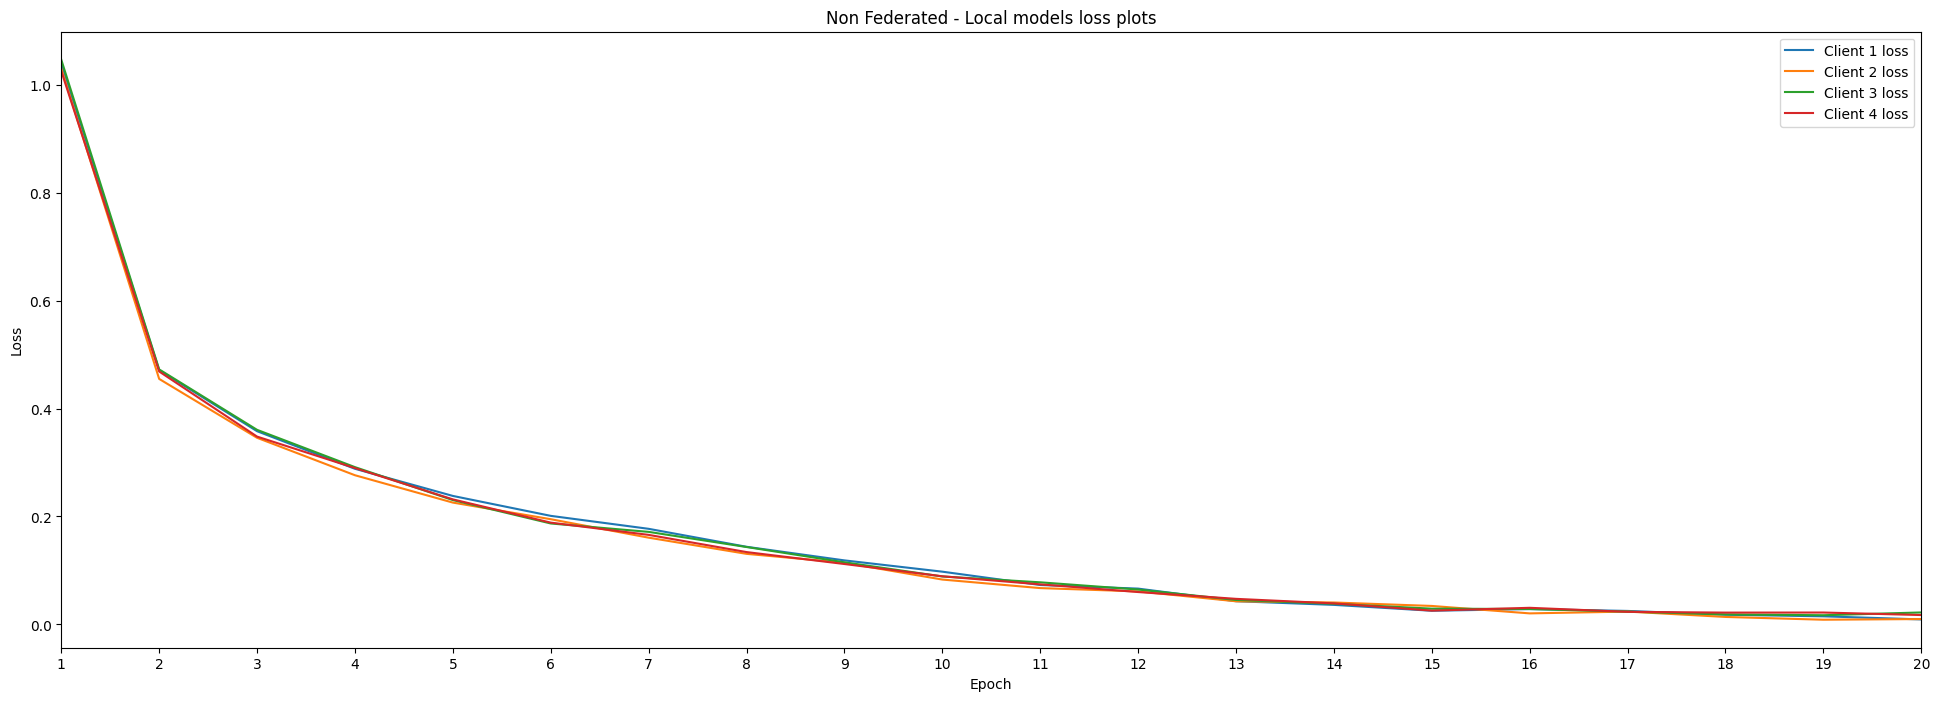

In [31]:
plot_train_loss(client_metrics_noFed, NUM_EPOCHS, title="Non Federated - Local models loss plots")

### 5. Federated local model

In [32]:
# Initialize federated client models

LEARNING_RATE = 1e-4
# Build the server
server = Server(initial_model, local_send_avg=True)

# Build the clients
clients_fed = [
    Client(initial_model, torch.optim.Adam, LEARNING_RATE, nn.CrossEntropyLoss(), train_client_loaders[i], id=i) for i in range(n_clients)
    ]

In [33]:
# Local training on each client
client_metrics_fed = []

# Set the hyperparameters for the epochs and rounds
NUM_EPOCHS = 5
NUM_ROUNDS = 4

# For NUM_ROUNDS we train for  NUM_EPOCHS each round
for round_ in range(NUM_ROUNDS):

  print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)
  print("/"*4,"ROUND "+str(round_),"/"*4)
  print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)

  # Train each client for "n" epochs
  for client in clients_fed:


      metrics = client.train_client(NUM_EPOCHS)

      # We check if we are in the first round (round == 0) or not.
      # If we are not in the first round, we already have the clients previous metrics so
      # we concatenate them with the new metrics.

      if round_ > 0:
        client_metrics_fed[metrics['client_id']]["train_acc"].extend(metrics["train_acc"])
        client_metrics_fed[metrics['client_id']]["train_loss"].extend(metrics["train_loss"])
      else:
        client_metrics_fed.append(metrics)

  # Apply FedAVG on the global model
  if round_ < NUM_ROUNDS-1:

      server.fed_avg(clients_fed)


//// /////// ////
//// ROUND 0 ////
//// /////// ////


train: 100%|██████████| 219/219 [00:12<00:00, 17.12it/s]


[0] ==> Epoch 0: train_acc: 0.65955924, train_loss: 1.05641771


train: 100%|██████████| 219/219 [00:12<00:00, 17.07it/s]


[0] ==> Epoch 1: train_acc: 0.82913566, train_loss: 0.4855308


train: 100%|██████████| 219/219 [00:12<00:00, 16.96it/s]


[0] ==> Epoch 2: train_acc: 0.87678878, train_loss: 0.35672486


train: 100%|██████████| 219/219 [00:16<00:00, 13.30it/s]


[0] ==> Epoch 3: train_acc: 0.90254722, train_loss: 0.28576046


train: 100%|██████████| 219/219 [00:12<00:00, 16.95it/s]


[0] ==> Epoch 4: train_acc: 0.9127075, train_loss: 0.24907952


train: 100%|██████████| 219/219 [00:12<00:00, 17.01it/s]


[1] ==> Epoch 0: train_acc: 0.67076835, train_loss: 1.03364177


train: 100%|██████████| 219/219 [00:14<00:00, 15.57it/s]


[1] ==> Epoch 1: train_acc: 0.83846044, train_loss: 0.46661057


train: 100%|██████████| 219/219 [00:12<00:00, 17.13it/s]


[1] ==> Epoch 2: train_acc: 0.88109887, train_loss: 0.34386831


train: 100%|██████████| 219/219 [00:12<00:00, 17.39it/s]


[1] ==> Epoch 3: train_acc: 0.89927028, train_loss: 0.28987537


train: 100%|██████████| 219/219 [00:12<00:00, 17.46it/s]


[1] ==> Epoch 4: train_acc: 0.91615396, train_loss: 0.24722392


train: 100%|██████████| 219/219 [00:12<00:00, 17.33it/s]


[2] ==> Epoch 0: train_acc: 0.67134068, train_loss: 1.04499116


train: 100%|██████████| 219/219 [00:12<00:00, 17.60it/s]


[2] ==> Epoch 1: train_acc: 0.83388181, train_loss: 0.47399931


train: 100%|██████████| 219/219 [00:12<00:00, 17.37it/s]


[2] ==> Epoch 2: train_acc: 0.86907998, train_loss: 0.36708082


train: 100%|██████████| 219/219 [00:12<00:00, 17.33it/s]


[2] ==> Epoch 3: train_acc: 0.8975533, train_loss: 0.28540726


train: 100%|██████████| 219/219 [00:12<00:00, 17.34it/s]


[2] ==> Epoch 4: train_acc: 0.91386464, train_loss: 0.24428635


train: 100%|██████████| 219/219 [00:12<00:00, 17.44it/s]


[3] ==> Epoch 0: train_acc: 0.67649163, train_loss: 1.04200541


train: 100%|██████████| 219/219 [00:12<00:00, 17.69it/s]


[3] ==> Epoch 1: train_acc: 0.84046359, train_loss: 0.46666813


train: 100%|██████████| 219/219 [00:12<00:00, 18.06it/s]


[3] ==> Epoch 2: train_acc: 0.87623408, train_loss: 0.35561772


train: 100%|██████████| 219/219 [00:12<00:00, 17.94it/s]


[3] ==> Epoch 3: train_acc: 0.89984261, train_loss: 0.2897052


train: 100%|██████████| 219/219 [00:12<00:00, 17.75it/s]


[3] ==> Epoch 4: train_acc: 0.92073258, train_loss: 0.23298908
Update clients with averaging
//// /////// ////
//// ROUND 1 ////
//// /////// ////


train: 100%|██████████| 219/219 [00:12<00:00, 17.32it/s]


[0] ==> Epoch 0: train_acc: 0.92658844, train_loss: 0.21934807


train: 100%|██████████| 219/219 [00:12<00:00, 17.58it/s]


[0] ==> Epoch 1: train_acc: 0.9358901, train_loss: 0.17887359


train: 100%|██████████| 219/219 [00:12<00:00, 17.33it/s]


[0] ==> Epoch 2: train_acc: 0.94848311, train_loss: 0.15467183


train: 100%|██████████| 219/219 [00:12<00:00, 17.25it/s]


[0] ==> Epoch 3: train_acc: 0.96021752, train_loss: 0.12487664


train: 100%|██████████| 219/219 [00:12<00:00, 17.29it/s]


[0] ==> Epoch 4: train_acc: 0.96551231, train_loss: 0.10697317


train: 100%|██████████| 219/219 [00:13<00:00, 15.79it/s]


[1] ==> Epoch 0: train_acc: 0.92559737, train_loss: 0.21688492


train: 100%|██████████| 219/219 [00:12<00:00, 17.46it/s]


[1] ==> Epoch 1: train_acc: 0.93976248, train_loss: 0.18239497


train: 100%|██████████| 219/219 [00:12<00:00, 17.10it/s]


[1] ==> Epoch 2: train_acc: 0.94734583, train_loss: 0.1527173


train: 100%|██████████| 219/219 [00:12<00:00, 17.24it/s]


[1] ==> Epoch 3: train_acc: 0.96551724, train_loss: 0.11884054


train: 100%|██████████| 219/219 [00:12<00:00, 17.55it/s]


[1] ==> Epoch 4: train_acc: 0.97023895, train_loss: 0.09897693


train: 100%|██████████| 219/219 [00:12<00:00, 17.19it/s]


[2] ==> Epoch 0: train_acc: 0.92430963, train_loss: 0.21573522


train: 100%|██████████| 219/219 [00:12<00:00, 17.47it/s]


[2] ==> Epoch 1: train_acc: 0.93747317, train_loss: 0.18169533


train: 100%|██████████| 219/219 [00:12<00:00, 17.33it/s]


[2] ==> Epoch 2: train_acc: 0.95492917, train_loss: 0.14223322


train: 100%|██████████| 219/219 [00:12<00:00, 16.97it/s]


[2] ==> Epoch 3: train_acc: 0.96566032, train_loss: 0.11323888


train: 100%|██████████| 219/219 [00:12<00:00, 17.17it/s]


[2] ==> Epoch 4: train_acc: 0.96995278, train_loss: 0.10115497


train: 100%|██████████| 219/219 [00:12<00:00, 16.99it/s]


[3] ==> Epoch 0: train_acc: 0.92574045, train_loss: 0.22339277


train: 100%|██████████| 219/219 [00:12<00:00, 17.14it/s]


[3] ==> Epoch 1: train_acc: 0.9380455, train_loss: 0.18039545


train: 100%|██████████| 219/219 [00:12<00:00, 17.10it/s]


[3] ==> Epoch 2: train_acc: 0.95249678, train_loss: 0.14529456


train: 100%|██████████| 219/219 [00:12<00:00, 17.42it/s]


[3] ==> Epoch 3: train_acc: 0.96337101, train_loss: 0.1187269


train: 100%|██████████| 219/219 [00:12<00:00, 17.42it/s]


[3] ==> Epoch 4: train_acc: 0.96895121, train_loss: 0.0984694
Update clients with averaging
//// /////// ////
//// ROUND 2 ////
//// /////// ////


train: 100%|██████████| 219/219 [00:12<00:00, 17.40it/s]


[0] ==> Epoch 0: train_acc: 0.97338294, train_loss: 0.09096049


train: 100%|██████████| 219/219 [00:12<00:00, 17.50it/s]


[0] ==> Epoch 1: train_acc: 0.97781912, train_loss: 0.0808346


train: 100%|██████████| 219/219 [00:12<00:00, 17.10it/s]


[0] ==> Epoch 2: train_acc: 0.98440183, train_loss: 0.05890934


train: 100%|██████████| 219/219 [00:12<00:00, 17.29it/s]


[0] ==> Epoch 3: train_acc: 0.99112765, train_loss: 0.04201806


train: 100%|██████████| 219/219 [00:14<00:00, 15.41it/s]


[0] ==> Epoch 4: train_acc: 0.99212936, train_loss: 0.03586128


train: 100%|██████████| 219/219 [00:12<00:00, 17.22it/s]


[1] ==> Epoch 0: train_acc: 0.97195593, train_loss: 0.09436717


train: 100%|██████████| 219/219 [00:12<00:00, 16.91it/s]


[1] ==> Epoch 1: train_acc: 0.97968236, train_loss: 0.07352545


train: 100%|██████████| 219/219 [00:12<00:00, 17.21it/s]


[1] ==> Epoch 2: train_acc: 0.98325941, train_loss: 0.05897113


train: 100%|██████████| 219/219 [00:12<00:00, 16.85it/s]


[1] ==> Epoch 3: train_acc: 0.98883961, train_loss: 0.04577284


train: 100%|██████████| 219/219 [00:12<00:00, 16.95it/s]


[1] ==> Epoch 4: train_acc: 0.99170124, train_loss: 0.03678877


train: 100%|██████████| 219/219 [00:13<00:00, 16.71it/s]


[2] ==> Epoch 0: train_acc: 0.97166977, train_loss: 0.09528054


train: 100%|██████████| 219/219 [00:12<00:00, 16.86it/s]


[2] ==> Epoch 1: train_acc: 0.98082701, train_loss: 0.07561859


train: 100%|██████████| 219/219 [00:13<00:00, 16.81it/s]


[2] ==> Epoch 2: train_acc: 0.98511947, train_loss: 0.05934686


train: 100%|██████████| 219/219 [00:12<00:00, 17.29it/s]


[2] ==> Epoch 3: train_acc: 0.99012734, train_loss: 0.04241438


train: 100%|██████████| 219/219 [00:12<00:00, 17.09it/s]


[2] ==> Epoch 4: train_acc: 0.99484905, train_loss: 0.03091476


train: 100%|██████████| 219/219 [00:12<00:00, 17.00it/s]


[3] ==> Epoch 0: train_acc: 0.96995278, train_loss: 0.09513978


train: 100%|██████████| 219/219 [00:12<00:00, 17.08it/s]


[3] ==> Epoch 1: train_acc: 0.98125626, train_loss: 0.07016704


train: 100%|██████████| 219/219 [00:12<00:00, 17.02it/s]


[3] ==> Epoch 2: train_acc: 0.98540564, train_loss: 0.05634206


train: 100%|██████████| 219/219 [00:12<00:00, 17.14it/s]


[3] ==> Epoch 3: train_acc: 0.98740879, train_loss: 0.04884862


train: 100%|██████████| 219/219 [00:12<00:00, 16.92it/s]


[3] ==> Epoch 4: train_acc: 0.98912577, train_loss: 0.03970327
Update clients with averaging
//// /////// ////
//// ROUND 3 ////
//// /////// ////


train: 100%|██████████| 219/219 [00:13<00:00, 16.75it/s]


[0] ==> Epoch 0: train_acc: 0.99112765, train_loss: 0.03605458


train: 100%|██████████| 219/219 [00:12<00:00, 16.85it/s]


[0] ==> Epoch 1: train_acc: 0.99012593, train_loss: 0.03644401


train: 100%|██████████| 219/219 [00:14<00:00, 15.60it/s]


[0] ==> Epoch 2: train_acc: 0.99470521, train_loss: 0.02543344


train: 100%|██████████| 219/219 [00:12<00:00, 17.08it/s]


[0] ==> Epoch 3: train_acc: 0.99699485, train_loss: 0.01839299


train: 100%|██████████| 219/219 [00:12<00:00, 17.20it/s]


[0] ==> Epoch 4: train_acc: 0.99670864, train_loss: 0.01714141


train: 100%|██████████| 219/219 [00:12<00:00, 17.25it/s]


[1] ==> Epoch 0: train_acc: 0.99012734, train_loss: 0.04081757


train: 100%|██████████| 219/219 [00:12<00:00, 17.15it/s]


[1] ==> Epoch 1: train_acc: 0.9959937, train_loss: 0.02429627


train: 100%|██████████| 219/219 [00:12<00:00, 17.31it/s]


[1] ==> Epoch 2: train_acc: 0.9944198, train_loss: 0.02720446


train: 100%|██████████| 219/219 [00:12<00:00, 16.91it/s]


[1] ==> Epoch 3: train_acc: 0.99399056, train_loss: 0.02509971


train: 100%|██████████| 219/219 [00:12<00:00, 17.36it/s]


[1] ==> Epoch 4: train_acc: 0.99656603, train_loss: 0.01819049


train: 100%|██████████| 219/219 [00:12<00:00, 17.32it/s]


[2] ==> Epoch 0: train_acc: 0.99313206, train_loss: 0.03113587


train: 100%|██████████| 219/219 [00:12<00:00, 17.42it/s]


[2] ==> Epoch 1: train_acc: 0.99327515, train_loss: 0.03131007


train: 100%|██████████| 219/219 [00:12<00:00, 17.32it/s]


[2] ==> Epoch 2: train_acc: 0.99413364, train_loss: 0.02365956


train: 100%|██████████| 219/219 [00:12<00:00, 17.30it/s]


[2] ==> Epoch 3: train_acc: 0.99470597, train_loss: 0.02388756


train: 100%|██████████| 219/219 [00:12<00:00, 17.36it/s]


[2] ==> Epoch 4: train_acc: 0.99642295, train_loss: 0.01921505


train: 100%|██████████| 219/219 [00:13<00:00, 16.79it/s]


[3] ==> Epoch 0: train_acc: 0.99112892, train_loss: 0.03365203


train: 100%|██████████| 219/219 [00:12<00:00, 16.89it/s]


[3] ==> Epoch 1: train_acc: 0.99384747, train_loss: 0.02953059


train: 100%|██████████| 219/219 [00:12<00:00, 17.20it/s]


[3] ==> Epoch 2: train_acc: 0.99384747, train_loss: 0.02749555


train: 100%|██████████| 219/219 [00:12<00:00, 16.99it/s]


[3] ==> Epoch 3: train_acc: 0.9968522, train_loss: 0.01856617


train: 100%|██████████| 219/219 [00:12<00:00, 16.87it/s]

[3] ==> Epoch 4: train_acc: 0.99885534, train_loss: 0.01235779


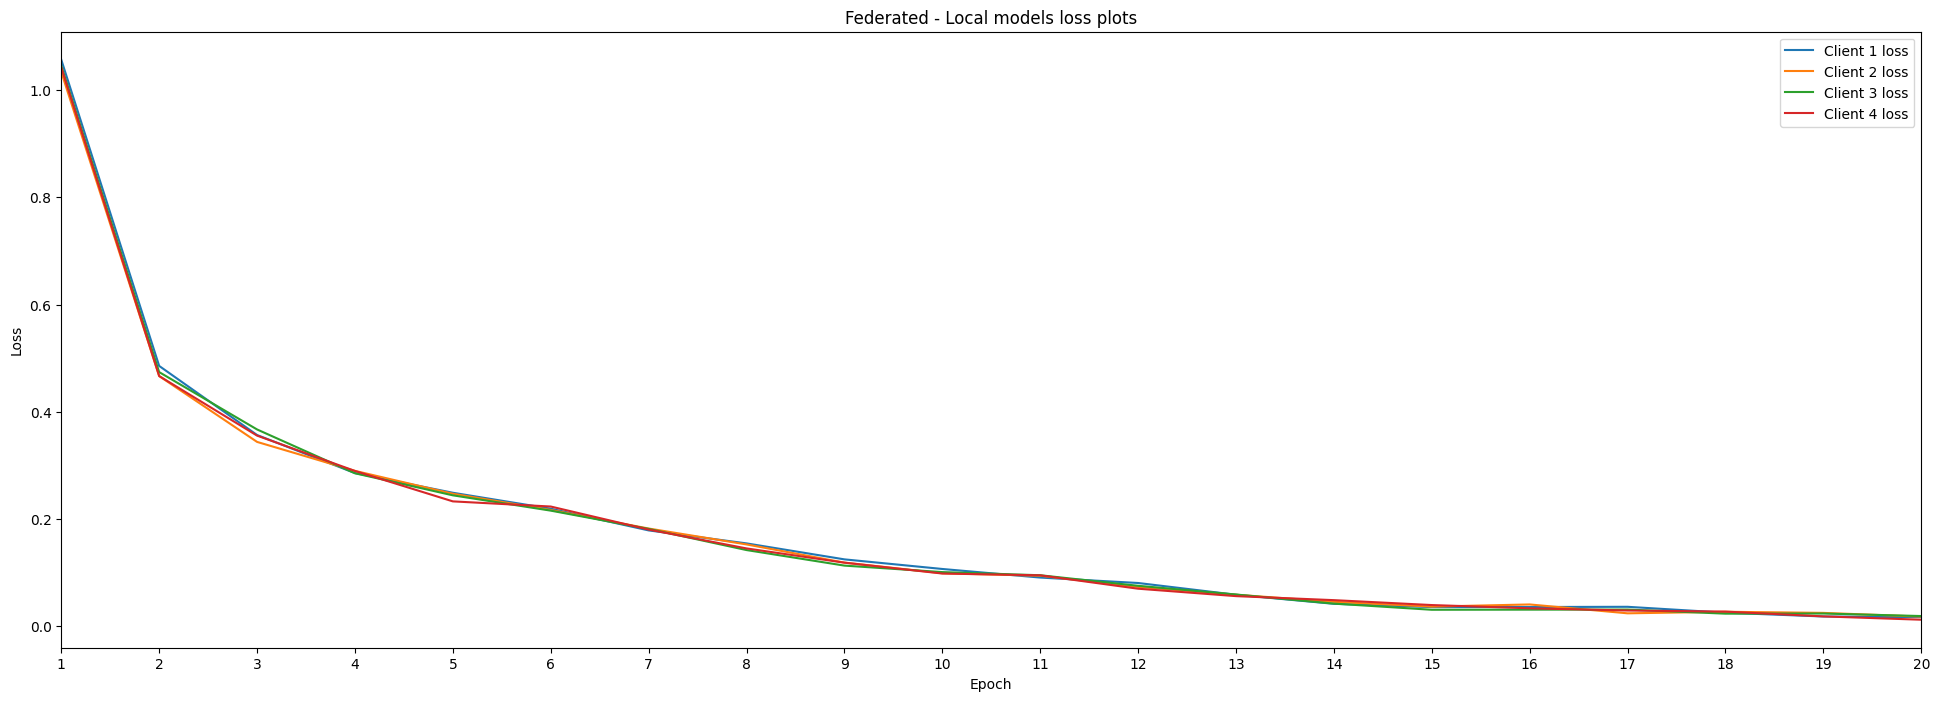

In [34]:
plot_train_loss(client_metrics_fed, NUM_EPOCHS * NUM_ROUNDS, title="Federated - Local models loss plots")

## IV. Evaluate on the global test / local test

For the evaluation step, we will use the local test sets and the global test set prepared earlier.

First, we iterate over the clients (each iteration includes non-federated clients and federated clients) and test on the local test sets, followed by the global test set. After completing client testing, we proceed to evaluate the global model in a similar manner.

Finally, we plot the accuracy, sensitivity, specificity, area under the curve (AUC), expected calibration error [2], and balanced accuracy.


**Note**

When calculating metrics for multi-class classification, **especially** AUC, it's important to handle the case where a class might not be present in the true labels. If there are no true instances of a particular class, the AUC score for that class **cannot be calculated**.

In [35]:
def expected_calibration_error(samples, true_labels, M=5):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece

In [36]:
def calculate_metrics(pred_probs, true_labels):
    """
    Calculate accuracy, sensitivity, specificity, AUC,
    ECE, and balanced accuracy.

    Parameters:
    - pred_probs: Predicted probabilities.
    - true_labels: True labels.

    Returns:
    dict: Dictionary containing accuracy, sensitivity, specificity, AUC, ECE, balanced_accuracy.
    """

    # Convert to NumPy arrays
    true_labels = true_labels.detach().cpu().numpy()
    pred_probs = pred_probs.detach().cpu().numpy()

    # Get predicted labels
    pred_labels = np.argmax(pred_probs, axis=1)

    # Calculate accuracy
    accuracy = np.mean(pred_labels == true_labels)

    # Calculate sensitivity and specificity

    sensitivity = recall_score(true_labels, pred_labels, average="macro", zero_division=0)
    specificity = recall_score(np.logical_not(true_labels), np.logical_not(pred_labels), average="macro", zero_division=0)

    # Calculate the balanced accuracy
    balanced_acc = (0.5)*(sensitivity + specificity)

    # Calculate the expected calibration error
    ece = expected_calibration_error(pred_probs, true_labels)

    # Calculate the AUC
    n_classes = pred_probs.shape[1]

    auc = []

    for i in range(n_classes):
        true_binary = (true_labels == i).astype(int)
        pred_binary = (pred_labels == i).astype(int)

        if np.sum(true_binary) > 0 and np.sum(pred_binary) > 0:
            auc.append(roc_auc_score(true_binary, pred_probs[:, i]))  # AUC for class i


    return {
        'accuracy': accuracy,
        'balanced_acc': balanced_acc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'auc': np.round(np.mean(auc), 8),
        "ece": ece
    }


In [37]:
# Validate global model (using one of the client loaders as an example)

def validate_model(model, val_loader):
  """
  This function takes the loader for the test data, infer the predicted labels and then
  calculates the accuracy, sensitivity, specificity, AUC, ECE, and balanced accuracy.

  Parameters:
  - model: The model used for the prediction.
  - val_loader: The testing DataLoader.

  Returns:
  - dict: a dictionnary of average accuracy, sensitivity, specificity, AUC, ECE, balanced_accuracy.
  """


  model = model.to(DEVICE)
  model.eval()

  acc= []
  balanced_acc = []
  sensitivity = []
  specificity = []
  auc = []
  ece = []

  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images.to(DEVICE))
      metric = calculate_metrics(outputs.data, labels)

      # Append the metric to its appropriate list
      acc.append(metric['accuracy'])
      balanced_acc.append(metric['balanced_acc'])
      sensitivity.append(metric['sensitivity'])
      specificity.append(metric['specificity'])
      auc.append(metric['auc'])
      ece.append(metric['ece'])

  return {
      'val_acc': np.round(np.mean(acc), 8),
      'val_balanced_acc': np.round(np.mean(balanced_acc), 8),
      'val_sensitivity': np.round(np.mean(sensitivity), 8),
      'val_specificity': np.round(np.mean(specificity), 8),
      'val_auc': np.round(np.mean(auc), 8),
      'val_ece': np.round(np.mean(ece), 8)
      }

In [38]:
acc_metrics = []
balanced_acc_metrics = []
sensitivity_metrics = []
specificity_metrics = []
auc_metrics = []
ece_metrics = []


# Iterate on the clients
for i, client_noFed, client_fed in zip(range(n_clients), clients_noFed, clients_fed):
  print(f"Client {i+1}")

  # We pass the local test sets
  metric_nofed = validate_model(client_noFed.model, test_client_loaders[i])
  metric_fed = validate_model(client_fed.model, test_client_loaders[i])

  # We pass the global set
  metric_glob_nofed = validate_model(client_noFed.model, global_test_loader)
  metric_glob_fed = validate_model(client_fed.model, global_test_loader)

  acc_metrics.append({
      "client_id": f"Client_{i+1}",
      "acc_noFed": metric_nofed['val_acc'],
      "acc_Fed": metric_fed['val_acc'],
      "acc_global_noFed": metric_glob_nofed['val_acc'],
      "acc_global_Fed": metric_glob_fed['val_acc'],
  })

  ece_metrics.append({
      "client_id": f"Client_{i+1}",
      "ece_noFed": metric_nofed['val_ece'],
      "ece_Fed": metric_fed['val_ece'],
      "ece_global_noFed": metric_glob_nofed['val_ece'],
      "ece_global_Fed": metric_glob_fed['val_ece'],
  })

  balanced_acc_metrics.append({
      "client_id": f"Client_{i+1}",
      "b_acc_noFed": metric_nofed['val_balanced_acc'],
      "b_acc_Fed": metric_fed['val_balanced_acc'],
      "b_acc_global_noFed": metric_glob_nofed['val_balanced_acc'],
      "b_acc_global_Fed": metric_glob_fed['val_balanced_acc'],
  })

  sensitivity_metrics.append({
      "client_id": f"Client_{i+1}",
      "sensitivity_noFed": metric_nofed['val_sensitivity'],
      "sensitivity_Fed": metric_fed['val_sensitivity'],
      "sensitivity_global_noFed": metric_glob_nofed['val_sensitivity'],
      "sensitivity_global_Fed": metric_glob_fed['val_sensitivity'],
  })

  specificity_metrics.append({
      "client_id": f"Client_{i+1}",
      "specificity_noFed": metric_nofed['val_specificity'],
      "specificity_Fed": metric_fed['val_specificity'],
      "specificity_global_noFed": metric_glob_nofed['val_specificity'],
      "specificity_global_Fed": metric_glob_fed['val_specificity'],
  })

  auc_metrics.append({
      "client_id": f"Client_{i+1}",
      "AUC_noFed": metric_nofed['val_auc'],
      "AUC_Fed": metric_fed['val_auc'],
      "AUC_global_noFed": metric_glob_nofed['val_auc'],
      "AUC_global_Fed": metric_glob_fed['val_auc'],
  })

Client 1
Client 2
Client 3
Client 4


In [39]:
# Let's calculate the average for each metric
# and add them to their respective metric list

acc_metrics.append({
    "client_id": f"Average",
    "acc_noFed": np.round(np.mean([m['acc_noFed'] for m in acc_metrics]), 8),
    "acc_Fed": np.round(np.mean([m['acc_Fed'] for m in acc_metrics]), 8),
    "acc_global_noFed": np.round(np.mean([m['acc_global_noFed'] for m in acc_metrics]), 8),
    "acc_global_Fed": np.round(np.mean([m['acc_global_Fed'] for m in acc_metrics]), 8),
})

balanced_acc_metrics.append({
    "client_id": f"Average",
    "b_acc_noFed": np.round(np.mean([m['b_acc_noFed'] for m in balanced_acc_metrics]), 8),
    "b_acc_Fed": np.round(np.mean([m['b_acc_Fed'] for m in balanced_acc_metrics]), 8),
    "b_acc_global_noFed": np.round(np.mean([m['b_acc_global_noFed'] for m in balanced_acc_metrics]), 8),
    "b_acc_global_Fed": np.round(np.mean([m['b_acc_global_Fed'] for m in balanced_acc_metrics]), 8),
})

sensitivity_metrics.append({
    "client_id": f"Average",
    "sensitivity_noFed": np.round(np.mean([m['sensitivity_noFed'] for m in sensitivity_metrics]), 8),
    "sensitivity_Fed": np.round(np.mean([m['sensitivity_Fed'] for m in sensitivity_metrics]), 8),
    "sensitivity_global_noFed": np.round(np.mean([m['sensitivity_global_noFed'] for m in sensitivity_metrics]), 8),
    "sensitivity_global_Fed": np.round(np.mean([m['sensitivity_global_Fed'] for m in sensitivity_metrics]), 8),
})

specificity_metrics.append({
    "client_id": f"Average",
    "specificity_noFed": np.round(np.mean([m['specificity_noFed'] for m in specificity_metrics]), 8),
    "specificity_Fed": np.round(np.mean([m['specificity_Fed'] for m in specificity_metrics]), 8),
    "specificity_global_noFed": np.round(np.mean([m['specificity_global_noFed'] for m in specificity_metrics]), 8),
    "specificity_global_Fed": np.round(np.mean([m['specificity_global_Fed'] for m in specificity_metrics]), 8),
})

auc_metrics.append({
    "client_id": f"Average",
    "AUC_noFed": np.round(np.mean([m['AUC_noFed'] for m in auc_metrics]), 3),
    "AUC_Fed": np.round(np.mean([m['AUC_Fed'] for m in auc_metrics]), 3),
    "AUC_global_noFed": np.round(np.mean([m['AUC_global_noFed'] for m in auc_metrics]), 3),
    "AUC_global_Fed": np.round(np.mean([m['AUC_global_Fed'] for m in auc_metrics]), 3),
})

ece_metrics.append({
    "client_id": f"Average",
    "ece_noFed": np.round(np.mean([m['ece_noFed'] for m in ece_metrics]), 8),
    "ece_Fed": np.round(np.mean([m['ece_Fed'] for m in ece_metrics]), 8),
    "ece_global_noFed": np.round(np.mean([m['ece_global_noFed'] for m in ece_metrics]), 8),
    "ece_global_Fed": np.round(np.mean([m['ece_global_Fed'] for m in ece_metrics]), 8),
})


Finally we plot the Bar plots of the metrics where in x-axis we have the client and the legends are the keys to the model used (fed or no fed) and the local or global testing sets (we will only use "global" to define the global sets).

In [40]:

def plot_acc_sens_spec(metrics, ax, title="Metrics", limit=(0,1), style=None):
  """
  This function plots the metrics calculated after the inference step.

  Parameters:
  - metrics: A list of dictionnaries for each client that contain calculated metrics.
  - ax: The axis to plot the metrics on.
  - title: The title of the plot. Default is 'Metrics'.
  - limit: The limits of the y-axis. Default is (0,1).
  - style: The style dictionnary of each metric label bar. For each metric as a key we
  have a list of the color and hatch. Default is None.
  """

  # Extract client ids and metrics
  client_ids = [m['client_id'] for m in metrics]
  # Add the Average tag to the client ids list
  metrics_labels = list(metrics[0].keys())[1:]

  # Prepare the data for plotting
  values = {metric: [m[metric] for m in metrics] for metric in metrics_labels}

  # Plotting
  n_clients = len(client_ids)
  n_metrics = len(metrics_labels)
  spacing = 0.5  # spacing between groups
  width = 0.1  # the width of the bars

  x = np.arange(n_clients) * (n_metrics * width + spacing)  # the label locations with spacing


  # Plot bars for each metric with spacing
  for i, metric in enumerate(metrics_labels):

    yerr = None
    if style != None:
      ax.bar(x + i * width, values[metric], width, label=metric, yerr=yerr, hatch=style[metric][1], color=style[metric][0])
    else:
      ax.bar(x + i * width, values[metric], width, label=metric, yerr=yerr)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_xlabel('Client ID')
  ax.set_ylabel('Scores')
  ax.set_ylim(limit[0], limit[1])
  ax.set_title(title)
  ax.set_xticks(x + width * (n_metrics - 1) / 2)
  ax.set_xticklabels(client_ids)
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [41]:
## set up the styles for each metric
acc_style={
    "acc_noFed": ("#008dda", None),
    "acc_Fed": ("#ace2e1", "///"),
    "acc_global_noFed": ("#ffcf81", None),
    "acc_global_Fed": ("#f7eedd", "///"),
}

b_acc_style={
    "b_acc_noFed": ("#008dda", None),
    "b_acc_Fed": ("#ace2e1", "///"),
    "b_acc_global_noFed": ("#ffcf81", None),
    "b_acc_global_Fed": ("#f7eedd", "///"),
}

sensitivity_style={
    "sensitivity_noFed": ("#008dda", None),
    "sensitivity_Fed": ("#ace2e1", "///"),
    "sensitivity_global_noFed": ("#ffcf81", None),
    "sensitivity_global_Fed": ("#f7eedd", "///"),
}

specificity_style={
    "specificity_noFed": ("#008dda", None),
    "specificity_Fed": ("#ace2e1", "///"),
    "specificity_global_noFed": ("#ffcf81", None),
    "specificity_global_Fed": ("#f7eedd", "///"),
}

auc_style={
    "AUC_noFed": ("#008dda", None),
    "AUC_Fed": ("#ace2e1", "///"),
    "AUC_global_noFed": ("#ffcf81", None),
    "AUC_global_Fed": ("#f7eedd", "///"),
}

ece_style={
    "ece_noFed": ("#008dda", None),
    "ece_Fed": ("#ace2e1", "///"),
    "ece_global_noFed": ("#ffcf81", None),
    "ece_global_Fed": ("#f7eedd", "///"),
}

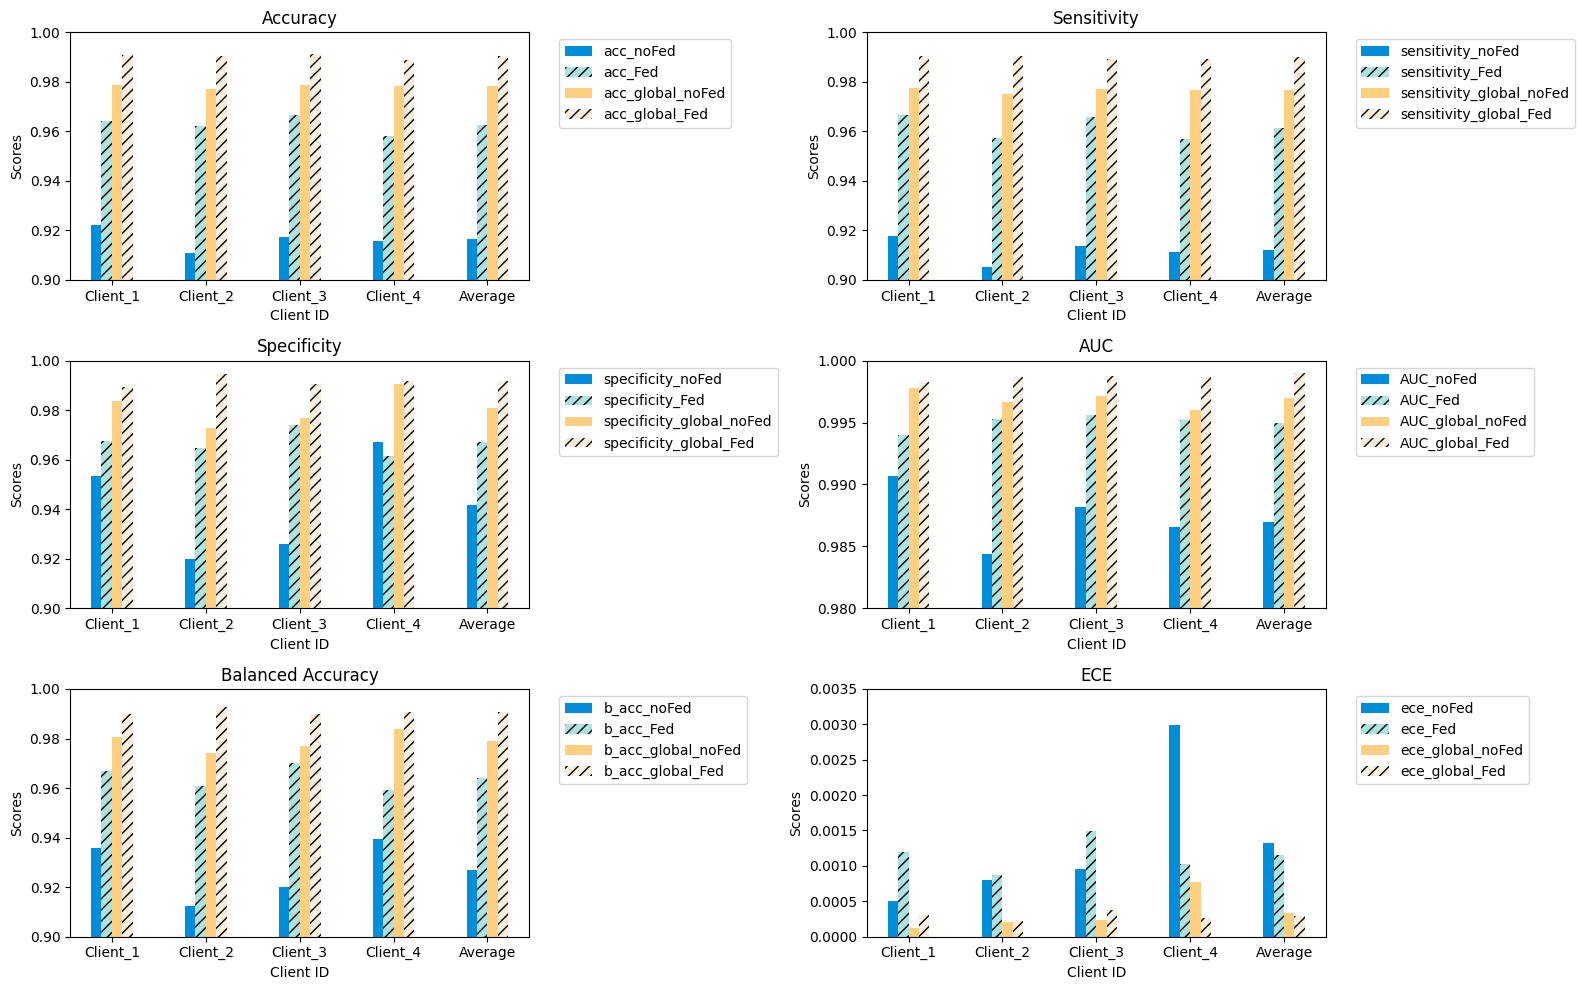

In [58]:
fig, ax = plt.subplots(3, 2, figsize=(16, 10))

# Plot Accuracy
plot_acc_sens_spec(acc_metrics, ax[0][0], title="Accuracy", limit=(0.9, 1), style=acc_style)

# Plot sensitivity
plot_acc_sens_spec(sensitivity_metrics, ax[0][1], title="Sensitivity", limit=(0.9, 1), style=sensitivity_style)

# Plot specificity
plot_acc_sens_spec(specificity_metrics, ax[1][0], title="Specificity", limit=(0.9, 1), style=specificity_style)

# Plot AUC
plot_acc_sens_spec(auc_metrics, ax[1][1], title="AUC", limit=(0.98, 1), style=auc_style)

# Plot balanced accuracy
plot_acc_sens_spec(balanced_acc_metrics, ax[2][0], title="Balanced Accuracy", limit=(0.9, 1), style=b_acc_style)

# Plot Expected Calibration Error
plot_acc_sens_spec(ece_metrics, ax[2][1], title="ECE", limit=(0.0, 0.0035), style=ece_style)

fig.tight_layout()
plt.show()

**Question 1**:

What do you see in these barplots?

# Part 2. 💡 Federated learning with non-IID label distribution

In this part, we will:
* **Understand** what non-IID data is and what it means to have non-IID labels/classes.
* **Implement** non-IID on the original dataset (without undersampling).
* **Plot** the class distribution of the local training sets, local testing sets, and global testing sets.
* **Train** federated approach models and non-federated approach models on their local training sets.
* **Plot** the results for the local testing sets and the global testing sets.

## I. Split the data into non-IID splits

In [59]:
# Apply our function "split_nonIID" to create the local client datasets + global testing datasets
# We are fetching the original data to ensure the non-IID scenario since the classes are not uniform
# which is X_combined for the images and y_combined for the labels

def split_nonIID(X, y, ratio_clients=[], ratio_global=1, train_split=0.8, test_split=0.2, shuffle=False):
    """
    Splits the dataset into local client datasets and a global testing dataset, following non-IID principles.

    Parameters:
        - X: The features of the dataset.
        - y: The labels of the dataset.
        - ratio_clients: A list of ratios for each client.
        - ratio_global: The ratio for the global set.
        - train_split: The ratio for training samples in each split (local or global).
        - test_split: The ratio for test samples in each split (local or global).
        - shuffle: Whether to shuffle the data before splitting.

    Returns:
        A list of tuples where each tuple contains train and test indices for each split.
    """

    # Check if the ratios add up to 1
    if sum(ratio_clients) + ratio_global != 1:
        raise ValueError("The ratios for clients and the global set should add up to 1.")

    # Get the number of samples in the dataset
    n_samples = len(X)

    # Calculate the number of samples per client
    for i in range(len(ratio_clients)):
        ratio_clients[i] = int(n_samples * ratio_clients[i])

    # Calculate the number of samples for the global set
    ratio_global = int(n_samples * ratio_global)

    # Split the data into local splits
    local_splits = []

    for i in range(len(ratio_clients)):
        # Calculate the indices for the current client
        client_split = (int(train_split * ratio_clients[i]), int(test_split * ratio_clients[i]))
        local_splits.append(client_split)

    # Add the global split
    global_split = (int(train_split * ratio_global), int(test_split * ratio_global))
    local_splits.append(global_split)

    print(local_splits)

    # Shuffle the data if needed
    indices = []
    if shuffle:
        indices = list(range(len(X)))
        np.random.seed(42)
        np.random.shuffle(indices)

    # Split the data into local and global splits
    start = 0
    for i in range(len(local_splits)):
        train_idx, test_idx = local_splits[i]

        train_indices = indices[start: start + train_idx]
        start += train_idx

        test_indices = indices[start: start + test_idx]
        start += test_idx

        # Update local_splits with the shuffled indices
        local_splits[i] = (train_indices, test_indices)

    return local_splits


In [60]:
# We split our original data X_combined and y_combined into 4 clients where
# each one has it's own ratio of the data and the global ration is set to 0.2
list_clients = [0.2, 0.3, 0.1, 0.2]
n_clients = 4

## We split the data into 4 local splits and 1 global split
local_splits = split_nonIID(X_combined, y_combined, ratio_clients=list_clients, ratio_global=0.2, shuffle=True)

[(2460, 615), (3691, 922), (1230, 307), (2460, 615), (2460, 615)]


In [61]:
# for each clients' local set
for i in range(len(local_splits)-1):
    # Get train and test indicies for each client
    train_idx, val_idx = local_splits[i]
    print(f"Client {i+1} has {np.round((len(train_idx)/len(y_combined[train_idx+val_idx])),2)} train and {np.round((len(val_idx)/len(y_combined[train_idx+val_idx])),2)} test.")


Client 1 has 0.8 train and 0.2 test.
Client 2 has 0.8 train and 0.2 test.
Client 3 has 0.8 train and 0.2 test.
Client 4 has 0.8 train and 0.2 test.


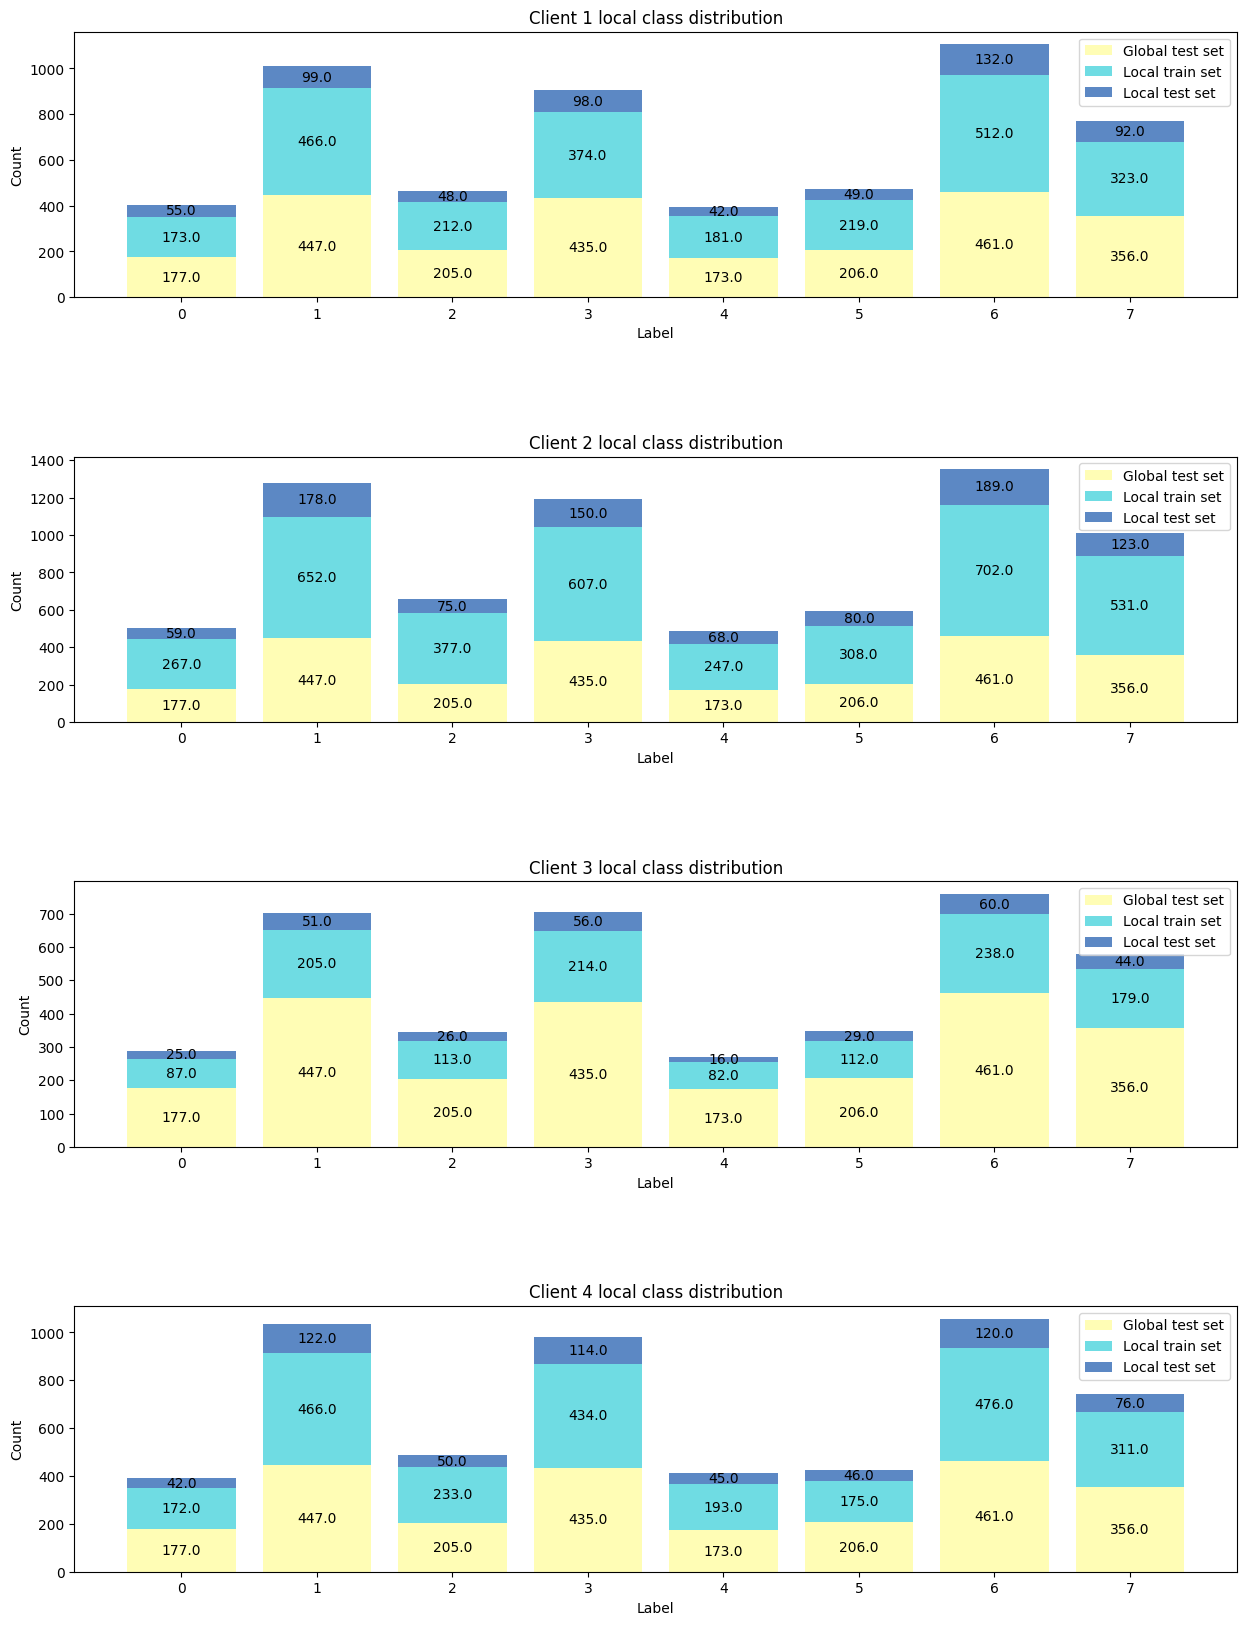

In [62]:
fig, ax = plt.subplots(n_clients, figsize=(15, 20))

# Iterate over each client to visualize label distributions
for i in range(n_clients):
    train_idx, val_idx = local_splits[i]

    # Calculate label distributions for the local train and test sets
    labels, counts_train = np.unique(y_combined[train_idx], return_counts=True)
    labels, counts_test = np.unique(y_combined[val_idx], return_counts=True)

    # Get the label distribution for the global test set (last split in local_splits)
    global_test = y_combined[local_splits[-1][0]]
    labels, counts_global_test = np.unique(global_test, return_counts=True)

    # Plot the bar charts for global test, local train, and local test sets
    ax[i].bar(labels, counts_global_test, color='#fffdb5', tick_label=labels, label='Global test set')
    ax[i].bar(labels, counts_train, color='#6fdce3', tick_label=labels, label='Local train set', bottom=counts_global_test)
    ax[i].bar(labels, counts_test, color='#5c88c4', tick_label=labels, label='Local test set', bottom=counts_global_test + counts_train)

    # Add text annotations for each bar to show exact counts
    for xpos, ypos, yval in zip(labels, counts_global_test/2, counts_global_test):
        ax[i].text(xpos, ypos, "%.1f" % yval, ha="center", va="center")
    for xpos, ypos, yval in zip(labels, counts_global_test + counts_train/2, counts_train):
        ax[i].text(xpos, ypos, "%.1f" % yval, ha="center", va="center")
    for xpos, ypos, yval in zip(labels, counts_global_test + counts_train + counts_test/2, counts_test):
        ax[i].text(xpos, ypos, "%.1f" % yval, ha="center", va="center")

    # Set labels and title for the current subplot
    ax[i].set_xlabel('Label')
    ax[i].set_ylabel('Count')
    ax[i].set_title(f'Client {i+1} local class distribution')
    ax[i].legend(loc="upper right")

# Adjust spacing between subplots and display the plot
fig.subplots_adjust(hspace=0.6, wspace=0.6)
plt.legend(loc='upper right')
plt.show()


## II. Prepare the dataset

In [63]:
torch.manual_seed(42)

# Convert it to a PyTorch Dataset
train_client_datasets = []
test_client_datasets = []

for i in range(len(local_splits) - 1):

    # Append to the clients' local train and test datasets
    train_client_datasets.append(TransformDataset(Subset(BloodMNISTDataset(X_combined, y_combined), local_splits[i][0]), transform=transform))
    test_client_datasets.append(TransformDataset(Subset(BloodMNISTDataset(X_combined, y_combined), local_splits[i][1]), transform=transform))

# Append the global test dataset
global_test_dataset = TransformDataset(Subset(BloodMNISTDataset(X_combined, y_combined), local_splits[-1][0]), transform=transform)

# Now we will build our dataloaders, which are modules that help us iterate over each batch of the data

# We set the batch size (you can change it and experiment with other values and look at the results)
BATCH_SIZE = 32

# We start by building a list of loaders for the local train sets for n_clients
train_client_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in train_client_datasets]

# Then we build another list of loaders for the local test sets for n_clients
test_client_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in test_client_datasets]

# And we finish with the global test set
global_test_loader = DataLoader(global_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## III. Federated vs non-federated approaches

### 1. Non-Federated (local model training with no Fed)

In [64]:
# Let's first initialize our initial_model.
torch.manual_seed(42) # Reminder: we will set a seed for reproducibility
initial_model = Net(in_channels=ds_info['n_channels'], num_classes=len(ds_info['label']))

In [65]:
# Initialize non-federated clients
LEARNING_RATE = 1e-4

clients_noFed = [
    Client(initial_model, torch.optim.Adam, LEARNING_RATE, nn.CrossEntropyLoss(), train_client_loaders[i], id=i) for i in range(n_clients)
    ]

In [66]:
# Local training for each client
client_metrics_noFed = []

# Set the hyperparameters for the epochs
NUM_EPOCHS = 20
# Train each client for "n" epochs
for client in clients_noFed:

  metrics = client.train_client(NUM_EPOCHS)
  client_metrics_noFed.append(metrics)

train: 100%|██████████| 77/77 [00:05<00:00, 14.47it/s]


[0] ==> Epoch 0: train_acc: 0.47764228, train_loss: 1.53966242


train: 100%|██████████| 77/77 [00:04<00:00, 18.60it/s]


[0] ==> Epoch 1: train_acc: 0.7199187, train_loss: 0.81215463


train: 100%|██████████| 77/77 [00:04<00:00, 18.47it/s]


[0] ==> Epoch 2: train_acc: 0.80528455, train_loss: 0.57755189


train: 100%|██████████| 77/77 [00:05<00:00, 14.67it/s]


[0] ==> Epoch 3: train_acc: 0.84065041, train_loss: 0.45275987


train: 100%|██████████| 77/77 [00:04<00:00, 18.51it/s]


[0] ==> Epoch 4: train_acc: 0.87073171, train_loss: 0.37588702


train: 100%|██████████| 77/77 [00:04<00:00, 18.61it/s]


[0] ==> Epoch 5: train_acc: 0.89308943, train_loss: 0.31442928


train: 100%|██████████| 77/77 [00:05<00:00, 14.39it/s]


[0] ==> Epoch 6: train_acc: 0.91300813, train_loss: 0.26814574


train: 100%|██████████| 77/77 [00:04<00:00, 18.78it/s]


[0] ==> Epoch 7: train_acc: 0.90813008, train_loss: 0.25480184


train: 100%|██████████| 77/77 [00:04<00:00, 18.39it/s]


[0] ==> Epoch 8: train_acc: 0.93089431, train_loss: 0.21102836


train: 100%|██████████| 77/77 [00:05<00:00, 14.88it/s]


[0] ==> Epoch 9: train_acc: 0.95609756, train_loss: 0.15753019


train: 100%|██████████| 77/77 [00:04<00:00, 18.39it/s]


[0] ==> Epoch 10: train_acc: 0.95691057, train_loss: 0.14041389


train: 100%|██████████| 77/77 [00:04<00:00, 18.70it/s]


[0] ==> Epoch 11: train_acc: 0.97764228, train_loss: 0.10375602


train: 100%|██████████| 77/77 [00:05<00:00, 14.32it/s]


[0] ==> Epoch 12: train_acc: 0.97682927, train_loss: 0.09486081


train: 100%|██████████| 77/77 [00:04<00:00, 18.54it/s]


[0] ==> Epoch 13: train_acc: 0.98861789, train_loss: 0.07063155


train: 100%|██████████| 77/77 [00:04<00:00, 18.03it/s]


[0] ==> Epoch 14: train_acc: 0.98902439, train_loss: 0.06386419


train: 100%|██████████| 77/77 [00:05<00:00, 14.79it/s]


[0] ==> Epoch 15: train_acc: 0.99146341, train_loss: 0.04820152


train: 100%|██████████| 77/77 [00:04<00:00, 18.55it/s]


[0] ==> Epoch 16: train_acc: 0.99552846, train_loss: 0.0429398


train: 100%|██████████| 77/77 [00:04<00:00, 16.79it/s]


[0] ==> Epoch 17: train_acc: 0.99837398, train_loss: 0.02824957


train: 100%|██████████| 77/77 [00:05<00:00, 13.55it/s]


[0] ==> Epoch 18: train_acc: 0.99878049, train_loss: 0.02546294


train: 100%|██████████| 77/77 [00:04<00:00, 18.50it/s]


[0] ==> Epoch 19: train_acc: 0.99756098, train_loss: 0.02212286


train: 100%|██████████| 116/116 [00:07<00:00, 15.58it/s]


[1] ==> Epoch 0: train_acc: 0.61013276, train_loss: 1.29647845


train: 100%|██████████| 116/116 [00:06<00:00, 18.56it/s]


[1] ==> Epoch 1: train_acc: 0.79219724, train_loss: 0.59874233


train: 100%|██████████| 116/116 [00:07<00:00, 15.39it/s]


[1] ==> Epoch 2: train_acc: 0.85396911, train_loss: 0.43391754


train: 100%|██████████| 116/116 [00:06<00:00, 18.78it/s]


[1] ==> Epoch 3: train_acc: 0.87185045, train_loss: 0.36248264


train: 100%|██████████| 116/116 [00:07<00:00, 15.77it/s]


[1] ==> Epoch 4: train_acc: 0.89244107, train_loss: 0.30527291


train: 100%|██████████| 116/116 [00:06<00:00, 18.65it/s]


[1] ==> Epoch 5: train_acc: 0.91601192, train_loss: 0.24939313


train: 100%|██████████| 116/116 [00:07<00:00, 15.91it/s]


[1] ==> Epoch 6: train_acc: 0.92657816, train_loss: 0.21852663


train: 100%|██████████| 116/116 [00:06<00:00, 18.77it/s]


[1] ==> Epoch 7: train_acc: 0.94500135, train_loss: 0.18064427


train: 100%|██████████| 116/116 [00:07<00:00, 15.38it/s]


[1] ==> Epoch 8: train_acc: 0.94798158, train_loss: 0.1571582


train: 100%|██████████| 116/116 [00:06<00:00, 18.54it/s]


[1] ==> Epoch 9: train_acc: 0.9639664, train_loss: 0.12114871


train: 100%|██████████| 116/116 [00:07<00:00, 16.18it/s]


[1] ==> Epoch 10: train_acc: 0.97588729, train_loss: 0.0929433


train: 100%|██████████| 116/116 [00:06<00:00, 18.90it/s]


[1] ==> Epoch 11: train_acc: 0.97940937, train_loss: 0.08487349


train: 100%|██████████| 116/116 [00:07<00:00, 15.65it/s]


[1] ==> Epoch 12: train_acc: 0.9907884, train_loss: 0.05809257


train: 100%|██████████| 116/116 [00:06<00:00, 18.81it/s]


[1] ==> Epoch 13: train_acc: 0.99105933, train_loss: 0.05307709


train: 100%|██████████| 116/116 [00:08<00:00, 14.47it/s]


[1] ==> Epoch 14: train_acc: 0.99403956, train_loss: 0.03702238


train: 100%|██████████| 116/116 [00:06<00:00, 17.93it/s]


[1] ==> Epoch 15: train_acc: 0.99837442, train_loss: 0.02778969


train: 100%|██████████| 116/116 [00:07<00:00, 16.19it/s]


[1] ==> Epoch 16: train_acc: 0.99729071, train_loss: 0.02607015


train: 100%|██████████| 116/116 [00:07<00:00, 15.51it/s]


[1] ==> Epoch 17: train_acc: 0.99918721, train_loss: 0.01873509


train: 100%|██████████| 116/116 [00:07<00:00, 15.25it/s]


[1] ==> Epoch 18: train_acc: 0.99891628, train_loss: 0.01392984


train: 100%|██████████| 116/116 [00:06<00:00, 17.53it/s]


[1] ==> Epoch 19: train_acc: 0.99972907, train_loss: 0.01079532


train: 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]


[2] ==> Epoch 0: train_acc: 0.38211382, train_loss: 1.81590891


train: 100%|██████████| 39/39 [00:02<00:00, 18.92it/s]


[2] ==> Epoch 1: train_acc: 0.64146341, train_loss: 1.23406154


train: 100%|██████████| 39/39 [00:02<00:00, 18.60it/s]


[2] ==> Epoch 2: train_acc: 0.73577236, train_loss: 0.86606481


train: 100%|██████████| 39/39 [00:02<00:00, 19.12it/s]


[2] ==> Epoch 3: train_acc: 0.77479675, train_loss: 0.68977308


train: 100%|██████████| 39/39 [00:02<00:00, 18.82it/s]


[2] ==> Epoch 4: train_acc: 0.81544715, train_loss: 0.56392182


train: 100%|██████████| 39/39 [00:02<00:00, 15.53it/s]


[2] ==> Epoch 5: train_acc: 0.85203252, train_loss: 0.47247067


train: 100%|██████████| 39/39 [00:02<00:00, 14.53it/s]


[2] ==> Epoch 6: train_acc: 0.86504065, train_loss: 0.41128455


train: 100%|██████████| 39/39 [00:02<00:00, 18.73it/s]


[2] ==> Epoch 7: train_acc: 0.8902439, train_loss: 0.35145028


train: 100%|██████████| 39/39 [00:02<00:00, 18.88it/s]


[2] ==> Epoch 8: train_acc: 0.90731707, train_loss: 0.30806965


train: 100%|██████████| 39/39 [00:02<00:00, 18.42it/s]


[2] ==> Epoch 9: train_acc: 0.91463415, train_loss: 0.27941817


train: 100%|██████████| 39/39 [00:02<00:00, 19.31it/s]


[2] ==> Epoch 10: train_acc: 0.94227642, train_loss: 0.21498935


train: 100%|██████████| 39/39 [00:02<00:00, 13.89it/s]


[2] ==> Epoch 11: train_acc: 0.94552846, train_loss: 0.19379202


train: 100%|██████████| 39/39 [00:02<00:00, 16.05it/s]


[2] ==> Epoch 12: train_acc: 0.97073171, train_loss: 0.15693125


train: 100%|██████████| 39/39 [00:02<00:00, 18.56it/s]


[2] ==> Epoch 13: train_acc: 0.97804878, train_loss: 0.13103079


train: 100%|██████████| 39/39 [00:02<00:00, 19.38it/s]


[2] ==> Epoch 14: train_acc: 0.98211382, train_loss: 0.11702104


train: 100%|██████████| 39/39 [00:02<00:00, 18.58it/s]


[2] ==> Epoch 15: train_acc: 0.99268293, train_loss: 0.08519042


train: 100%|██████████| 39/39 [00:02<00:00, 18.62it/s]


[2] ==> Epoch 16: train_acc: 0.99593496, train_loss: 0.06414413


train: 100%|██████████| 39/39 [00:03<00:00, 12.81it/s]


[2] ==> Epoch 17: train_acc: 0.99593496, train_loss: 0.06124146


train: 100%|██████████| 39/39 [00:02<00:00, 16.56it/s]


[2] ==> Epoch 18: train_acc: 0.99756098, train_loss: 0.05084772


train: 100%|██████████| 39/39 [00:02<00:00, 18.79it/s]


[2] ==> Epoch 19: train_acc: 0.99837398, train_loss: 0.03589409


train: 100%|██████████| 77/77 [00:04<00:00, 18.33it/s]


[3] ==> Epoch 0: train_acc: 0.50284553, train_loss: 1.52963451


train: 100%|██████████| 77/77 [00:05<00:00, 14.60it/s]


[3] ==> Epoch 1: train_acc: 0.75934959, train_loss: 0.77356961


train: 100%|██████████| 77/77 [00:04<00:00, 18.29it/s]


[3] ==> Epoch 2: train_acc: 0.82317073, train_loss: 0.54303798


train: 100%|██████████| 77/77 [00:04<00:00, 18.83it/s]


[3] ==> Epoch 3: train_acc: 0.85650407, train_loss: 0.42389356


train: 100%|██████████| 77/77 [00:05<00:00, 15.01it/s]


[3] ==> Epoch 4: train_acc: 0.87804878, train_loss: 0.35596536


train: 100%|██████████| 77/77 [00:04<00:00, 16.43it/s]


[3] ==> Epoch 5: train_acc: 0.90243902, train_loss: 0.30084457


train: 100%|██████████| 77/77 [00:04<00:00, 18.59it/s]


[3] ==> Epoch 6: train_acc: 0.92642276, train_loss: 0.24117973


train: 100%|██████████| 77/77 [00:05<00:00, 14.63it/s]


[3] ==> Epoch 7: train_acc: 0.93943089, train_loss: 0.20949069


train: 100%|██████████| 77/77 [00:04<00:00, 18.68it/s]


[3] ==> Epoch 8: train_acc: 0.94918699, train_loss: 0.17509869


train: 100%|██████████| 77/77 [00:04<00:00, 18.46it/s]


[3] ==> Epoch 9: train_acc: 0.96504065, train_loss: 0.14033617


train: 100%|██████████| 77/77 [00:05<00:00, 15.00it/s]


[3] ==> Epoch 10: train_acc: 0.97479675, train_loss: 0.1122595


train: 100%|██████████| 77/77 [00:04<00:00, 18.50it/s]


[3] ==> Epoch 11: train_acc: 0.98089431, train_loss: 0.09543505


train: 100%|██████████| 77/77 [00:04<00:00, 18.41it/s]


[3] ==> Epoch 12: train_acc: 0.98495935, train_loss: 0.0773956


train: 100%|██████████| 77/77 [00:05<00:00, 14.58it/s]


[3] ==> Epoch 13: train_acc: 0.99186992, train_loss: 0.05633195


train: 100%|██████████| 77/77 [00:04<00:00, 18.46it/s]


[3] ==> Epoch 14: train_acc: 0.99471545, train_loss: 0.04401192


train: 100%|██████████| 77/77 [00:04<00:00, 18.46it/s]


[3] ==> Epoch 15: train_acc: 0.99634146, train_loss: 0.03709813


train: 100%|██████████| 77/77 [00:05<00:00, 14.66it/s]


[3] ==> Epoch 16: train_acc: 0.99634146, train_loss: 0.03453286


train: 100%|██████████| 77/77 [00:04<00:00, 18.82it/s]


[3] ==> Epoch 17: train_acc: 0.99878049, train_loss: 0.02107494


train: 100%|██████████| 77/77 [00:04<00:00, 17.52it/s]


[3] ==> Epoch 18: train_acc: 0.99878049, train_loss: 0.01921145


train: 100%|██████████| 77/77 [00:04<00:00, 15.67it/s]

[3] ==> Epoch 19: train_acc: 1.0, train_loss: 0.01489639


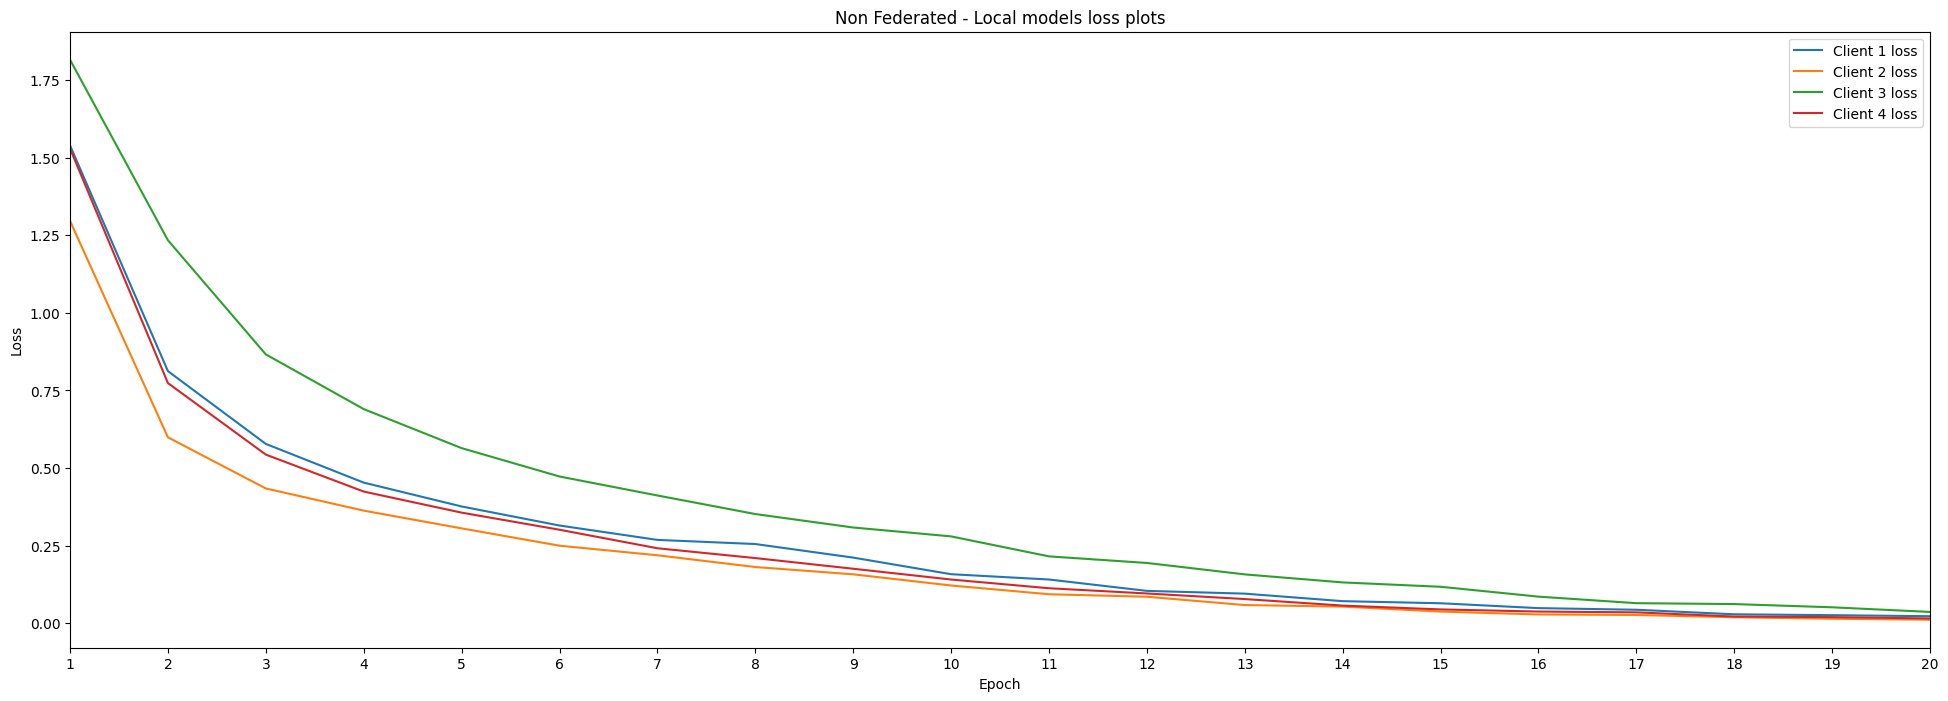

In [67]:
plot_train_loss(client_metrics_noFed, NUM_EPOCHS, title="Non Federated - Local models loss plots")

### 2. Federated local model

In [68]:
# Initialize federated client models
torch.manual_seed(42) # Reminder: we will set a seed for reproducibility
LEARNING_RATE = 1e-4
# Build the server
server = Server(initial_model, local_send_avg=True)

# Build the clients
clients_fed = [
    Client(initial_model, torch.optim.Adam, LEARNING_RATE, nn.CrossEntropyLoss(), train_client_loaders[i], id=i) for i in range(n_clients)
    ]

In [69]:
# Local training on each client
client_metrics_fed = []

# Set the hyperparameters for the epochs and rounds
NUM_EPOCHS = 5
NUM_ROUNDS = 4

# For NUM_ROUNDS we train for  NUM_EPOCHS each round
for round_ in range(NUM_ROUNDS):

  print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)
  print("/"*4,"ROUND "+str(round_),"/"*4)
  print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)

  # Train each client for "n" epochs
  for client in clients_fed:


      metrics = client.train_client(NUM_EPOCHS)

      # We check if we are in the first round (round == 0) or not.
      # If we are not in the first round, we already have the clients previous metrics so
      # we concatenate them with the new metrics.

      if round_ > 0:
        client_metrics_fed[metrics['client_id']]["train_acc"].extend(metrics["train_acc"])
        client_metrics_fed[metrics['client_id']]["train_loss"].extend(metrics["train_loss"])
      else:
        client_metrics_fed.append(metrics)

  # Apply FedAVG on the global model
  if round_ < NUM_ROUNDS-1:

      server.fed_avg(clients_fed)


//// /////// ////
//// ROUND 0 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 18.47it/s]


[0] ==> Epoch 0: train_acc: 0.46178862, train_loss: 1.53676853


train: 100%|██████████| 77/77 [00:04<00:00, 16.14it/s]


[0] ==> Epoch 1: train_acc: 0.74227642, train_loss: 0.78432936


train: 100%|██████████| 77/77 [00:04<00:00, 17.55it/s]


[0] ==> Epoch 2: train_acc: 0.8097561, train_loss: 0.54448138


train: 100%|██████████| 77/77 [00:04<00:00, 18.90it/s]


[0] ==> Epoch 3: train_acc: 0.84593496, train_loss: 0.44338932


train: 100%|██████████| 77/77 [00:05<00:00, 15.12it/s]


[0] ==> Epoch 4: train_acc: 0.86463415, train_loss: 0.37639897


train: 100%|██████████| 116/116 [00:06<00:00, 18.61it/s]


[1] ==> Epoch 0: train_acc: 0.59414793, train_loss: 1.30325923


train: 100%|██████████| 116/116 [00:07<00:00, 15.67it/s]


[1] ==> Epoch 1: train_acc: 0.7835275, train_loss: 0.60858861


train: 100%|██████████| 116/116 [00:06<00:00, 18.98it/s]


[1] ==> Epoch 2: train_acc: 0.83364942, train_loss: 0.45489868


train: 100%|██████████| 116/116 [00:07<00:00, 15.94it/s]


[1] ==> Epoch 3: train_acc: 0.86778651, train_loss: 0.36735622


train: 100%|██████████| 116/116 [00:06<00:00, 18.60it/s]


[1] ==> Epoch 4: train_acc: 0.89569222, train_loss: 0.31121395


train: 100%|██████████| 39/39 [00:02<00:00, 18.81it/s]


[2] ==> Epoch 0: train_acc: 0.38373984, train_loss: 1.81850815


train: 100%|██████████| 39/39 [00:02<00:00, 18.91it/s]


[2] ==> Epoch 1: train_acc: 0.62682927, train_loss: 1.24182706


train: 100%|██████████| 39/39 [00:03<00:00, 11.97it/s]


[2] ==> Epoch 2: train_acc: 0.72682927, train_loss: 0.85622164


train: 100%|██████████| 39/39 [00:04<00:00,  7.95it/s]


[2] ==> Epoch 3: train_acc: 0.77560976, train_loss: 0.66167148


train: 100%|██████████| 39/39 [00:02<00:00, 18.67it/s]


[2] ==> Epoch 4: train_acc: 0.81382114, train_loss: 0.55155533


train: 100%|██████████| 77/77 [00:04<00:00, 16.62it/s]


[3] ==> Epoch 0: train_acc: 0.49918699, train_loss: 1.53433287


train: 100%|██████████| 77/77 [00:04<00:00, 16.57it/s]


[3] ==> Epoch 1: train_acc: 0.76747967, train_loss: 0.77487536


train: 100%|██████████| 77/77 [00:04<00:00, 18.69it/s]


[3] ==> Epoch 2: train_acc: 0.81544715, train_loss: 0.53767646


train: 100%|██████████| 77/77 [00:04<00:00, 15.44it/s]


[3] ==> Epoch 3: train_acc: 0.85528455, train_loss: 0.43063725


train: 100%|██████████| 77/77 [00:05<00:00, 13.51it/s]


[3] ==> Epoch 4: train_acc: 0.87886179, train_loss: 0.35330503
Update clients with averaging
//// /////// ////
//// ROUND 1 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 18.75it/s]


[0] ==> Epoch 0: train_acc: 0.87073171, train_loss: 0.36616378


train: 100%|██████████| 77/77 [00:04<00:00, 17.77it/s]


[0] ==> Epoch 1: train_acc: 0.9004065, train_loss: 0.30382915


train: 100%|██████████| 77/77 [00:05<00:00, 15.31it/s]


[0] ==> Epoch 2: train_acc: 0.91300813, train_loss: 0.26169375


train: 100%|██████████| 77/77 [00:04<00:00, 18.74it/s]


[0] ==> Epoch 3: train_acc: 0.92195122, train_loss: 0.23491099


train: 100%|██████████| 77/77 [00:04<00:00, 18.02it/s]


[0] ==> Epoch 4: train_acc: 0.95121951, train_loss: 0.17980754


train: 100%|██████████| 116/116 [00:06<00:00, 16.62it/s]


[1] ==> Epoch 0: train_acc: 0.88783527, train_loss: 0.31663758


train: 100%|██████████| 116/116 [00:06<00:00, 17.94it/s]


[1] ==> Epoch 1: train_acc: 0.91601192, train_loss: 0.25479315


train: 100%|██████████| 116/116 [00:06<00:00, 16.59it/s]


[1] ==> Epoch 2: train_acc: 0.93091303, train_loss: 0.2138466


train: 100%|██████████| 116/116 [00:06<00:00, 18.30it/s]


[1] ==> Epoch 3: train_acc: 0.94310485, train_loss: 0.18046924


train: 100%|██████████| 116/116 [00:07<00:00, 16.25it/s]


[1] ==> Epoch 4: train_acc: 0.95963154, train_loss: 0.13608354


train: 100%|██████████| 39/39 [00:02<00:00, 18.59it/s]


[2] ==> Epoch 0: train_acc: 0.85691057, train_loss: 0.44757


train: 100%|██████████| 39/39 [00:02<00:00, 18.90it/s]


[2] ==> Epoch 1: train_acc: 0.87317073, train_loss: 0.38570813


train: 100%|██████████| 39/39 [00:02<00:00, 15.98it/s]


[2] ==> Epoch 2: train_acc: 0.89918699, train_loss: 0.31423733


train: 100%|██████████| 39/39 [00:02<00:00, 13.82it/s]


[2] ==> Epoch 3: train_acc: 0.91788618, train_loss: 0.27657865


train: 100%|██████████| 39/39 [00:02<00:00, 19.20it/s]


[2] ==> Epoch 4: train_acc: 0.93089431, train_loss: 0.24002966


train: 100%|██████████| 77/77 [00:04<00:00, 18.93it/s]


[3] ==> Epoch 0: train_acc: 0.89756098, train_loss: 0.3355023


train: 100%|██████████| 77/77 [00:04<00:00, 17.10it/s]


[3] ==> Epoch 1: train_acc: 0.90731707, train_loss: 0.28531879


train: 100%|██████████| 77/77 [00:04<00:00, 15.61it/s]


[3] ==> Epoch 2: train_acc: 0.92073171, train_loss: 0.2429753


train: 100%|██████████| 77/77 [00:04<00:00, 18.62it/s]


[3] ==> Epoch 3: train_acc: 0.93495935, train_loss: 0.20624314


train: 100%|██████████| 77/77 [00:04<00:00, 16.78it/s]


[3] ==> Epoch 4: train_acc: 0.95162602, train_loss: 0.1680298
Update clients with averaging
//// /////// ////
//// ROUND 2 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 15.90it/s]


[0] ==> Epoch 0: train_acc: 0.93699187, train_loss: 0.19405445


train: 100%|██████████| 77/77 [00:04<00:00, 18.74it/s]


[0] ==> Epoch 1: train_acc: 0.95325203, train_loss: 0.15668674


train: 100%|██████████| 77/77 [00:04<00:00, 16.82it/s]


[0] ==> Epoch 2: train_acc: 0.9597561, train_loss: 0.13263331


train: 100%|██████████| 77/77 [00:04<00:00, 15.94it/s]


[0] ==> Epoch 3: train_acc: 0.97398374, train_loss: 0.10645575


train: 100%|██████████| 77/77 [00:04<00:00, 18.93it/s]


[0] ==> Epoch 4: train_acc: 0.98536585, train_loss: 0.08250906


train: 100%|██████████| 116/116 [00:07<00:00, 15.94it/s]


[1] ==> Epoch 0: train_acc: 0.93958277, train_loss: 0.18286857


train: 100%|██████████| 116/116 [00:06<00:00, 18.72it/s]


[1] ==> Epoch 1: train_acc: 0.96017339, train_loss: 0.13874133


train: 100%|██████████| 116/116 [00:07<00:00, 15.73it/s]


[1] ==> Epoch 2: train_acc: 0.96911406, train_loss: 0.10529144


train: 100%|██████████| 116/116 [00:06<00:00, 18.78it/s]


[1] ==> Epoch 3: train_acc: 0.96640477, train_loss: 0.1095372


train: 100%|██████████| 116/116 [00:07<00:00, 15.92it/s]


[1] ==> Epoch 4: train_acc: 0.98997562, train_loss: 0.06395393


train: 100%|██████████| 39/39 [00:02<00:00, 19.05it/s]


[2] ==> Epoch 0: train_acc: 0.93495935, train_loss: 0.22180116


train: 100%|██████████| 39/39 [00:02<00:00, 18.92it/s]


[2] ==> Epoch 1: train_acc: 0.95365854, train_loss: 0.18186336


train: 100%|██████████| 39/39 [00:02<00:00, 18.70it/s]


[2] ==> Epoch 2: train_acc: 0.96504065, train_loss: 0.15094511


train: 100%|██████████| 39/39 [00:02<00:00, 19.07it/s]


[2] ==> Epoch 3: train_acc: 0.9796748, train_loss: 0.11661944


train: 100%|██████████| 39/39 [00:03<00:00, 12.96it/s]


[2] ==> Epoch 4: train_acc: 0.98211382, train_loss: 0.09738875


train: 100%|██████████| 77/77 [00:04<00:00, 17.70it/s]


[3] ==> Epoch 0: train_acc: 0.93577236, train_loss: 0.19572199


train: 100%|██████████| 77/77 [00:04<00:00, 18.30it/s]


[3] ==> Epoch 1: train_acc: 0.96097561, train_loss: 0.1445745


train: 100%|██████████| 77/77 [00:05<00:00, 15.03it/s]


[3] ==> Epoch 2: train_acc: 0.9703252, train_loss: 0.1227636


train: 100%|██████████| 77/77 [00:04<00:00, 17.88it/s]


[3] ==> Epoch 3: train_acc: 0.98170732, train_loss: 0.09264148


train: 100%|██████████| 77/77 [00:04<00:00, 18.72it/s]


[3] ==> Epoch 4: train_acc: 0.98170732, train_loss: 0.08428551
Update clients with averaging
//// /////// ////
//// ROUND 3 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:05<00:00, 14.69it/s]


[0] ==> Epoch 0: train_acc: 0.96788618, train_loss: 0.10977115


train: 100%|██████████| 77/77 [00:04<00:00, 18.76it/s]


[0] ==> Epoch 1: train_acc: 0.98130081, train_loss: 0.0839828


train: 100%|██████████| 77/77 [00:04<00:00, 18.90it/s]


[0] ==> Epoch 2: train_acc: 0.99186992, train_loss: 0.0529355


train: 100%|██████████| 77/77 [00:05<00:00, 14.29it/s]


[0] ==> Epoch 3: train_acc: 0.99186992, train_loss: 0.04897391


train: 100%|██████████| 77/77 [00:04<00:00, 18.68it/s]


[0] ==> Epoch 4: train_acc: 0.99512195, train_loss: 0.03752886


train: 100%|██████████| 116/116 [00:06<00:00, 18.01it/s]


[1] ==> Epoch 0: train_acc: 0.96694663, train_loss: 0.10887132


train: 100%|██████████| 116/116 [00:07<00:00, 16.19it/s]


[1] ==> Epoch 1: train_acc: 0.98293145, train_loss: 0.07433925


train: 100%|██████████| 116/116 [00:06<00:00, 17.98it/s]


[1] ==> Epoch 2: train_acc: 0.98997562, train_loss: 0.05682347


train: 100%|██████████| 116/116 [00:07<00:00, 16.08it/s]


[1] ==> Epoch 3: train_acc: 0.9934977, train_loss: 0.04176067


train: 100%|██████████| 116/116 [00:07<00:00, 16.16it/s]


[1] ==> Epoch 4: train_acc: 0.99756164, train_loss: 0.0277614


train: 100%|██████████| 39/39 [00:03<00:00, 10.95it/s]


[2] ==> Epoch 0: train_acc: 0.97642276, train_loss: 0.10972065


train: 100%|██████████| 39/39 [00:02<00:00, 18.62it/s]


[2] ==> Epoch 1: train_acc: 0.98292683, train_loss: 0.08169599


train: 100%|██████████| 39/39 [00:02<00:00, 19.26it/s]


[2] ==> Epoch 2: train_acc: 0.98943089, train_loss: 0.06451949


train: 100%|██████████| 39/39 [00:02<00:00, 19.12it/s]


[2] ==> Epoch 3: train_acc: 0.99512195, train_loss: 0.04482217


train: 100%|██████████| 39/39 [00:02<00:00, 18.59it/s]


[2] ==> Epoch 4: train_acc: 0.99674797, train_loss: 0.04590978


train: 100%|██████████| 77/77 [00:05<00:00, 14.89it/s]


[3] ==> Epoch 0: train_acc: 0.97195122, train_loss: 0.10761212


train: 100%|██████████| 77/77 [00:04<00:00, 18.75it/s]


[3] ==> Epoch 1: train_acc: 0.9796748, train_loss: 0.08452906


train: 100%|██████████| 77/77 [00:04<00:00, 18.65it/s]


[3] ==> Epoch 2: train_acc: 0.98861789, train_loss: 0.05990398


train: 100%|██████████| 77/77 [00:05<00:00, 14.60it/s]


[3] ==> Epoch 3: train_acc: 0.99146341, train_loss: 0.051433


train: 100%|██████████| 77/77 [00:04<00:00, 18.48it/s]

[3] ==> Epoch 4: train_acc: 0.99552846, train_loss: 0.03378064


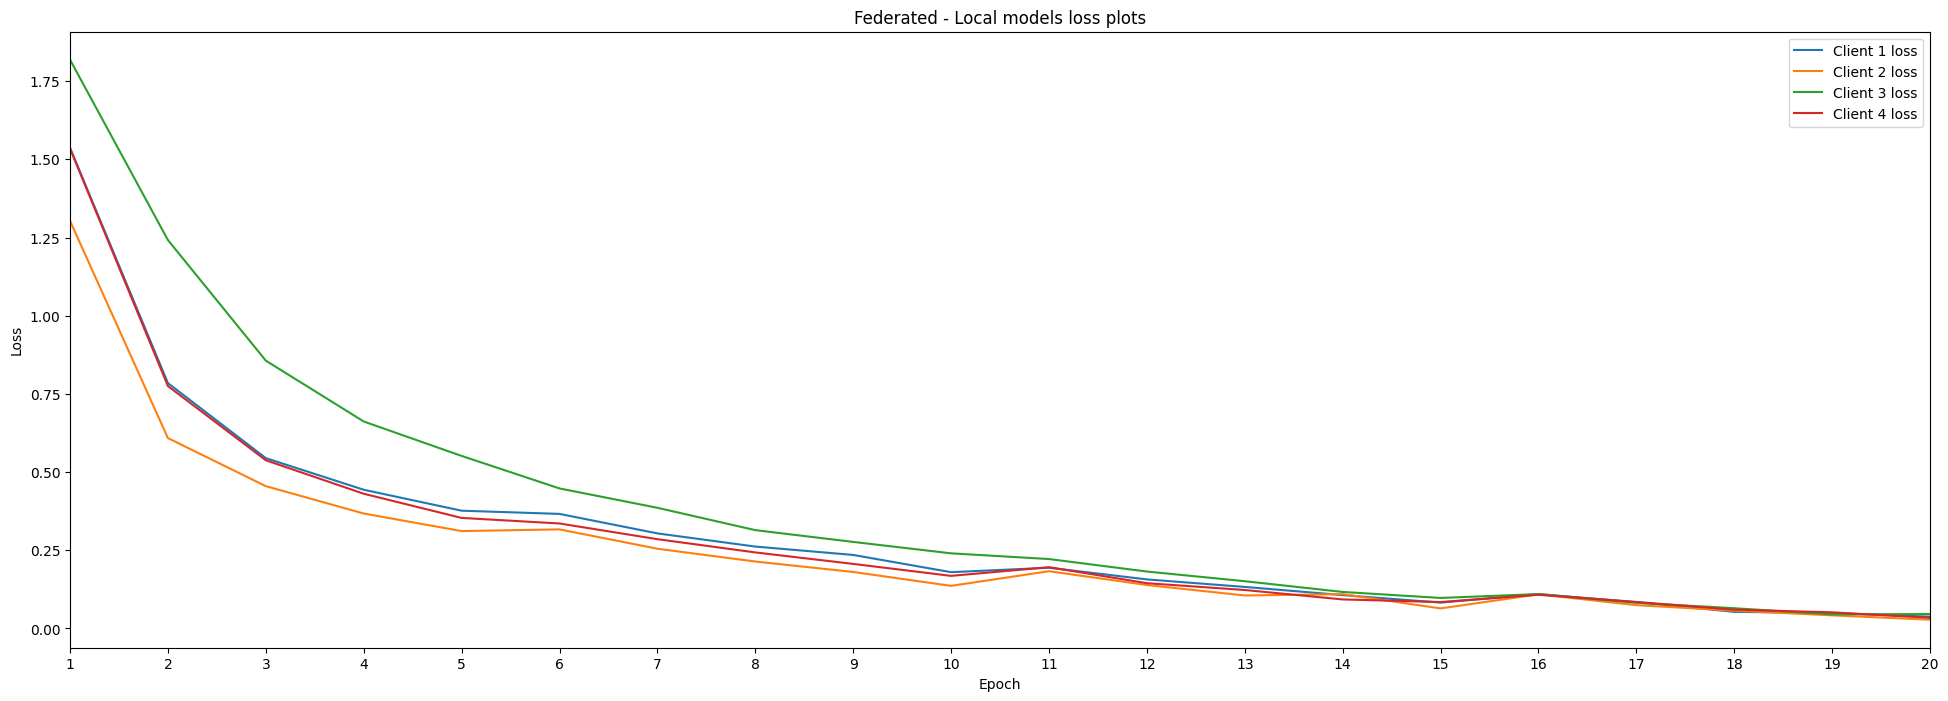

In [70]:
plot_train_loss(client_metrics_fed, NUM_EPOCHS * NUM_ROUNDS, title="Federated - Local models loss plots")

**Question 2**:

Based on the IID training loss plots and the non-IID training loss plots (for federated and non-federated local models) can you spot any difference?

## IV. Evaluation on the global test / local test

In [71]:
acc_metrics = []
balanced_acc_metrics = []
sensitivity_metrics = []
specificity_metrics = []
auc_metrics = []
ece_metrics = []


# Iterate on the clients
for i, client_noFed, client_fed in zip(range(n_clients), clients_noFed, clients_fed):
  print(f"Client {i+1}")

  # We pass the local test sets
  metric_nofed = validate_model(client_noFed.model, test_client_loaders[i])
  metric_fed = validate_model(client_fed.model, test_client_loaders[i])

  # We pass the global set
  metric_glob_nofed = validate_model(client_noFed.model, global_test_loader)
  metric_glob_fed = validate_model(client_fed.model, global_test_loader)

  acc_metrics.append({
      "client_id": f"Client_{i+1}",
      "acc_noFed": metric_nofed['val_acc'],
      "acc_Fed": metric_fed['val_acc'],
      "acc_global_noFed": metric_glob_nofed['val_acc'],
      "acc_global_Fed": metric_glob_fed['val_acc'],
  })

  ece_metrics.append({
      "client_id": f"Client_{i+1}",
      "ece_noFed": metric_nofed['val_ece'],
      "ece_Fed": metric_fed['val_ece'],
      "ece_global_noFed": metric_glob_nofed['val_ece'],
      "ece_global_Fed": metric_glob_fed['val_ece'],
  })

  balanced_acc_metrics.append({
      "client_id": f"Client_{i+1}",
      "b_acc_noFed": metric_nofed['val_balanced_acc'],
      "b_acc_Fed": metric_fed['val_balanced_acc'],
      "b_acc_global_noFed": metric_glob_nofed['val_balanced_acc'],
      "b_acc_global_Fed": metric_glob_fed['val_balanced_acc'],
  })

  sensitivity_metrics.append({
      "client_id": f"Client_{i+1}",
      "sensitivity_noFed": metric_nofed['val_sensitivity'],
      "sensitivity_Fed": metric_fed['val_sensitivity'],
      "sensitivity_global_noFed": metric_glob_nofed['val_sensitivity'],
      "sensitivity_global_Fed": metric_glob_fed['val_sensitivity'],
  })

  specificity_metrics.append({
      "client_id": f"Client_{i+1}",
      "specificity_noFed": metric_nofed['val_specificity'],
      "specificity_Fed": metric_fed['val_specificity'],
      "specificity_global_noFed": metric_glob_nofed['val_specificity'],
      "specificity_global_Fed": metric_glob_fed['val_specificity'],
  })

  auc_metrics.append({
      "client_id": f"Client_{i+1}",
      "AUC_noFed": metric_nofed['val_auc'],
      "AUC_Fed": metric_fed['val_auc'],
      "AUC_global_noFed": metric_glob_nofed['val_auc'],
      "AUC_global_Fed": metric_glob_fed['val_auc'],
  })

Client 1
Client 2
Client 3
Client 4


In [72]:
# Let's calculate the average for each metric
# and add them to their respective metric list

acc_metrics.append({
    "client_id": f"Average",
    "acc_noFed": np.round(np.mean([m['acc_noFed'] for m in acc_metrics]), 8),
    "acc_Fed": np.round(np.mean([m['acc_Fed'] for m in acc_metrics]), 8),
    "acc_global_noFed": np.round(np.mean([m['acc_global_noFed'] for m in acc_metrics]), 8),
    "acc_global_Fed": np.round(np.mean([m['acc_global_Fed'] for m in acc_metrics]), 8),
})

balanced_acc_metrics.append({
    "client_id": f"Average",
    "b_acc_noFed": np.round(np.mean([m['b_acc_noFed'] for m in balanced_acc_metrics]), 8),
    "b_acc_Fed": np.round(np.mean([m['b_acc_Fed'] for m in balanced_acc_metrics]), 8),
    "b_acc_global_noFed": np.round(np.mean([m['b_acc_global_noFed'] for m in balanced_acc_metrics]), 8),
    "b_acc_global_Fed": np.round(np.mean([m['b_acc_global_Fed'] for m in balanced_acc_metrics]), 8),
})

sensitivity_metrics.append({
    "client_id": f"Average",
    "sensitivity_noFed": np.round(np.mean([m['sensitivity_noFed'] for m in sensitivity_metrics]), 8),
    "sensitivity_Fed": np.round(np.mean([m['sensitivity_Fed'] for m in sensitivity_metrics]), 8),
    "sensitivity_global_noFed": np.round(np.mean([m['sensitivity_global_noFed'] for m in sensitivity_metrics]), 8),
    "sensitivity_global_Fed": np.round(np.mean([m['sensitivity_global_Fed'] for m in sensitivity_metrics]), 8),
})

specificity_metrics.append({
    "client_id": f"Average",
    "specificity_noFed": np.round(np.mean([m['specificity_noFed'] for m in specificity_metrics]), 8),
    "specificity_Fed": np.round(np.mean([m['specificity_Fed'] for m in specificity_metrics]), 8),
    "specificity_global_noFed": np.round(np.mean([m['specificity_global_noFed'] for m in specificity_metrics]), 8),
    "specificity_global_Fed": np.round(np.mean([m['specificity_global_Fed'] for m in specificity_metrics]), 8),
})

auc_metrics.append({
    "client_id": f"Average",
    "AUC_noFed": np.round(np.mean([m['AUC_noFed'] for m in auc_metrics]), 3),
    "AUC_Fed": np.round(np.mean([m['AUC_Fed'] for m in auc_metrics]), 3),
    "AUC_global_noFed": np.round(np.mean([m['AUC_global_noFed'] for m in auc_metrics]), 3),
    "AUC_global_Fed": np.round(np.mean([m['AUC_global_Fed'] for m in auc_metrics]), 3),
})

ece_metrics.append({
    "client_id": f"Average",
    "ece_noFed": np.round(np.mean([m['ece_noFed'] for m in ece_metrics]), 8),
    "ece_Fed": np.round(np.mean([m['ece_Fed'] for m in ece_metrics]), 8),
    "ece_global_noFed": np.round(np.mean([m['ece_global_noFed'] for m in ece_metrics]), 8),
    "ece_global_Fed": np.round(np.mean([m['ece_global_Fed'] for m in ece_metrics]), 8),
})


In [73]:
# Set up the styles for each metric
acc_style={
    "acc_noFed": ("#008dda", None),
    "acc_Fed": ("#ace2e1", "///"),
    "acc_global_noFed": ("#ffcf81", None),
    "acc_global_Fed": ("#f7eedd", "///"),
}

b_acc_style={
    "b_acc_noFed": ("#008dda", None),
    "b_acc_Fed": ("#ace2e1", "///"),
    "b_acc_global_noFed": ("#ffcf81", None),
    "b_acc_global_Fed": ("#f7eedd", "///"),
}

sensitivity_style={
    "sensitivity_noFed": ("#008dda", None),
    "sensitivity_Fed": ("#ace2e1", "///"),
    "sensitivity_global_noFed": ("#ffcf81", None),
    "sensitivity_global_Fed": ("#f7eedd", "///"),
}

specificity_style={
    "specificity_noFed": ("#008dda", None),
    "specificity_Fed": ("#ace2e1", "///"),
    "specificity_global_noFed": ("#ffcf81", None),
    "specificity_global_Fed": ("#f7eedd", "///"),
}

auc_style={
    "AUC_noFed": ("#008dda", None),
    "AUC_Fed": ("#ace2e1", "///"),
    "AUC_global_noFed": ("#ffcf81", None),
    "AUC_global_Fed": ("#f7eedd", "///"),
}

ece_style={
    "ece_noFed": ("#008dda", None),
    "ece_Fed": ("#ace2e1", "///"),
    "ece_global_noFed": ("#ffcf81", None),
    "ece_global_Fed": ("#f7eedd", "///"),
}

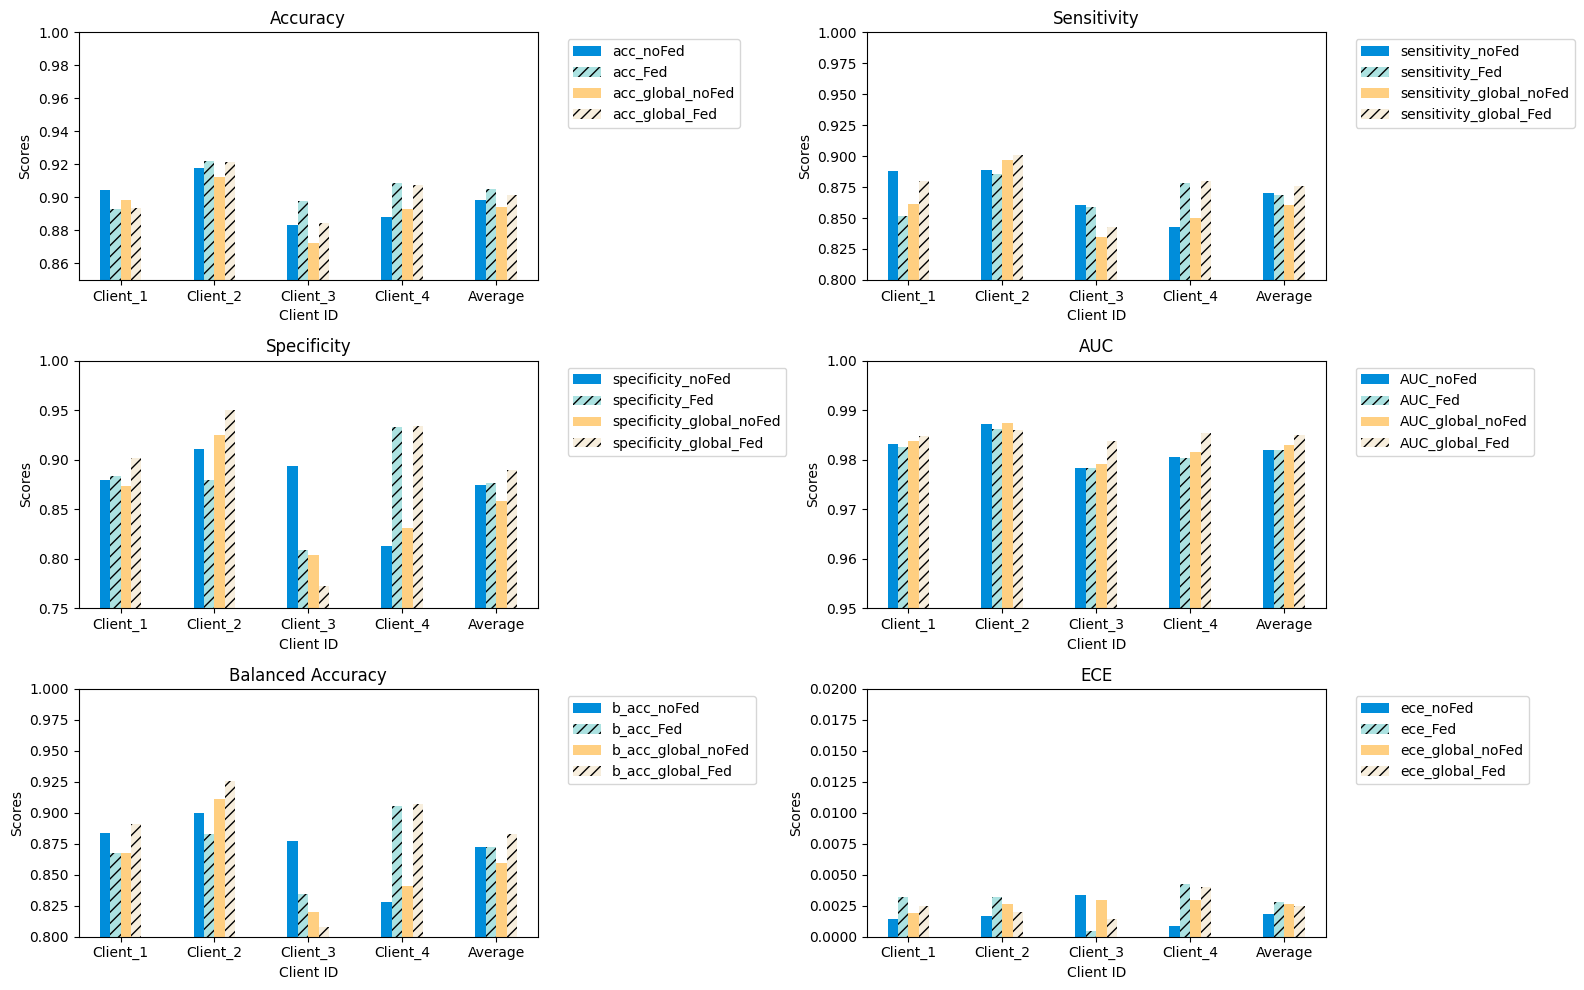

In [75]:
fig, ax = plt.subplots(3, 2, figsize=(16, 10))

# Plot Accuracy
plot_acc_sens_spec(acc_metrics, ax[0][0], title="Accuracy", limit=(0.85, 1), style=acc_style)

# Plot sensitivity
plot_acc_sens_spec(sensitivity_metrics, ax[0][1], title="Sensitivity", limit=(0.8, 1), style=sensitivity_style)

# Plot specificity
plot_acc_sens_spec(specificity_metrics, ax[1][0], title="Specificity", limit=(0.75, 1), style=specificity_style)

# Plot AUC
plot_acc_sens_spec(auc_metrics, ax[1][1], title="AUC", limit=(0.95, 1), style=auc_style)

# Plot balanced accuracy
plot_acc_sens_spec(balanced_acc_metrics, ax[2][0], title="Balanced Accuracy", limit=(0.8, 1), style=b_acc_style)

# Plot Expected Calibration Error
plot_acc_sens_spec(ece_metrics, ax[2][1], title="ECE", limit=(0.0, 0.02), style=ece_style)

fig.tight_layout()
plt.show()

**Question 3**:

What does these barplots tell you?

In contrast to previous results for the *IID* dataset, The results for the *non-IID* dataset are **lower** than what they used to be especially in the federated models. These results are due to the FedAvg not being robust to **skewed** data distribution wich tends to **diverge** from the averaged weights distribution of the global model. This problem is called [**the weight divergence problem**](https://arxiv.org/abs/1806.00582).

# Part 3. 💡 Heterogenous Federated Learning

## I. Define the heterogenous aggregation parent class

In this section we will:
* Redefine the `Server` class.
* Build the parent `AggregationStrategy` class.

In [76]:
class Server:
    """
    A class representing a central server.

    Attributes:
    - device: The device on which the server's global model will be loaded (CPU or CUDA).
    - global_model: The global model maintained by the server.
    - local_send_avg: Mimicking if we are sending the weights from server to client with averaging or without.
    """

    def __init__(self, initial_model):
      """
      Parameters:
      - initial_model: the intial model.
      - local_send_avg: Mimicking if we are sending the weights from server to client with averaging or without.
      """
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.global_model = copy.deepcopy(initial_model.to(self.device))



    def set_server_params(self, params):
      """
      This function updates the server model parameters with the model parameters.

      Parameters:
      - params: The new parameters to update the server model with.
      """

      self.global_model.load_state_dict(params)

    def get_server_params(self):
      """
      This function returns the server model parameters.

      Returns:
      - The server model parameters.
      """
      return self.global_model.state_dict()

In [77]:
@dataclass
class AggregationStrategy:
    """
    This abstract class has methods and attributes that are meant to be inherited
    to facilitate the implementation of different aggregation methods.

    Attributes:
    - strategy_title (str): The title of the aggregation strategy.
    - clients (list[Client]): A list of clients.
    - server (Server): The server.

    Methods:
      - train: Train function for all the clients.
      - train_client: Train function for a single client.
      - aggregate: The server aggregation function to update its parameters.
      - update: The clients parameters update function
    """
    strategy_title: str
    clients: list[Client] = field(default_factory=list)
    server: Server = None


    def train(self, nbre_epochs:int, nbre_rounds:int) -> dict:
        """
        Training all clients on a number of epochs for a number of rounds.

        Parameters:
        - nbre_epochs (int): The number of epochs to train the clients.
        - nbre_rounds (int): The number of rounds to train the clients.

        Returns:
        - dict: A dictionnairy
        """
        return {}


    def aggregate(self):
        """
        The server aggregation function to update its parameters.
        """
        pass


    def update(self):
        """
        The clients parameters update function
        """
        pass


## II. Define the aggregation algorithm child class

In this section we will:
* Define the children strategies `FedAvg`, `FedProx`, etc inheriting from the parent strategie `AggregationStrategy`.
* Define the children clients classes inheriting from the parent `Client` class ( if needed ).


### 1. Federated Average (FedAvg)

Quick reminder, the equation for **FedAvg** [3] is the following:

 $$w^{t+1} = \dfrac{1}{n}\sum_{k=1}^{K} w_{k}^{t+1}$$

Each term represents:
* $w^{t+1}$: Updated global model parameters after round $t$.
* $n$: Total number of clients.
* $w_{k}^{t+1}$: Updated model parameters from client $k$ after local training.

For more details, look at section 3 in part 1.

In [78]:
# Define the class FedAvg that inherits from AggregationStrategy

class FedAvg(AggregationStrategy):
    """
    This class implements the FedAvg aggregation strategy.

    Attributes:
    - strategy_title (str): The title of the aggregation strategy.
    - clients (list[Client]): A list of clients.
    - server (Server): The server.
    """

    def __init__(self, strategy_title, list_clients, server, local_avg=False):
        """
        Parameters:
        - strategy_title (str): The title of the aggregation strategy.
        - list_clients (list[Client]): A list of clients.
        - server (Server): The server.
        - local_avg: Mimicking if we are sending the weights from server to client with averaging or without.
          Default: False.
        """
        self.strategy_title = strategy_title
        self.clients = copy.deepcopy(list_clients)
        self.server = copy.deepcopy(server)
        self.local_avg = local_avg

    def aggregate(self):
        """
        This function will first implement aggregate the weights from the clients and then average them.

        Parameters:
        - clients: A list of clients.
        """

        ##Let's a copy of the state_dict of the global_model
        global_dict = self.server.get_server_params().copy()

        ## For each layer in the model architecture

        ## We iterate for each layer in the model architecture
        for k in global_dict.keys():

            ## Aggregate the clients weights of the selected layer. And the averaging using the 'mean' function in PyTorch
            global_dict[k] = torch.stack([self.clients[i].get_model_params()[k] for i in range(len(self.clients))], 0).float().mean(0)

        ## Update the server model weights
        self.server.set_server_params(global_dict)

    def update(self):
        """
        This function updates the local clients weights.
        """

        if self.local_avg:

          # Update the clients
          print("Update clients with averaging")

          self.update_with_local_avg()
        else:

          # Update the clients
          print("Update clients without averaging")

          self.update_without_local_avg()



    def train(self, nbre_epochs:int, nbre_rounds:int) -> dict:
        """
        Training all clients on a number of epochs for a number of rounds.

        Parameters:
        - nbre_epochs (int): The number of epochs to train the clients.
        - nbre_rounds (int): The number of rounds to train the clients.

        Returns:
        - dict: A dictionnairy
        """

        client_metrics = []

        # For each round
        for round_ in range(nbre_rounds):

            print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)
            print("/"*4,"ROUND "+str(round_),"/"*4)
            print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)

            # Train each client for "n" epochs
            for client in self.clients:

                metrics = client.train_client(nbre_epochs)

                # We check if we are in the first round (round 0) or not
                # if not we already have the clients previous round metrics so
                # we concatenate the new metrics.

                if round_ > 0:
                  client_metrics[metrics['client_id']]["train_acc"].extend(metrics["train_acc"])
                  client_metrics[metrics['client_id']]["train_loss"].extend(metrics["train_loss"])
                else:
                  client_metrics.append(metrics)

            # Apply FedAVG on the global model
            if round_ < nbre_rounds-1:

                # First we aggregate the clients
                self.aggregate()

                # Second we update the clients weights
                self.update()

        return client_metrics

    def update_without_local_avg(self):
      """
      This function updates the local clients weights by updation them with the server model weights.

      Parameters:
      - clients: A list of the clients we will update their models.
      """

      # Let's copy the state_dict of the global_model
      server_dict = self.server.get_server_params().copy()

      # For each client we have
      for client in self.clients:

        # We update the client weights with the server weights
        client.set_model_params(server_dict)



    def update_with_local_avg(self):
      """
      This function updates the local clients weights by summing the current client weights
      with the server model weights and then averaging them.

      Parameters:
      - clients: A list of the clients we will update their models.
      """

      # Let's copy the state_dict of the global_model
      client_dict = self.server.get_server_params().copy()

      # For each client we have
      for client in self.clients:

        # Then for each layer in the model represented by a key 'k'
        for k in client_dict.keys():

          # We apply the averaging rule by summing the global_model weights
          # and the client_model weights for that layer 'k' and then average them
          client_dict[k] = (self.server.get_server_params()[k] + client.get_model_params()[k])/2

        # We update the client weights
        client.set_model_params(client_dict)

### 2. Federated Optimization (FedProx)

**FedProx** [4] is similar to **FedAvg** in that a subset of devices are selected at each round, trained on a local training set for local updates, and these updates are then aggregated and averaged to form a global update which is the passed to the clients.

However **FedProx** is designed to handle heterogeneity in federated learning environments. FedProx introduces a proximal term in the loss function to stabilize the training process when client data distributions are non-iid (not independently and identically distributed).

The general loss (proximal update) function for a client $k$ in FedProx can be written as:

$$L_{k}(w) = f_{k}(w) + \dfrac{μ}{2} || w - w_{t} ||^2$$

Where:
* $f_{k}(w)$ is the original loss function for client $k$.
* $w$ is the model parameter.
* $w_{t}$ is the global model parameter at iteration $t$.
* $\mu$ is a non-negative regularization parameter that controls the impact of the proximal term.

The $\dfrac{μ}{2} || w - w_{t} ||^2$ part of the equation is called the **proximal term**. It ensures that the local model does not drift too far from the global model $w_{t}$ ([Paper link](https://arxiv.org/abs/1812.06127)).

In [79]:
class Client_FedProx(Client):


  def __init__(self, model, optimizer, lr, criterion, train_loader, id, mu=0.01):
    """
        Parameters:
        - mu: non-negative regularization parameter that controls the impact of the proximal term.
          Default is 0.01.
    """

    super().__init__(model, optimizer, lr, criterion, train_loader, id)
    self.mu = mu

  def train_client(self, nbre_epochs):
      """
        This function handles the training of the client model. You just have to provide the number
        of epochs to run for and at the end it will return a report in a dictionnary format that containes
        items like the client id ( to specify who's model we trained ), the training accuracy and
        the training loss.

        Parameters:
        - nbre_epochs: Number of epochs to run the training for.
        - mu: non-negative regularization parameter that controls the impact of the proximal term.
          Default is 0.01.

        Returns:
        - dict: A dictionnairy that has the client id, the training accuracy, and the training loss

      """

      global_model = copy.deepcopy(self.model)
      for param in global_model.parameters():
        param.requires_grad = False

      self.model.train() # set the model to train

      train_acc = []
      train_loss = []

      for epoch in range(nbre_epochs):
        losses = []
        correct = 0
        total = 0
        for inputs, targets in tqdm(self.data, desc="train"):

          self.optimizer.zero_grad()

          # Forward pass
          outputs = self.model(inputs.to(self.device))
          targets = targets.long().to(self.device)

          # PyTorch cross entropy loss automatically applies softmax
          # hence why we don't need to explicit it
          loss = self.criterion(outputs, targets)

          # Backward pass and optimization
          prox = 0.

          # For each layer in the model
          for name, param in self.model.named_parameters():

              # We walculate the norm of the updated model and the global model (previous).
              # Then we multiply the proximal term with mu*0.5
              # Then we add i to the loss
              # TODO: Implement the equation that calculates the proxima term
              
              prox += (param - global_model.get_parameter(name)).norm()**2

              loss += self.mu * (0.5 * prox)

          for param in self.model.parameters():
              param.grad = None

          loss.backward()
          self.optimizer.step()

          losses.append(loss.item())
          total += targets.shape[0]
          correct += torch.sum(outputs.max(1)[1] == targets).item()

        # Calculate the accuracy after one epoch
        # and append it with the average of the losses the the train_acc list
        # and train_loss list.
        train_acc.append(np.round(correct / total, 8))
        train_loss.append(np.round(np.mean(losses), 8))

        print(f'[{self.id}] ==> Epoch {epoch}: train_acc: {np.round(correct / total, 8)}, train_loss: {np.round(np.mean(losses), 8)}')
      return {
            'client_id': self.id,
            'train_acc': train_acc,
            'train_loss': train_loss
        }

In [80]:
# Since FedProx is an extension of FedAvg, we inherit the already FedAvg class
class FedProx(FedAvg):
    def __init__(self, strategy_title, list_clients, server, local_avg=False):
        super().__init__(strategy_title, list_clients, server, local_avg)

### 3. Federated Adaptive Local Aggregation (FedALA)

**FedALA** (Federated Adaptive Learning Algorithm) is a framework designed to improve federated learning by adaptively adjusting the contribution of clients based on their importance [5]. The core idea is to weigh the updates from different clients according to their quality and significance.

The general equation for FedALA can be described as follows:

$$\hat{w_{i}}^{t} = w_{i}^{t-1} + (w^{t-1} - w_{i}^{t-1})*α_{i}$$

In [94]:
class ALA:
    def __init__(self, cid: int,
                loss: nn.Module,
                train_data: TransformDataset,
                batch_size: int,
                rand_percent: int,
                layer_idx: int = 0,
                eta: float = 1.0,
                threshold: float = 0.1,
                num_pre_loss: int = 10) -> None:
        """
        Initialize ALA module

        Args:
            cid: Client ID.
            loss: The loss function.
            train_data: The reference of the local training data.
            batch_size: Weight learning batch size.
            rand_percent: The percent of the local training data to sample.
            layer_idx: Control the weight range. By default, all the layers are selected. Default: 0
            eta: Weight learning rate. Default: 1.0
            threshold: Train the weight until the standard deviation of the recorded losses is less than a given threshold. Default: 0.1
            num_pre_loss: The number of the recorded losses to be considered to calculate the standard deviation. Default: 10
            lr_weights: Learning rate for the weights. Default: 0

        Returns:
            None.
        """

        self.cid = cid
        self.loss = loss
        self.train_data = train_data
        self.batch_size = batch_size
        self.rand_percent = rand_percent
        self.layer_idx = layer_idx
        self.eta = eta
        self.threshold = threshold
        self.num_pre_loss = num_pre_loss
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.weights = None # Learnable local aggregation weights.
        self.start_phase = True


    def adaptive_local_aggregation(self,
                            global_model: nn.Module,
                            local_model: nn.Module) -> None:
        """
        Generates the Dataloader for the randomly sampled local training data and
        preserves the lower layers of the update.

        Args:
            global_model: The received global/aggregated model.
            local_model: The trained local model.

        Returns:
            None.
        """

        # randomly sample partial local training data
        rand_ratio = self.rand_percent / 100
        rand_num = int(rand_ratio*len(self.train_data))
        rand_idx = random.randint(0, self.train_data.__len__()-rand_num)
        data = TransformDataset(Subset(self.train_data, list(range(rand_idx,rand_idx+rand_num))))
        rand_loader = DataLoader(data, self.batch_size, drop_last=False)


        # obtain the references of the parameters
        params_g = list(global_model.parameters())
        params = list(local_model.parameters())

        # deactivate ALA at the 1st communication iteration
        if torch.sum(params_g[0] - params[0]) == 0:
            return

        # preserve all the updates in the lower layers
        for param, param_g in zip(params[:-self.layer_idx], params_g[:-self.layer_idx]):
            param.data = param_g.data.clone()


        # temp local model only for weight learning
        model_t = copy.deepcopy(local_model)
        params_t = list(model_t.parameters())

        # only consider higher layers
        params_p = params[-self.layer_idx:]
        params_gp = params_g[-self.layer_idx:]
        params_tp = params_t[-self.layer_idx:]

        # frozen the lower layers to reduce computational cost in Pytorch
        for param in params_t[:-self.layer_idx]:
            param.requires_grad = False

        # used to obtain the gradient of higher layers

        optimizer = torch.optim.Adam(params_tp, lr=0.0)

        # initialize the weight to all ones in the beginning
        if self.weights == None:
            self.weights = [torch.ones_like(param.data).to(self.device) for param in params_p]

        # initialize the higher layers in the temp local model
        for param_t, param, param_g, weight in zip(params_tp, params_p, params_gp,
                                                self.weights):
            param_t.data = param + (param_g - param) * weight

        # weight learning
        losses = []  # record losses
        cnt = 0  # weight training iteration counter
        while True:
            for x, y in rand_loader:
                if type(x) == type([]):
                    x[0] = x[0].to(self.device)
                else:
                    x = x.to(self.device)
                y = y.to(self.device)
                optimizer.zero_grad()
                output = model_t(x)
                loss_value = self.loss(output, y) # modify according to the local objective
                loss_value.backward()

                # update weight in this batch
                for param_t, param, param_g, weight in zip(params_tp, params_p,
                                                        params_gp, self.weights):
                    weight.data = torch.clamp(
                        weight - self.eta * (param_t.grad * (param_g - param)), 0, 1)

                # update temp local model in this batch
                for param_t, param, param_g, weight in zip(params_tp, params_p,
                                                        params_gp, self.weights):
                    param_t.data = param + (param_g - param) * weight

            # optimizer.step()
            losses.append(loss_value.item())
            cnt += 1

            # only train one epoch in the subsequent iterations
            if not self.start_phase:
                break

            # train the weight until convergence
            if len(losses) > self.num_pre_loss and np.std(losses[-self.num_pre_loss:]) < self.threshold:
                print('Client:', self.cid, '\tStd:', np.std(losses[-self.num_pre_loss:]),
                    '\tALA epochs:', cnt)
                break

        self.start_phase = False

        # obtain initialized local model
        for param, param_t in zip(params_p, params_tp):
            param.data = param_t.data.clone()

In [95]:
class Client_FedALA(Client):


  def __init__(self, model, optimizer, lr, criterion, train_loader, train_data, id, rand_percent, batch_size, layer_idx=5, threshold=0.1, eta=1.0):
    """
        Parameters:
        - threshold: Train the weight until the standard deviation of the recorded
        losses is less than a given threshold. Default: 0.1.
        - eta: Weight learning rate. Default: 1.0
    """
    super().__init__(model, optimizer, lr, criterion, train_loader, id)
    self.threshold = threshold

    self.ALA = ALA(self.id, self.criterion, train_data, batch_size,
                    rand_percent, layer_idx, eta)

  def train_client(self, nbre_epochs, params_global):
      """
        This function handles the training of the client model. You just have to provide the number
        of epochs to run for and at the end it will return a report in a dictionnary format that containes
        items like the client id ( to specify who's model we trained ), the training accuracy and
        the training loss.

        Parameters:
        - nbre_epochs: Number of epochs to run the training for.

        Returns:
        - dict: A dictionnairy that has the client id, the training accuracy, and the training loss

      """

      self.model.train() # set the model to train

      train_acc = []
      train_loss = []

      for epoch in range(nbre_epochs):
        losses = []
        correct = 0
        total = 0
        for inputs, targets in tqdm(self.data, desc="train"):

          self.optimizer.zero_grad()

          # Forward pass
          outputs = self.model(inputs.to(self.device))
          targets = targets.long().to(self.device)

          # PyTorch cross entropy loss automatically applies softmax
          # hence why we don't need to explicit it
          loss = self.criterion(outputs, targets)

          # Backward pass and optimization
          loss.backward()
          self.optimizer.step()

          losses.append(loss.item())
          total += targets.shape[0]
          correct += torch.sum(outputs.max(1)[1] == targets).item()

        # Calculate the accuracy after one epoch
        # and append it with the average of the losses the the train_acc list
        # and train_loss list.
        train_acc.append(np.round(correct / total, 8))
        train_loss.append(np.round(np.mean(losses), 8))

        print(f'[{self.id}] ==> Epoch {epoch}: train_acc: {np.round(correct / total, 8)}, train_loss: {np.round(np.mean(losses), 8)}')
      return {
            'client_id': self.id,
            'train_acc': train_acc,
            'train_loss': train_loss
        }


  def local_initialization(self, received_global_model):
        self.ALA.adaptive_local_aggregation(received_global_model, self.model)




In [96]:
class FedALA(FedAvg):
    def __init__(self, strategy_title, list_clients, server, local_avg=False):
        super().__init__(strategy_title, list_clients, server, local_avg)

    def train(self, nbre_epochs:int, nbre_rounds:int) -> dict:
        """
        Training all clients on a number of epochs for a number of rounds.

        Parameters:
        - nbre_epochs (int): The number of epochs to train the clients.
        - nbre_rounds (int): The number of rounds to train the clients.

        Returns:
        - dict: A dictionnairy
        """

        client_metrics = []

        ## For each round
        for round_ in range(nbre_rounds):

            self.send_models()

            print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)
            print("/"*4,"ROUND "+str(round_),"/"*4)
            print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)

            ## Train each client for "n" epochs
            for client in self.clients:
                # obtain the references of the parameters
                params_g = list(server.global_model.parameters())


                # We train our client
                metrics = client.train_client(nbre_epochs, params_g)

                # We check if we are in the first round (round 0) or not
                # if not we already have the clients previous round metrics so
                # we concatenate the new metrics.

                if round_ > 0:
                  client_metrics[metrics['client_id']]["train_acc"].extend(metrics["train_acc"])
                  client_metrics[metrics['client_id']]["train_loss"].extend(metrics["train_loss"])
                else:
                  client_metrics.append(metrics)

            ##Apply FedAVG on the global model
            if round_ < nbre_rounds-1:

                # First we aggragate the clients
                self.aggregate()

                # Second we update the clients weights
                self.update()

        return client_metrics



    def send_models(self):
        assert (len(self.clients) > 0)

        for client in self.clients:
            client.local_initialization(self.server.global_model)


## III. Build and train clients

In [84]:
# Let's first initialize our initial model model (since we will be using it a lot).
torch.manual_seed(42)
initial_model = Net(in_channels=ds_info['n_channels'], num_classes=len(ds_info['label']))

# Build the server
server = Server(initial_model)

# Build the clients
n_clients = 4
LEARNING_RATE = 1e-4
clients = [
    Client(initial_model, torch.optim.Adam, LEARNING_RATE, nn.CrossEntropyLoss(), train_client_loaders[i], id=i) for i in range(n_clients)
    ]

### 1. FedAvg

In [85]:
# Build the FedAvg aggregation strategy
strategy_fedavg = FedAvg("FedAvg", clients, server, local_avg=False)

In [86]:
m_fedavg = strategy_fedavg.train(nbre_epochs=5, nbre_rounds=4)

//// /////// ////
//// ROUND 0 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 18.23it/s]


[0] ==> Epoch 0: train_acc: 0.47764228, train_loss: 1.53966242


train: 100%|██████████| 77/77 [00:05<00:00, 14.68it/s]


[0] ==> Epoch 1: train_acc: 0.7199187, train_loss: 0.81215463


train: 100%|██████████| 77/77 [00:04<00:00, 18.15it/s]


[0] ==> Epoch 2: train_acc: 0.80528455, train_loss: 0.57755189


train: 100%|██████████| 77/77 [00:04<00:00, 18.73it/s]


[0] ==> Epoch 3: train_acc: 0.84065041, train_loss: 0.45275987


train: 100%|██████████| 77/77 [00:05<00:00, 14.80it/s]


[0] ==> Epoch 4: train_acc: 0.87073171, train_loss: 0.37588702


train: 100%|██████████| 116/116 [00:06<00:00, 18.78it/s]


[1] ==> Epoch 0: train_acc: 0.56651314, train_loss: 1.30996976


train: 100%|██████████| 116/116 [00:07<00:00, 15.96it/s]


[1] ==> Epoch 1: train_acc: 0.79030073, train_loss: 0.62171076


train: 100%|██████████| 116/116 [00:06<00:00, 18.51it/s]


[1] ==> Epoch 2: train_acc: 0.83012734, train_loss: 0.46521921


train: 100%|██████████| 116/116 [00:07<00:00, 15.96it/s]


[1] ==> Epoch 3: train_acc: 0.86914115, train_loss: 0.37207857


train: 100%|██████████| 116/116 [00:06<00:00, 18.57it/s]


[1] ==> Epoch 4: train_acc: 0.89948523, train_loss: 0.31078917


train: 100%|██████████| 39/39 [00:02<00:00, 18.73it/s]


[2] ==> Epoch 0: train_acc: 0.39674797, train_loss: 1.80341212


train: 100%|██████████| 39/39 [00:02<00:00, 13.22it/s]


[2] ==> Epoch 1: train_acc: 0.63414634, train_loss: 1.22286691


train: 100%|██████████| 39/39 [00:02<00:00, 16.12it/s]


[2] ==> Epoch 2: train_acc: 0.71707317, train_loss: 0.85796356


train: 100%|██████████| 39/39 [00:02<00:00, 19.09it/s]


[2] ==> Epoch 3: train_acc: 0.77154472, train_loss: 0.67151657


train: 100%|██████████| 39/39 [00:02<00:00, 18.77it/s]


[2] ==> Epoch 4: train_acc: 0.82276423, train_loss: 0.53253081


train: 100%|██████████| 77/77 [00:04<00:00, 18.58it/s]


[3] ==> Epoch 0: train_acc: 0.5, train_loss: 1.51755972


train: 100%|██████████| 77/77 [00:05<00:00, 14.29it/s]


[3] ==> Epoch 1: train_acc: 0.76300813, train_loss: 0.77040854


train: 100%|██████████| 77/77 [00:04<00:00, 16.82it/s]


[3] ==> Epoch 2: train_acc: 0.81910569, train_loss: 0.56184182


train: 100%|██████████| 77/77 [00:05<00:00, 13.06it/s]


[3] ==> Epoch 3: train_acc: 0.85121951, train_loss: 0.43940951


train: 100%|██████████| 77/77 [00:04<00:00, 17.37it/s]


[3] ==> Epoch 4: train_acc: 0.88373984, train_loss: 0.36081897
Update clients without averaging
//// /////// ////
//// ROUND 1 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 18.81it/s]


[0] ==> Epoch 0: train_acc: 0.84756098, train_loss: 0.41407503


train: 100%|██████████| 77/77 [00:05<00:00, 15.11it/s]


[0] ==> Epoch 1: train_acc: 0.89796748, train_loss: 0.31748832


train: 100%|██████████| 77/77 [00:04<00:00, 17.34it/s]


[0] ==> Epoch 2: train_acc: 0.91463415, train_loss: 0.27056499


train: 100%|██████████| 77/77 [00:04<00:00, 18.60it/s]


[0] ==> Epoch 3: train_acc: 0.92317073, train_loss: 0.22907988


train: 100%|██████████| 77/77 [00:05<00:00, 14.90it/s]


[0] ==> Epoch 4: train_acc: 0.93333333, train_loss: 0.20038853


train: 100%|██████████| 116/116 [00:06<00:00, 18.16it/s]


[1] ==> Epoch 0: train_acc: 0.86480629, train_loss: 0.38928248


train: 100%|██████████| 116/116 [00:07<00:00, 16.10it/s]


[1] ==> Epoch 1: train_acc: 0.88837713, train_loss: 0.3232804


train: 100%|██████████| 116/116 [00:06<00:00, 18.65it/s]


[1] ==> Epoch 2: train_acc: 0.91357356, train_loss: 0.26518399


train: 100%|██████████| 116/116 [00:07<00:00, 16.17it/s]


[1] ==> Epoch 3: train_acc: 0.92007586, train_loss: 0.22833686


train: 100%|██████████| 116/116 [00:06<00:00, 18.62it/s]


[1] ==> Epoch 4: train_acc: 0.9444595, train_loss: 0.17601722


train: 100%|██████████| 39/39 [00:02<00:00, 19.04it/s]


[2] ==> Epoch 0: train_acc: 0.85853659, train_loss: 0.42329017


train: 100%|██████████| 39/39 [00:02<00:00, 14.78it/s]


[2] ==> Epoch 1: train_acc: 0.87886179, train_loss: 0.34328838


train: 100%|██████████| 39/39 [00:02<00:00, 15.25it/s]


[2] ==> Epoch 2: train_acc: 0.90081301, train_loss: 0.30925111


train: 100%|██████████| 39/39 [00:02<00:00, 18.48it/s]


[2] ==> Epoch 3: train_acc: 0.91869919, train_loss: 0.26201457


train: 100%|██████████| 39/39 [00:02<00:00, 18.62it/s]


[2] ==> Epoch 4: train_acc: 0.93902439, train_loss: 0.21383218


train: 100%|██████████| 77/77 [00:04<00:00, 18.68it/s]


[3] ==> Epoch 0: train_acc: 0.86626016, train_loss: 0.39556807


train: 100%|██████████| 77/77 [00:05<00:00, 14.13it/s]


[3] ==> Epoch 1: train_acc: 0.89674797, train_loss: 0.31339037


train: 100%|██████████| 77/77 [00:04<00:00, 18.69it/s]


[3] ==> Epoch 2: train_acc: 0.91341463, train_loss: 0.2649498


train: 100%|██████████| 77/77 [00:06<00:00, 12.59it/s]


[3] ==> Epoch 3: train_acc: 0.93577236, train_loss: 0.22463321


train: 100%|██████████| 77/77 [00:09<00:00,  8.13it/s]


[3] ==> Epoch 4: train_acc: 0.94674797, train_loss: 0.19039318
Update clients without averaging
//// /////// ////
//// ROUND 2 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:07<00:00,  9.82it/s]


[0] ==> Epoch 0: train_acc: 0.90772358, train_loss: 0.25888263


train: 100%|██████████| 77/77 [00:04<00:00, 18.63it/s]


[0] ==> Epoch 1: train_acc: 0.92804878, train_loss: 0.20817027


train: 100%|██████████| 77/77 [00:04<00:00, 18.43it/s]


[0] ==> Epoch 2: train_acc: 0.95162602, train_loss: 0.16867752


train: 100%|██████████| 77/77 [00:05<00:00, 14.92it/s]


[0] ==> Epoch 3: train_acc: 0.95650407, train_loss: 0.14669264


train: 100%|██████████| 77/77 [00:04<00:00, 18.71it/s]


[0] ==> Epoch 4: train_acc: 0.9703252, train_loss: 0.10847996


train: 100%|██████████| 116/116 [00:07<00:00, 16.32it/s]


[1] ==> Epoch 0: train_acc: 0.91140612, train_loss: 0.24999246


train: 100%|██████████| 116/116 [00:06<00:00, 17.54it/s]


[1] ==> Epoch 1: train_acc: 0.9260363, train_loss: 0.21258072


train: 100%|██████████| 116/116 [00:07<00:00, 15.96it/s]


[1] ==> Epoch 2: train_acc: 0.94852344, train_loss: 0.16179774


train: 100%|██████████| 116/116 [00:06<00:00, 18.02it/s]


[1] ==> Epoch 3: train_acc: 0.95692224, train_loss: 0.14176513


train: 100%|██████████| 116/116 [00:07<00:00, 16.15it/s]


[1] ==> Epoch 4: train_acc: 0.97155242, train_loss: 0.10160064


train: 100%|██████████| 39/39 [00:02<00:00, 18.88it/s]


[2] ==> Epoch 0: train_acc: 0.90731707, train_loss: 0.24706232


train: 100%|██████████| 39/39 [00:02<00:00, 18.82it/s]


[2] ==> Epoch 1: train_acc: 0.93414634, train_loss: 0.20886745


train: 100%|██████████| 39/39 [00:02<00:00, 19.04it/s]


[2] ==> Epoch 2: train_acc: 0.95853659, train_loss: 0.16145067


train: 100%|██████████| 39/39 [00:02<00:00, 18.53it/s]


[2] ==> Epoch 3: train_acc: 0.96178862, train_loss: 0.13871949


train: 100%|██████████| 39/39 [00:02<00:00, 16.14it/s]


[2] ==> Epoch 4: train_acc: 0.97723577, train_loss: 0.1116145


train: 100%|██████████| 77/77 [00:04<00:00, 15.51it/s]


[3] ==> Epoch 0: train_acc: 0.91219512, train_loss: 0.24713531


train: 100%|██████████| 77/77 [00:04<00:00, 18.48it/s]


[3] ==> Epoch 1: train_acc: 0.93373984, train_loss: 0.20197821


train: 100%|██████████| 77/77 [00:04<00:00, 16.84it/s]


[3] ==> Epoch 2: train_acc: 0.95162602, train_loss: 0.15875923


train: 100%|██████████| 77/77 [00:05<00:00, 15.27it/s]


[3] ==> Epoch 3: train_acc: 0.96585366, train_loss: 0.12538287


train: 100%|██████████| 77/77 [00:04<00:00, 18.37it/s]


[3] ==> Epoch 4: train_acc: 0.97195122, train_loss: 0.10503643
Update clients without averaging
//// /////// ////
//// ROUND 3 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:07<00:00,  9.86it/s]


[0] ==> Epoch 0: train_acc: 0.93252033, train_loss: 0.18324197


train: 100%|██████████| 77/77 [00:05<00:00, 13.24it/s]


[0] ==> Epoch 1: train_acc: 0.95934959, train_loss: 0.13621909


train: 100%|██████████| 77/77 [00:04<00:00, 16.38it/s]


[0] ==> Epoch 2: train_acc: 0.95447154, train_loss: 0.13616543


train: 100%|██████████| 77/77 [00:05<00:00, 15.30it/s]


[0] ==> Epoch 3: train_acc: 0.97926829, train_loss: 0.08829273


train: 100%|██████████| 77/77 [00:04<00:00, 18.65it/s]


[0] ==> Epoch 4: train_acc: 0.99227642, train_loss: 0.05625979


train: 100%|██████████| 116/116 [00:07<00:00, 15.59it/s]


[1] ==> Epoch 0: train_acc: 0.93470604, train_loss: 0.1882235


train: 100%|██████████| 116/116 [00:06<00:00, 18.68it/s]


[1] ==> Epoch 1: train_acc: 0.94662693, train_loss: 0.15256215


train: 100%|██████████| 116/116 [00:08<00:00, 13.73it/s]


[1] ==> Epoch 2: train_acc: 0.96803034, train_loss: 0.11085342


train: 100%|██████████| 116/116 [00:06<00:00, 17.29it/s]


[1] ==> Epoch 3: train_acc: 0.97507451, train_loss: 0.08646356


train: 100%|██████████| 116/116 [00:07<00:00, 15.66it/s]


[1] ==> Epoch 4: train_acc: 0.98564075, train_loss: 0.06070733


train: 100%|██████████| 39/39 [00:02<00:00, 18.88it/s]


[2] ==> Epoch 0: train_acc: 0.94065041, train_loss: 0.18729251


train: 100%|██████████| 39/39 [00:02<00:00, 18.41it/s]


[2] ==> Epoch 1: train_acc: 0.95528455, train_loss: 0.13844251


train: 100%|██████████| 39/39 [00:02<00:00, 18.64it/s]


[2] ==> Epoch 2: train_acc: 0.97154472, train_loss: 0.10328962


train: 100%|██████████| 39/39 [00:02<00:00, 18.66it/s]


[2] ==> Epoch 3: train_acc: 0.9804878, train_loss: 0.08133772


train: 100%|██████████| 39/39 [00:02<00:00, 15.66it/s]


[2] ==> Epoch 4: train_acc: 0.99105691, train_loss: 0.05940182


train: 100%|██████████| 77/77 [00:04<00:00, 15.50it/s]


[3] ==> Epoch 0: train_acc: 0.94105691, train_loss: 0.18365369


train: 100%|██████████| 77/77 [00:04<00:00, 18.70it/s]


[3] ==> Epoch 1: train_acc: 0.95487805, train_loss: 0.14545246


train: 100%|██████████| 77/77 [00:04<00:00, 16.64it/s]


[3] ==> Epoch 2: train_acc: 0.96829268, train_loss: 0.1056095


train: 100%|██████████| 77/77 [00:04<00:00, 16.17it/s]


[3] ==> Epoch 3: train_acc: 0.98414634, train_loss: 0.07676197


train: 100%|██████████| 77/77 [00:04<00:00, 18.72it/s]

[3] ==> Epoch 4: train_acc: 0.9902439, train_loss: 0.05871623


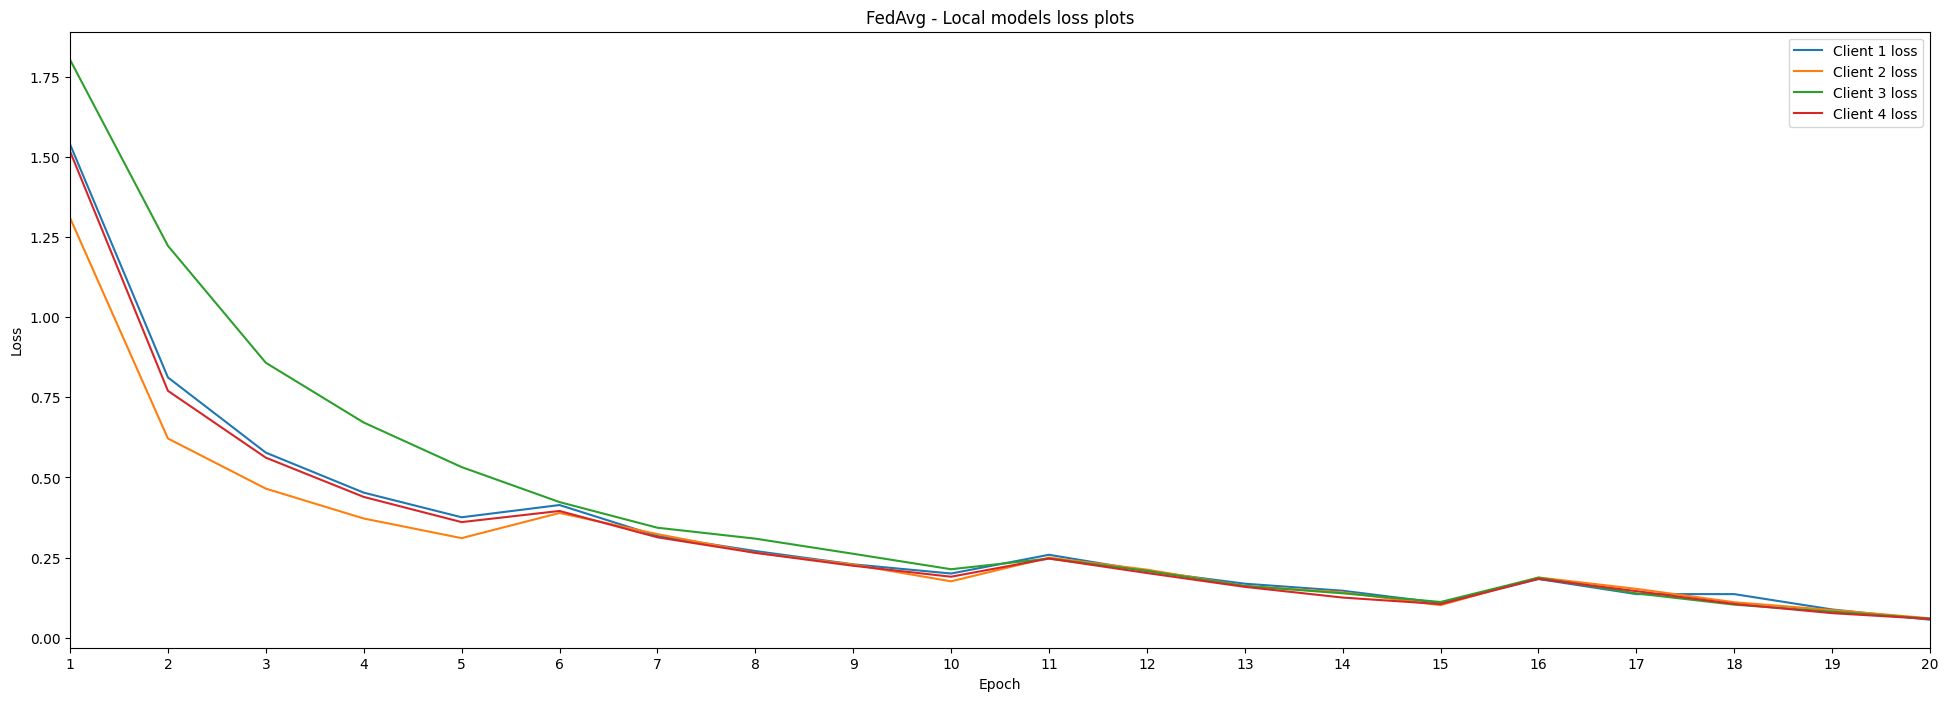

In [87]:
NUM_EPOCHS = 5
NUM_ROUNDS = 4

plot_train_loss(m_fedavg, NUM_EPOCHS * NUM_ROUNDS, title="FedAvg - Local models loss plots")

### 2. FedProx

In [88]:
# Build the clients
n_clients = 4
LEARNING_RATE = 1e-4
clients = [
    Client_FedProx(initial_model, torch.optim.Adam, LEARNING_RATE, nn.CrossEntropyLoss(), train_client_loaders[i], id=i, mu=0.01) for i in range(n_clients)
    ]

In [89]:
# Build the FedAvg aggregation strategy
strategy_fedprox = FedProx("FedProx", clients, server, local_avg=False)

In [90]:
m_fedprox = strategy_fedprox.train(nbre_epochs=5, nbre_rounds=4)

//// /////// ////
//// ROUND 0 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:05<00:00, 13.12it/s]


[0] ==> Epoch 0: train_acc: 0.47723577, train_loss: 1.55815065


train: 100%|██████████| 77/77 [00:04<00:00, 16.66it/s]


[0] ==> Epoch 1: train_acc: 0.74186992, train_loss: 0.87591704


train: 100%|██████████| 77/77 [00:05<00:00, 14.18it/s]


[0] ==> Epoch 2: train_acc: 0.81747967, train_loss: 0.68303775


train: 100%|██████████| 77/77 [00:05<00:00, 13.51it/s]


[0] ==> Epoch 3: train_acc: 0.84634146, train_loss: 0.61253981


train: 100%|██████████| 77/77 [00:04<00:00, 16.71it/s]


[0] ==> Epoch 4: train_acc: 0.86504065, train_loss: 0.56042009


train: 100%|██████████| 116/116 [00:08<00:00, 14.34it/s]


[1] ==> Epoch 0: train_acc: 0.57653752, train_loss: 1.3509922


train: 100%|██████████| 116/116 [00:06<00:00, 16.66it/s]


[1] ==> Epoch 1: train_acc: 0.78840423, train_loss: 0.72226953


train: 100%|██████████| 116/116 [00:07<00:00, 14.56it/s]


[1] ==> Epoch 2: train_acc: 0.83337849, train_loss: 0.61241907


train: 100%|██████████| 116/116 [00:07<00:00, 15.81it/s]


[1] ==> Epoch 3: train_acc: 0.8593877, train_loss: 0.56271039


train: 100%|██████████| 116/116 [00:07<00:00, 15.12it/s]


[1] ==> Epoch 4: train_acc: 0.8769981, train_loss: 0.51674357


train: 100%|██████████| 39/39 [00:02<00:00, 16.76it/s]


[2] ==> Epoch 0: train_acc: 0.38130081, train_loss: 1.83649886


train: 100%|██████████| 39/39 [00:02<00:00, 16.02it/s]


[2] ==> Epoch 1: train_acc: 0.62926829, train_loss: 1.29331118


train: 100%|██████████| 39/39 [00:03<00:00, 11.43it/s]


[2] ==> Epoch 2: train_acc: 0.71626016, train_loss: 0.94632562


train: 100%|██████████| 39/39 [00:02<00:00, 16.95it/s]


[2] ==> Epoch 3: train_acc: 0.77317073, train_loss: 0.79299357


train: 100%|██████████| 39/39 [00:02<00:00, 17.15it/s]


[2] ==> Epoch 4: train_acc: 0.82926829, train_loss: 0.67933581


train: 100%|██████████| 77/77 [00:04<00:00, 16.48it/s]


[3] ==> Epoch 0: train_acc: 0.51056911, train_loss: 1.54595551


train: 100%|██████████| 77/77 [00:05<00:00, 13.45it/s]


[3] ==> Epoch 1: train_acc: 0.75934959, train_loss: 0.86591964


train: 100%|██████████| 77/77 [00:04<00:00, 16.46it/s]


[3] ==> Epoch 2: train_acc: 0.81626016, train_loss: 0.67166582


train: 100%|██████████| 77/77 [00:05<00:00, 14.63it/s]


[3] ==> Epoch 3: train_acc: 0.84674797, train_loss: 0.59215801


train: 100%|██████████| 77/77 [00:05<00:00, 15.03it/s]


[3] ==> Epoch 4: train_acc: 0.87154472, train_loss: 0.54044916
Update clients without averaging
//// /////// ////
//// ROUND 1 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 16.78it/s]


[0] ==> Epoch 0: train_acc: 0.84065041, train_loss: 0.44509835


train: 100%|██████████| 77/77 [00:05<00:00, 13.45it/s]


[0] ==> Epoch 1: train_acc: 0.88333333, train_loss: 0.36258295


train: 100%|██████████| 77/77 [00:04<00:00, 16.58it/s]


[0] ==> Epoch 2: train_acc: 0.89308943, train_loss: 0.32770585


train: 100%|██████████| 77/77 [00:05<00:00, 13.12it/s]


[0] ==> Epoch 3: train_acc: 0.91463415, train_loss: 0.3035204


train: 100%|██████████| 77/77 [00:05<00:00, 14.65it/s]


[0] ==> Epoch 4: train_acc: 0.92520325, train_loss: 0.27937059


train: 100%|██████████| 116/116 [00:07<00:00, 16.13it/s]


[1] ==> Epoch 0: train_acc: 0.8528854, train_loss: 0.43014102


train: 100%|██████████| 116/116 [00:07<00:00, 14.62it/s]


[1] ==> Epoch 1: train_acc: 0.88350041, train_loss: 0.35976723


train: 100%|██████████| 116/116 [00:07<00:00, 14.71it/s]


[1] ==> Epoch 2: train_acc: 0.90544568, train_loss: 0.31971973


train: 100%|██████████| 116/116 [00:06<00:00, 16.66it/s]


[1] ==> Epoch 3: train_acc: 0.91005148, train_loss: 0.30415387


train: 100%|██████████| 116/116 [00:08<00:00, 14.15it/s]


[1] ==> Epoch 4: train_acc: 0.92007586, train_loss: 0.29145896


train: 100%|██████████| 39/39 [00:02<00:00, 16.78it/s]


[2] ==> Epoch 0: train_acc: 0.85528455, train_loss: 0.4437257


train: 100%|██████████| 39/39 [00:02<00:00, 16.62it/s]


[2] ==> Epoch 1: train_acc: 0.87642276, train_loss: 0.38185648


train: 100%|██████████| 39/39 [00:02<00:00, 16.87it/s]


[2] ==> Epoch 2: train_acc: 0.89593496, train_loss: 0.33790863


train: 100%|██████████| 39/39 [00:03<00:00, 12.74it/s]


[2] ==> Epoch 3: train_acc: 0.90894309, train_loss: 0.31260021


train: 100%|██████████| 39/39 [00:02<00:00, 14.72it/s]


[2] ==> Epoch 4: train_acc: 0.93333333, train_loss: 0.26505762


train: 100%|██████████| 77/77 [00:04<00:00, 16.51it/s]


[3] ==> Epoch 0: train_acc: 0.86178862, train_loss: 0.42438


train: 100%|██████████| 77/77 [00:05<00:00, 14.82it/s]


[3] ==> Epoch 1: train_acc: 0.89715447, train_loss: 0.34593179


train: 100%|██████████| 77/77 [00:05<00:00, 13.14it/s]


[3] ==> Epoch 2: train_acc: 0.90934959, train_loss: 0.30738303


train: 100%|██████████| 77/77 [00:05<00:00, 14.37it/s]


[3] ==> Epoch 3: train_acc: 0.92357724, train_loss: 0.27602784


train: 100%|██████████| 77/77 [00:05<00:00, 13.59it/s]


[3] ==> Epoch 4: train_acc: 0.92845528, train_loss: 0.26956123
Update clients without averaging
//// /////// ////
//// ROUND 2 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 16.44it/s]


[0] ==> Epoch 0: train_acc: 0.90447154, train_loss: 0.27963492


train: 100%|██████████| 77/77 [00:05<00:00, 14.37it/s]


[0] ==> Epoch 1: train_acc: 0.91910569, train_loss: 0.25025265


train: 100%|██████████| 77/77 [00:04<00:00, 15.64it/s]


[0] ==> Epoch 2: train_acc: 0.9402439, train_loss: 0.20934423


train: 100%|██████████| 77/77 [00:04<00:00, 16.59it/s]


[0] ==> Epoch 3: train_acc: 0.94512195, train_loss: 0.19608074


train: 100%|██████████| 77/77 [00:05<00:00, 13.43it/s]


[0] ==> Epoch 4: train_acc: 0.9597561, train_loss: 0.1672505


train: 100%|██████████| 116/116 [00:06<00:00, 16.79it/s]


[1] ==> Epoch 0: train_acc: 0.90029802, train_loss: 0.29728928


train: 100%|██████████| 116/116 [00:08<00:00, 14.36it/s]


[1] ==> Epoch 1: train_acc: 0.92441073, train_loss: 0.23999116


train: 100%|██████████| 116/116 [00:06<00:00, 16.72it/s]


[1] ==> Epoch 2: train_acc: 0.93280954, train_loss: 0.21734368


train: 100%|██████████| 116/116 [00:08<00:00, 14.14it/s]


[1] ==> Epoch 3: train_acc: 0.94906529, train_loss: 0.19291808


train: 100%|██████████| 116/116 [00:07<00:00, 14.66it/s]


[1] ==> Epoch 4: train_acc: 0.94852344, train_loss: 0.18227565


train: 100%|██████████| 39/39 [00:02<00:00, 14.85it/s]


[2] ==> Epoch 0: train_acc: 0.90325203, train_loss: 0.30305685


train: 100%|██████████| 39/39 [00:02<00:00, 16.67it/s]


[2] ==> Epoch 1: train_acc: 0.9300813, train_loss: 0.22820861


train: 100%|██████████| 39/39 [00:02<00:00, 16.36it/s]


[2] ==> Epoch 2: train_acc: 0.94552846, train_loss: 0.19867805


train: 100%|██████████| 39/39 [00:02<00:00, 16.09it/s]


[2] ==> Epoch 3: train_acc: 0.95934959, train_loss: 0.17103087


train: 100%|██████████| 39/39 [00:03<00:00, 12.61it/s]


[2] ==> Epoch 4: train_acc: 0.97073171, train_loss: 0.151193


train: 100%|██████████| 77/77 [00:05<00:00, 15.24it/s]


[3] ==> Epoch 0: train_acc: 0.89430894, train_loss: 0.29935416


train: 100%|██████████| 77/77 [00:04<00:00, 16.50it/s]


[3] ==> Epoch 1: train_acc: 0.93130081, train_loss: 0.22795014


train: 100%|██████████| 77/77 [00:05<00:00, 13.30it/s]


[3] ==> Epoch 2: train_acc: 0.93943089, train_loss: 0.21218831


train: 100%|██████████| 77/77 [00:04<00:00, 16.42it/s]


[3] ==> Epoch 3: train_acc: 0.95691057, train_loss: 0.17726349


train: 100%|██████████| 77/77 [00:04<00:00, 15.64it/s]


[3] ==> Epoch 4: train_acc: 0.96382114, train_loss: 0.16522616
Update clients without averaging
//// /////// ////
//// ROUND 3 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:05<00:00, 14.36it/s]


[0] ==> Epoch 0: train_acc: 0.9296748, train_loss: 0.21100802


train: 100%|██████████| 77/77 [00:04<00:00, 16.60it/s]


[0] ==> Epoch 1: train_acc: 0.93699187, train_loss: 0.18147502


train: 100%|██████████| 77/77 [00:05<00:00, 13.17it/s]


[0] ==> Epoch 2: train_acc: 0.95853659, train_loss: 0.15292369


train: 100%|██████████| 77/77 [00:04<00:00, 16.67it/s]


[0] ==> Epoch 3: train_acc: 0.97601626, train_loss: 0.11605188


train: 100%|██████████| 77/77 [00:04<00:00, 16.57it/s]


[0] ==> Epoch 4: train_acc: 0.98170732, train_loss: 0.10482528


train: 100%|██████████| 116/116 [00:08<00:00, 14.31it/s]


[1] ==> Epoch 0: train_acc: 0.91709564, train_loss: 0.22955885


train: 100%|██████████| 116/116 [00:07<00:00, 15.10it/s]


[1] ==> Epoch 1: train_acc: 0.94012463, train_loss: 0.19075735


train: 100%|██████████| 116/116 [00:07<00:00, 15.48it/s]


[1] ==> Epoch 2: train_acc: 0.95041994, train_loss: 0.16055056


train: 100%|██████████| 116/116 [00:07<00:00, 14.51it/s]


[1] ==> Epoch 3: train_acc: 0.9639664, train_loss: 0.14106868


train: 100%|██████████| 116/116 [00:07<00:00, 16.52it/s]


[1] ==> Epoch 4: train_acc: 0.97046871, train_loss: 0.13134689


train: 100%|██████████| 39/39 [00:02<00:00, 15.01it/s]


[2] ==> Epoch 0: train_acc: 0.93739837, train_loss: 0.19923062


train: 100%|██████████| 39/39 [00:03<00:00, 12.13it/s]


[2] ==> Epoch 1: train_acc: 0.95934959, train_loss: 0.14845366


train: 100%|██████████| 39/39 [00:02<00:00, 16.93it/s]


[2] ==> Epoch 2: train_acc: 0.97317073, train_loss: 0.11419432


train: 100%|██████████| 39/39 [00:02<00:00, 16.55it/s]


[2] ==> Epoch 3: train_acc: 0.9699187, train_loss: 0.11677654


train: 100%|██████████| 39/39 [00:02<00:00, 16.70it/s]


[2] ==> Epoch 4: train_acc: 0.9796748, train_loss: 0.10305252


train: 100%|██████████| 77/77 [00:05<00:00, 13.64it/s]


[3] ==> Epoch 0: train_acc: 0.92886179, train_loss: 0.21413265


train: 100%|██████████| 77/77 [00:04<00:00, 16.50it/s]


[3] ==> Epoch 1: train_acc: 0.9495935, train_loss: 0.17033044


train: 100%|██████████| 77/77 [00:04<00:00, 16.35it/s]


[3] ==> Epoch 2: train_acc: 0.9597561, train_loss: 0.15247444


train: 100%|██████████| 77/77 [00:05<00:00, 13.13it/s]


[3] ==> Epoch 3: train_acc: 0.97479675, train_loss: 0.11625203


train: 100%|██████████| 77/77 [00:04<00:00, 16.69it/s]

[3] ==> Epoch 4: train_acc: 0.97642276, train_loss: 0.11709983


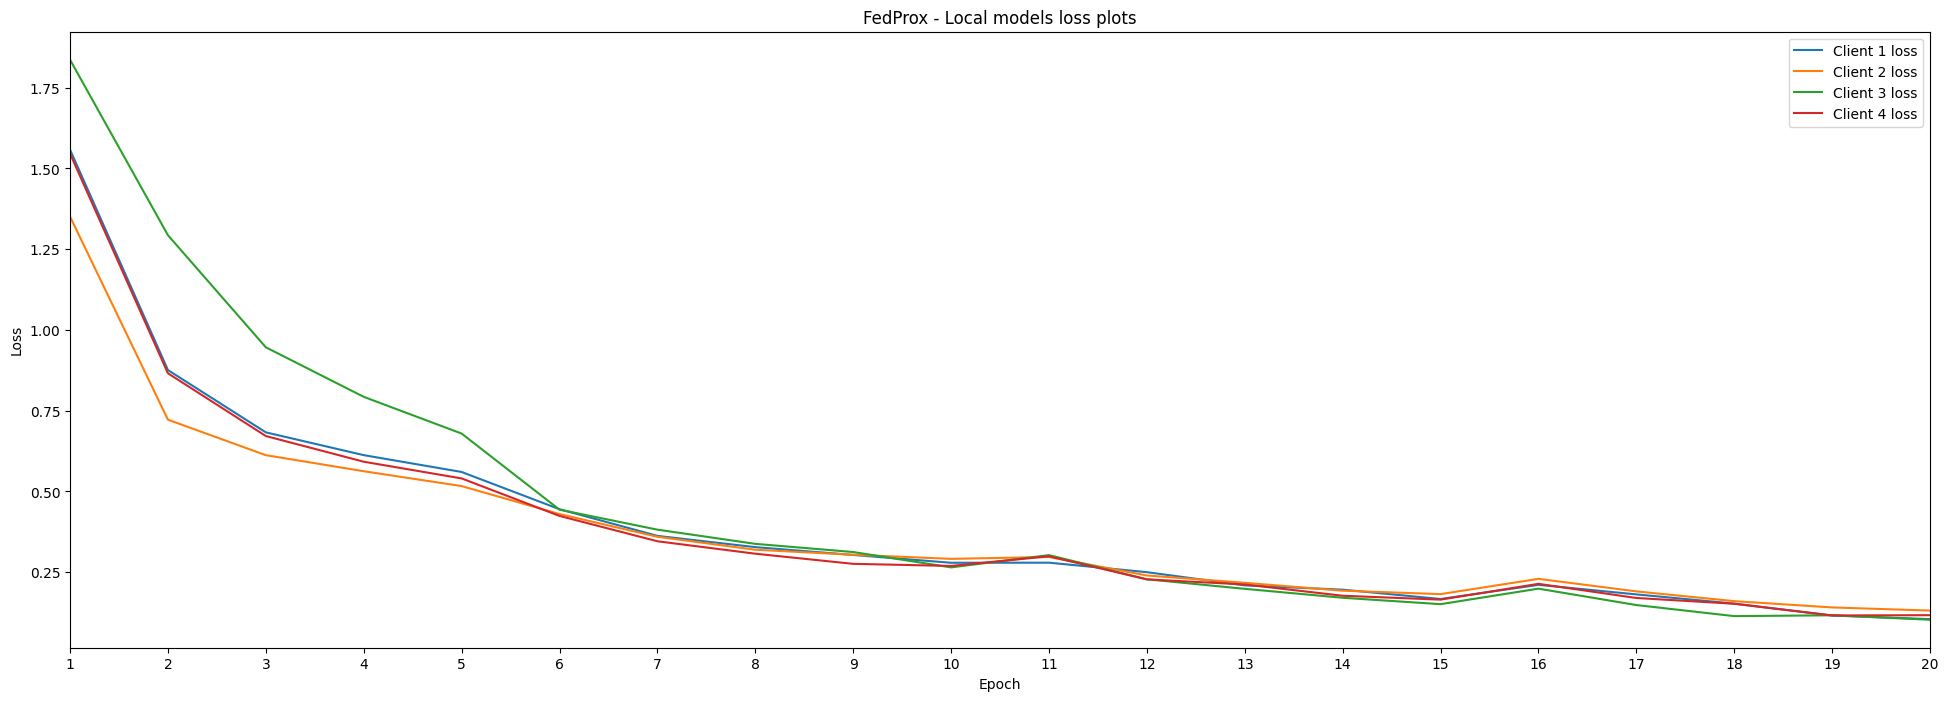

In [91]:
NUM_EPOCHS = 5
NUM_ROUNDS = 4

plot_train_loss(m_fedprox, NUM_EPOCHS * NUM_ROUNDS, title="FedProx - Local models loss plots")

### 3. FedALA

In [97]:
# Build the clients
n_clients = 4
LEARNING_RATE = 1e-4
BATCH_SIZE = 32

clients = [
    Client_FedALA(initial_model, torch.optim.Adam, LEARNING_RATE, nn.CrossEntropyLoss(), train_client_loaders[i], train_client_datasets[i], id=i, batch_size=BATCH_SIZE, rand_percent=80) for i in range(n_clients)
    ]

In [98]:
# Build the FedAvg aggregation strategy
strategy_fedala = FedALA("FedALA", clients, server, local_avg=False)

In [99]:
m_fedala = strategy_fedala.train(nbre_epochs=5, nbre_rounds=4)

//// /////// ////
//// ROUND 0 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 17.71it/s]


[0] ==> Epoch 0: train_acc: 0.45325203, train_loss: 1.54847424


train: 100%|██████████| 77/77 [00:05<00:00, 14.40it/s]


[0] ==> Epoch 1: train_acc: 0.72845528, train_loss: 0.81075176


train: 100%|██████████| 77/77 [00:04<00:00, 18.61it/s]


[0] ==> Epoch 2: train_acc: 0.80447154, train_loss: 0.56857622


train: 100%|██████████| 77/77 [00:04<00:00, 17.72it/s]


[0] ==> Epoch 3: train_acc: 0.84390244, train_loss: 0.45163905


train: 100%|██████████| 77/77 [00:05<00:00, 14.72it/s]


[0] ==> Epoch 4: train_acc: 0.87235772, train_loss: 0.37584108


train: 100%|██████████| 116/116 [00:06<00:00, 18.55it/s]


[1] ==> Epoch 0: train_acc: 0.58656191, train_loss: 1.29973621


train: 100%|██████████| 116/116 [00:07<00:00, 15.46it/s]


[1] ==> Epoch 1: train_acc: 0.79409374, train_loss: 0.60061798


train: 100%|██████████| 116/116 [00:06<00:00, 18.78it/s]


[1] ==> Epoch 2: train_acc: 0.85125982, train_loss: 0.44226089


train: 100%|██████████| 116/116 [00:07<00:00, 16.19it/s]


[1] ==> Epoch 3: train_acc: 0.87293416, train_loss: 0.35590287


train: 100%|██████████| 116/116 [00:06<00:00, 18.57it/s]


[1] ==> Epoch 4: train_acc: 0.89244107, train_loss: 0.30251829


train: 100%|██████████| 39/39 [00:02<00:00, 14.40it/s]


[2] ==> Epoch 0: train_acc: 0.40731707, train_loss: 1.80536544


train: 100%|██████████| 39/39 [00:02<00:00, 15.08it/s]


[2] ==> Epoch 1: train_acc: 0.64878049, train_loss: 1.2071188


train: 100%|██████████| 39/39 [00:02<00:00, 18.25it/s]


[2] ==> Epoch 2: train_acc: 0.72357724, train_loss: 0.83147877


train: 100%|██████████| 39/39 [00:02<00:00, 18.82it/s]


[2] ==> Epoch 3: train_acc: 0.78455285, train_loss: 0.66183292


train: 100%|██████████| 39/39 [00:02<00:00, 18.27it/s]


[2] ==> Epoch 4: train_acc: 0.81300813, train_loss: 0.54522551


train: 100%|██████████| 77/77 [00:05<00:00, 15.15it/s]


[3] ==> Epoch 0: train_acc: 0.49349593, train_loss: 1.54342564


train: 100%|██████████| 77/77 [00:04<00:00, 17.73it/s]


[3] ==> Epoch 1: train_acc: 0.75447154, train_loss: 0.78852094


train: 100%|██████████| 77/77 [00:04<00:00, 18.89it/s]


[3] ==> Epoch 2: train_acc: 0.80243902, train_loss: 0.5601181


train: 100%|██████████| 77/77 [00:05<00:00, 14.67it/s]


[3] ==> Epoch 3: train_acc: 0.84715447, train_loss: 0.4418862


train: 100%|██████████| 77/77 [00:04<00:00, 16.39it/s]


[3] ==> Epoch 4: train_acc: 0.87926829, train_loss: 0.3599479
Update clients without averaging
//// /////// ////
//// ROUND 1 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:05<00:00, 14.08it/s]


[0] ==> Epoch 0: train_acc: 0.85813008, train_loss: 0.39831805


train: 100%|██████████| 77/77 [00:05<00:00, 14.69it/s]


[0] ==> Epoch 1: train_acc: 0.88536585, train_loss: 0.32346727


train: 100%|██████████| 77/77 [00:04<00:00, 18.85it/s]


[0] ==> Epoch 2: train_acc: 0.90487805, train_loss: 0.27908216


train: 100%|██████████| 77/77 [00:04<00:00, 17.75it/s]


[0] ==> Epoch 3: train_acc: 0.92235772, train_loss: 0.23059601


train: 100%|██████████| 77/77 [00:05<00:00, 15.36it/s]


[0] ==> Epoch 4: train_acc: 0.93617886, train_loss: 0.19442181


train: 100%|██████████| 116/116 [00:06<00:00, 18.33it/s]


[1] ==> Epoch 0: train_acc: 0.86805744, train_loss: 0.37893771


train: 100%|██████████| 116/116 [00:08<00:00, 12.93it/s]


[1] ==> Epoch 1: train_acc: 0.88918992, train_loss: 0.31628922


train: 100%|██████████| 116/116 [00:06<00:00, 17.90it/s]


[1] ==> Epoch 2: train_acc: 0.91357356, train_loss: 0.25677342


train: 100%|██████████| 116/116 [00:07<00:00, 15.78it/s]


[1] ==> Epoch 3: train_acc: 0.93362232, train_loss: 0.20438778


train: 100%|██████████| 116/116 [00:06<00:00, 17.59it/s]


[1] ==> Epoch 4: train_acc: 0.93470604, train_loss: 0.18854794


train: 100%|██████████| 39/39 [00:02<00:00, 13.29it/s]


[2] ==> Epoch 0: train_acc: 0.86178862, train_loss: 0.41921056


train: 100%|██████████| 39/39 [00:02<00:00, 18.62it/s]


[2] ==> Epoch 1: train_acc: 0.8902439, train_loss: 0.34768482


train: 100%|██████████| 39/39 [00:02<00:00, 18.64it/s]


[2] ==> Epoch 2: train_acc: 0.90243902, train_loss: 0.30727519


train: 100%|██████████| 39/39 [00:02<00:00, 18.49it/s]


[2] ==> Epoch 3: train_acc: 0.92682927, train_loss: 0.24385458


train: 100%|██████████| 39/39 [00:02<00:00, 18.58it/s]


[2] ==> Epoch 4: train_acc: 0.93333333, train_loss: 0.2206598


train: 100%|██████████| 77/77 [00:05<00:00, 14.20it/s]


[3] ==> Epoch 0: train_acc: 0.8699187, train_loss: 0.39202301


train: 100%|██████████| 77/77 [00:04<00:00, 18.46it/s]


[3] ==> Epoch 1: train_acc: 0.89634146, train_loss: 0.31360474


train: 100%|██████████| 77/77 [00:04<00:00, 18.25it/s]


[3] ==> Epoch 2: train_acc: 0.91260163, train_loss: 0.26351999


train: 100%|██████████| 77/77 [00:05<00:00, 14.41it/s]


[3] ==> Epoch 3: train_acc: 0.93333333, train_loss: 0.22105067


train: 100%|██████████| 77/77 [00:04<00:00, 18.44it/s]


[3] ==> Epoch 4: train_acc: 0.94308943, train_loss: 0.18588578
Update clients without averaging
//// /////// ////
//// ROUND 2 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 18.37it/s]


[0] ==> Epoch 0: train_acc: 0.91707317, train_loss: 0.25014829


train: 100%|██████████| 77/77 [00:05<00:00, 14.25it/s]


[0] ==> Epoch 1: train_acc: 0.93333333, train_loss: 0.20454503


train: 100%|██████████| 77/77 [00:04<00:00, 18.40it/s]


[0] ==> Epoch 2: train_acc: 0.94308943, train_loss: 0.17070486


train: 100%|██████████| 77/77 [00:04<00:00, 17.80it/s]


[0] ==> Epoch 3: train_acc: 0.96097561, train_loss: 0.13853886


train: 100%|██████████| 77/77 [00:05<00:00, 14.59it/s]


[0] ==> Epoch 4: train_acc: 0.97560976, train_loss: 0.10309322


train: 100%|██████████| 116/116 [00:06<00:00, 18.60it/s]


[1] ==> Epoch 0: train_acc: 0.90354917, train_loss: 0.25386451


train: 100%|██████████| 116/116 [00:07<00:00, 15.48it/s]


[1] ==> Epoch 1: train_acc: 0.9306421, train_loss: 0.20859354


train: 100%|██████████| 116/116 [00:06<00:00, 18.61it/s]


[1] ==> Epoch 2: train_acc: 0.94391764, train_loss: 0.17465479


train: 100%|██████████| 116/116 [00:07<00:00, 15.53it/s]


[1] ==> Epoch 3: train_acc: 0.95583853, train_loss: 0.14167944


train: 100%|██████████| 116/116 [00:06<00:00, 18.39it/s]


[1] ==> Epoch 4: train_acc: 0.96288269, train_loss: 0.1191027


train: 100%|██████████| 39/39 [00:02<00:00, 14.89it/s]


[2] ==> Epoch 0: train_acc: 0.92113821, train_loss: 0.25706453


train: 100%|██████████| 39/39 [00:02<00:00, 14.70it/s]


[2] ==> Epoch 1: train_acc: 0.91869919, train_loss: 0.21670907


train: 100%|██████████| 39/39 [00:02<00:00, 18.69it/s]


[2] ==> Epoch 2: train_acc: 0.95284553, train_loss: 0.1628041


train: 100%|██████████| 39/39 [00:02<00:00, 18.50it/s]


[2] ==> Epoch 3: train_acc: 0.96260163, train_loss: 0.13685948


train: 100%|██████████| 39/39 [00:02<00:00, 18.32it/s]


[2] ==> Epoch 4: train_acc: 0.98292683, train_loss: 0.10261394


train: 100%|██████████| 77/77 [00:05<00:00, 15.39it/s]


[3] ==> Epoch 0: train_acc: 0.91463415, train_loss: 0.24936309


train: 100%|██████████| 77/77 [00:04<00:00, 17.42it/s]


[3] ==> Epoch 1: train_acc: 0.93455285, train_loss: 0.20168447


train: 100%|██████████| 77/77 [00:04<00:00, 18.20it/s]


[3] ==> Epoch 2: train_acc: 0.94146341, train_loss: 0.16632222


train: 100%|██████████| 77/77 [00:05<00:00, 14.51it/s]


[3] ==> Epoch 3: train_acc: 0.96219512, train_loss: 0.13679315


train: 100%|██████████| 77/77 [00:04<00:00, 18.19it/s]


[3] ==> Epoch 4: train_acc: 0.97926829, train_loss: 0.10345078
Update clients without averaging
//// /////// ////
//// ROUND 3 ////
//// /////// ////


train: 100%|██████████| 77/77 [00:04<00:00, 18.64it/s]


[0] ==> Epoch 0: train_acc: 0.9304878, train_loss: 0.18137545


train: 100%|██████████| 77/77 [00:05<00:00, 14.88it/s]


[0] ==> Epoch 1: train_acc: 0.96260163, train_loss: 0.1295396


train: 100%|██████████| 77/77 [00:04<00:00, 18.27it/s]


[0] ==> Epoch 2: train_acc: 0.97357724, train_loss: 0.09861964


train: 100%|██████████| 77/77 [00:04<00:00, 18.34it/s]


[0] ==> Epoch 3: train_acc: 0.97845528, train_loss: 0.08307561


train: 100%|██████████| 77/77 [00:05<00:00, 14.13it/s]


[0] ==> Epoch 4: train_acc: 0.99105691, train_loss: 0.05921268


train: 100%|██████████| 116/116 [00:06<00:00, 18.47it/s]


[1] ==> Epoch 0: train_acc: 0.93308047, train_loss: 0.18950735


train: 100%|██████████| 116/116 [00:07<00:00, 15.70it/s]


[1] ==> Epoch 1: train_acc: 0.95204552, train_loss: 0.14693442


train: 100%|██████████| 116/116 [00:06<00:00, 18.51it/s]


[1] ==> Epoch 2: train_acc: 0.96613384, train_loss: 0.11971246


train: 100%|██████████| 116/116 [00:07<00:00, 15.87it/s]


[1] ==> Epoch 3: train_acc: 0.97724194, train_loss: 0.08653968


train: 100%|██████████| 116/116 [00:06<00:00, 18.49it/s]


[1] ==> Epoch 4: train_acc: 0.98482796, train_loss: 0.0660448


train: 100%|██████████| 39/39 [00:02<00:00, 16.39it/s]


[2] ==> Epoch 0: train_acc: 0.9300813, train_loss: 0.20351326


train: 100%|██████████| 39/39 [00:02<00:00, 13.05it/s]


[2] ==> Epoch 1: train_acc: 0.95528455, train_loss: 0.13101403


train: 100%|██████████| 39/39 [00:02<00:00, 13.54it/s]


[2] ==> Epoch 2: train_acc: 0.97317073, train_loss: 0.09429502


train: 100%|██████████| 39/39 [00:02<00:00, 15.73it/s]


[2] ==> Epoch 3: train_acc: 0.98617886, train_loss: 0.07985082


train: 100%|██████████| 39/39 [00:02<00:00, 18.14it/s]


[2] ==> Epoch 4: train_acc: 0.99105691, train_loss: 0.05967941


train: 100%|██████████| 77/77 [00:05<00:00, 14.59it/s]


[3] ==> Epoch 0: train_acc: 0.94349593, train_loss: 0.18107469


train: 100%|██████████| 77/77 [00:04<00:00, 18.62it/s]


[3] ==> Epoch 1: train_acc: 0.95894309, train_loss: 0.13165864


train: 100%|██████████| 77/77 [00:04<00:00, 18.50it/s]


[3] ==> Epoch 2: train_acc: 0.97073171, train_loss: 0.10817934


train: 100%|██████████| 77/77 [00:05<00:00, 14.12it/s]


[3] ==> Epoch 3: train_acc: 0.98658537, train_loss: 0.07479075


train: 100%|██████████| 77/77 [00:04<00:00, 18.53it/s]

[3] ==> Epoch 4: train_acc: 0.99146341, train_loss: 0.05424174


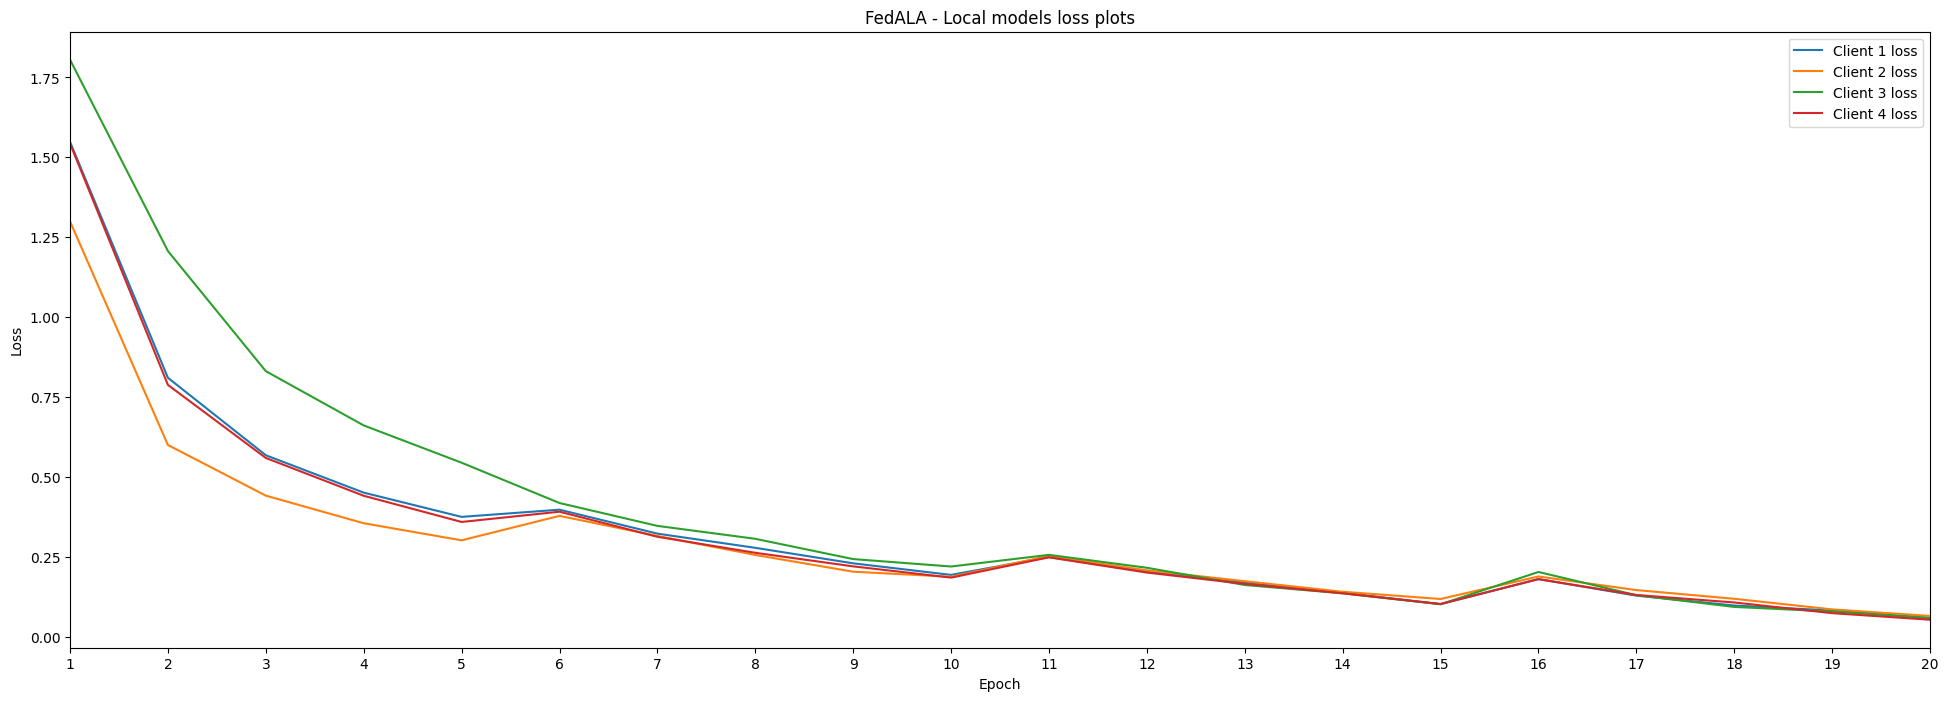

In [100]:
NUM_EPOCHS = 5
NUM_ROUNDS = 4

plot_train_loss(m_fedala, NUM_EPOCHS * NUM_ROUNDS, title="FedALA - Local models loss plots")

## IV. Evaluate the results from the aggregation algorithms

In [101]:
def average_metrics(acc_metrics, sensitivity_metrics, specificity_metrics, auc_metrics, strategy_title):
    """
    This function takes a list of metrics and returns the average of the
    metrics for each client along with their standard deviation and the name of
    the strategy used.

    Parameters:
    - list_metrics (list[dict]): A list of dictionaries containing the metrics for each client.
    - strategy_title (str): The title of the aggregation strategy.

    Returns:
      - acc_metrics (list[dict]): A list of dictionaries containing the accuracy metrics for each strategy.
      - sensitivity_metrics (list[dict]): A list of dictionaries containing the sensitivity metrics for each strategy.
      - specificity_metrics (list[dict]): A list of dictionaries containing the specificity metrics for each strategy.
      - auc_metrics (list[dict]): A list of dictionaries containing the AUC metrics for each strategy.
      - acc_std (list[dict]): A list of dictionaries containing the standard deviation of the accuracy metrics for each strategy.
      - sensitivity_std (list[dict]): A list of dictionaries containing the standard deviation of the sensitivity metrics for each strategy.
      - specificity_std (list[dict]): A list of dictionaries containing the standard deviation of the specificity metrics for each strategy.
      - auc_std (list[dict]): A list of dictionaries containing the standard deviation of the AUC metrics for each strategy.
    """

    # Let us now calculate the average of the Accuracy, sensitivity, specificity, and AUC
    # and add them to their respective metric list

    # Accuracy
    acc_metrics = [{
        "client_id": strategy_title,
        "acc_Fed": np.round(np.mean([m['acc_Fed'] for m in acc_metrics]), 8),
        "acc_global_Fed": np.round(np.mean([m['acc_global_Fed'] for m in acc_metrics]), 8),
    }]

    acc_std = [{
        "client_id": strategy_title,
        "acc_Fed": np.round(np.std([m['acc_Fed'] for m in acc_metrics]), 8),
        "acc_global_Fed": np.round(np.std([m['acc_global_Fed'] for m in acc_metrics]), 8),
    }]


    # Sensitivity
    sensitivity_metrics = [{
        "client_id": strategy_title,
        "sensitivity_Fed": np.round(np.mean([m['sensitivity_Fed'] for m in sensitivity_metrics]), 8),
        "sensitivity_global_Fed": np.round(np.mean([m['sensitivity_global_Fed'] for m in sensitivity_metrics]), 8),
    }]

    sensitivity_std = [{
        "client_id": strategy_title,
        "sensitivity_Fed": np.round(np.std([m['sensitivity_Fed'] for m in sensitivity_metrics]), 8),
        "sensitivity_global_Fed": np.round(np.std([m['sensitivity_global_Fed'] for m in sensitivity_metrics]), 8),
    }]

    # Specificity
    specificity_metrics = [{
        "client_id": strategy_title,
        "specificity_Fed": np.round(np.mean([m['specificity_Fed'] for m in specificity_metrics]), 8),
        "specificity_global_Fed": np.round(np.mean([m['specificity_global_Fed'] for m in specificity_metrics]), 8),
    }]

    specificity_std = [{
        "client_id": strategy_title,
        "specificity_Fed": np.round(np.std([m['specificity_Fed'] for m in specificity_metrics]), 8),
        "specificity_global_Fed": np.round(np.std([m['specificity_global_Fed'] for m in specificity_metrics]), 8),
    }]

    # AUC
    auc_metrics = [{
        "client_id": strategy_title,
        "AUC_Fed": np.round(np.mean([m['AUC_Fed'] for m in auc_metrics]), 3),
        "AUC_global_Fed": np.round(np.mean([m['AUC_global_Fed'] for m in auc_metrics]), 3),
    }]

    auc_std = [{
        "client_id": strategy_title,
        "AUC_Fed": np.round(np.std([m['AUC_Fed'] for m in auc_metrics]), 3),
        "AUC_global_Fed": np.round(np.std([m['AUC_global_Fed'] for m in auc_metrics]), 3),
    }]

    return acc_metrics, sensitivity_metrics, specificity_metrics, auc_metrics, acc_std, sensitivity_std, specificity_std, auc_std

In [102]:
def validation_by_model(list_clients, test_client_loaders, global_test_loader):
    """
      This function applies the validation step per client.

      Parameters:
      - list_clients (list[Client]): A list of clients.
      - test_client_loaders (list[DataLoader]): A list of test data loaders for each client.
      - global_test_loader (DataLoader): The global test data loader.

      Returns:
      - acc_metrics (list[dict]): A list of dictionaries containing the accuracy metrics for each client.
      - sensitivity_metrics (list[dict]): A list of dictionaries containing the sensitivity metrics for each client.
      - specificity_metrics (list[dict]): A list of dictionaries containing the specificity metrics for each client.
      - auc_metrics (list[dict]): A list of dictionaries containing the AUC metrics for each client.
    """
    acc_metrics = []
    sensitivity_metrics = []
    specificity_metrics = []
    auc_metrics = []


    # Iterate on the clients
    for client in list_clients:
      print(f"Client {client.id + 1}")

      # We pass the local test sets
      metric_local = validate_model(client.model, test_client_loaders[i])

      # We pass the global set
      metric_global = validate_model(client.model, global_test_loader)

      acc_metrics.append({
          "client_id": f"Client_{client.id + 1}",
          "acc_Fed": metric_local['val_acc'],
          "acc_global_Fed": metric_global['val_acc'],
      })

      sensitivity_metrics.append({
          "client_id": f"Client_{client.id + 1}",
          "sensitivity_Fed": metric_local['val_sensitivity'],
          "sensitivity_global_Fed": metric_global['val_sensitivity'],
      })

      specificity_metrics.append({
          "client_id": f"Client_{client.id + 1}",
          "specificity_Fed": metric_local['val_specificity'],
          "specificity_global_Fed": metric_global['val_specificity'],
      })

      auc_metrics.append({
          "client_id": f"Client_{client.id + 1}",
          "AUC_Fed": metric_local['val_auc'],
          "AUC_global_Fed": metric_global['val_auc'],
      })


    return acc_metrics, sensitivity_metrics, specificity_metrics, auc_metrics

In [103]:
def validation_by_strategy(list_strategies, test_client_loaders, global_test_loader):
    """
    This function applies the validation step per strategy.

    Parameters:
    - list_strategies (list[Strategy]): A list of strategies.
    - test_client_loaders (list[DataLoader]): A list of test data loaders for each strategy.
    - global_test_loader (DataLoader): The global test data loader.
    """
    acc_metrics_strategy = []
    sensitivity_metrics_strategy = []
    specificity_metrics_strategy = []
    auc_metrics_strategy = []

    acc_std_strategy = []
    sensitivity_std_strategy = []
    specificity_std_strategy = []
    auc_std_strategy = []

    for i, strategy in enumerate(list_strategies):
      # For each strategy in the list
      print("/"*4,"/"*len(strategy.strategy_title),"/"*4)
      print("/"*4,strategy.strategy_title,"/"*4)
      print("/"*4,"/"*len(strategy.strategy_title),"/"*4)

      # Validtae the models of the strategy
      acc_metrics, sensitivity_metrics, specificity_metrics, auc_metrics = validation_by_model(strategy.clients, test_client_loaders, global_test_loader)

      # We must now average the results and get the standard deviation
      acc_metrics, sensitivity_metrics, specificity_metrics, auc_metrics, acc_std, sensitivity_std, specificity_std, auc_std = average_metrics(acc_metrics, sensitivity_metrics, specificity_metrics, auc_metrics, strategy.strategy_title)

      # Append the results to the list
      acc_metrics_strategy.extend(acc_metrics)
      sensitivity_metrics_strategy.extend(sensitivity_metrics)
      specificity_metrics_strategy.extend(specificity_metrics)
      auc_metrics_strategy.extend(auc_metrics)

      acc_std_strategy.extend(acc_std)
      sensitivity_std_strategy.extend(sensitivity_std)
      specificity_std_strategy.extend(specificity_std)
      auc_std_strategy.extend(auc_std)


    return acc_metrics_strategy, sensitivity_metrics_strategy, specificity_metrics_strategy, auc_metrics_strategy, acc_std_strategy, sensitivity_std_strategy, specificity_std_strategy, auc_std_strategy


In [104]:

def plot_acc_sens_spec(metrics, ax, y_err=None, title="Metrics", x_label="Client ID", limit=(0,1), style=None):
  """
  This function plots the metrics calculated through the inference step.

  Parameters:
  - metrics: A list of dictionnaries for each client that contain calculated metrics.
  - ax: The axis to plot the metrics on.
  - y_err: A dictionnary of the standard deviation of the metrics.
  - title: The title of the plot. Default is 'Metrics'.
  - x_label: The label of the x-axis. Default is 'Client ID'.
  - limit: The limits of the y-axis. Default is (0,1).
  - style: The style dictionnary of each metric label bar. For each metric as a key we
  have a list of the color and hatch. Default is None.
  """

  # Extract client ids and metrics
  client_ids = [m['client_id'] for m in metrics]
  # Add the Average tag to the client ids list
  metrics_labels = list(metrics[0].keys())[1:]

  # Prepare the data for plotting
  values = {metric: [m[metric] for m in metrics] for metric in metrics_labels}

  # Plotting
  n_clients = len(client_ids)
  n_metrics = len(metrics_labels)
  spacing = 0.5  # spacing between groups
  width = 0.1  # the width of the bars

  x = np.arange(n_clients) * (n_metrics * width + spacing)  # the label locations with spacing

  y_err = None

  # Plot bars for each metric with spacing
  for i, metric in enumerate(metrics_labels):

    if style != None:

      if y_err != None:

        ax.bar(x + i * width, values[metric], width, label=metric, yerr=y_err[metric], hatch=style[metric][1], color=style[metric][0])
      else:
        ax.bar(x + i * width, values[metric], width, label=metric, hatch=style[metric][1], color=style[metric][0])
    else:
      if y_err != None:
        ax.bar(x + i * width, values[metric], width, label=metric, yerr=y_err[metric])
      else:
        ax.bar(x + i * width, values[metric], width, label=metric)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_xlabel(x_label)
  ax.set_ylabel('Scores')
  ax.set_ylim(limit[0], limit[1])
  ax.set_title(title)
  ax.set_xticks(x + width * (n_metrics - 1) / 2)
  ax.set_xticklabels(client_ids)
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [105]:
# We apply the validation_by_strategy function
list_strategies = [strategy_fedavg, strategy_fedprox, strategy_fedala]
acc_metrics, sensitivity_metrics, specificity_metrics, auc_metrics, acc_std, sensitivity_std, specificity_std, auc_std = validation_by_strategy(list_strategies, test_client_loaders, global_test_loader)

//// ////// ////
//// FedAvg ////
//// ////// ////
Client 1
Client 2
Client 3
Client 4
//// /////// ////
//// FedProx ////
//// /////// ////
Client 1
Client 2
Client 3
Client 4
//// ////// ////
//// FedALA ////
//// ////// ////
Client 1
Client 2
Client 3
Client 4


In [106]:
# Set up the styles for each metric
acc_style={
    "acc_Fed": ("#008dda", ""),
    "acc_global_Fed": ("#ffcf81", "///"),
}

sensitivity_style={
    "sensitivity_Fed": ("#008dda", ""),
    "sensitivity_global_Fed": ("#ffcf81", "///"),
}

specificity_style={
    "specificity_Fed": ("#008dda", ""),
    "specificity_global_Fed": ("#ffcf81", "///"),
}

auc_style={
    "AUC_Fed": ("#008dda", ""),
    "AUC_global_Fed": ("#ffcf81", "///"),
}

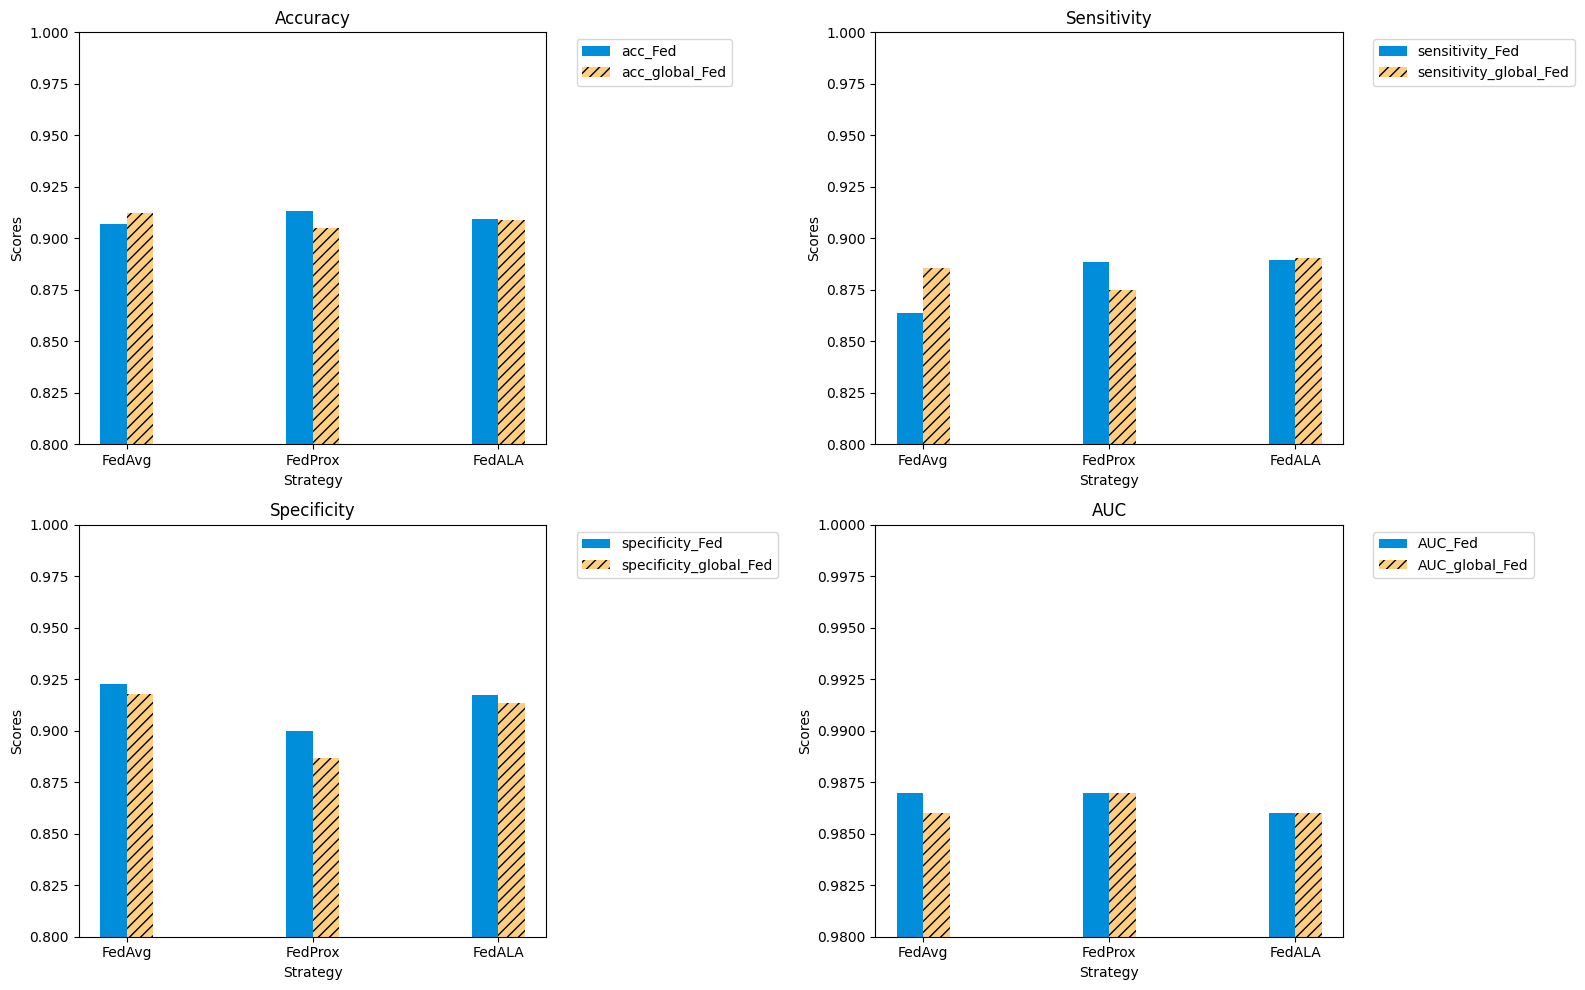

In [107]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# Plot Accuracy
plot_acc_sens_spec(acc_metrics, ax[0][0], y_err=acc_std, title="Accuracy", x_label="Strategy", limit=(0.8, 1), style=acc_style)

# Plot sensitivity
plot_acc_sens_spec(sensitivity_metrics, ax[0][1], y_err=sensitivity_std, title="Sensitivity", x_label="Strategy", limit=(0.8, 1), style=sensitivity_style)

# Plot specificity
plot_acc_sens_spec(specificity_metrics, ax[1][0], y_err=specificity_std, title="Specificity", x_label="Strategy", limit=(0.8, 1.0), style=specificity_style)

# Plot AUC
plot_acc_sens_spec(auc_metrics, ax[1][1], title="AUC", x_label="Strategy", limit=(0.98, 1), style=auc_style)

fig.tight_layout()
plt.show()

**Question 4**:

What does these comparative plots tell you about the different aggregation algorithms?

Good job for reaching 👏👏👏! You have earned this cookie 🍪.

But don't stop now. Keep going only one last step to the finishing line champion 🏆

# Part 4. 💡 Federated generative learning using non-IID in feature distribution

This final part is a coding up exercise where you will:
* Implement non-IID in features distribution using `KMeans`.
* Build an image `AutoEncoder` for the generative learning.
* Train a non-fed and federated generative models.
* Benchmark them using the `mean_absolute_error` and the `mean_squared_error`.

In [108]:
# Load the dependencies
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error

## I. Cluster the data for each client

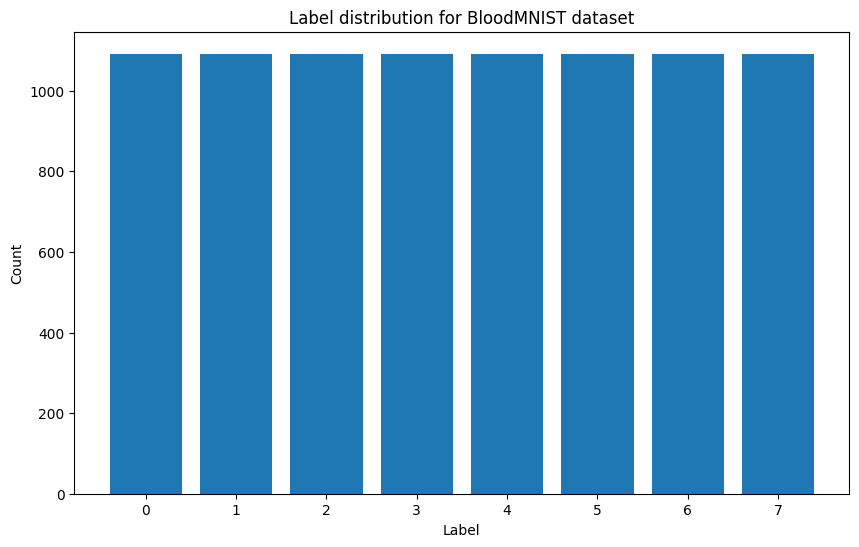

In [109]:
plot_label_distribution(y_combined_us, title="Label distribution for BloodMNIST dataset")

In [110]:
n_clients = 4 # Number of clients
n_clusters = n_clients + 1 # One cluster for each client plus a cluster for the global test set

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit_transform(X_combined_us.reshape(X_combined_us.shape[0],-1))

# Get the cluster for each data point
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [111]:
# Plot the distribution using the KDE plot for each cluster
def plot_features_distribution(X, y, title='local features distribution'):
    """
    Plots the distribution of features using KDE plot for each cluster in the dataset.

    Parameters:
        - X: The features of the dataset.
        - y: The labels of the dataset indicating clusters.
        - title: Title for the plot.

    Returns:
        None
    """

    # Prepare the plot placeholder
    fig, ax = plt.subplots(figsize=(12, 6))

    # Iterate over each unique cluster label to plot its KDE distribution
    for id, i in enumerate(tqdm(np.unique(y))):
        data_idx = np.where(y == i)[0]

        sns.kdeplot(X[data_idx].flatten(), label=f'Cluster {id}', fill=False, alpha=0.5, color=sns.color_palette()[id])

        # Set plot labels and title
        ax.set_xlabel('Intensity')
        ax.set_title(title)
        ax.legend(loc="upper right")

    plt.legend(loc='upper right')
    plt.show()


In [115]:
# Perform T-SNE
def perform_tsne(X):
    """
    Performs T-SNE dimensionality reduction on the input data.

    Parameters:
        - X: The input data matrix.

    Returns:
        - X_tsne: The reduced 2-dimensional T-SNE representation of the data.
    """

    # Initialize the TSNE model
    tsne = TSNE(n_components=2, random_state=42, verbose=True, n_iter=300, perplexity=30)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X.reshape(X.shape[0], -1))

    return X_tsne

# Plotting function
def plot_tsne_AE(X, y):
    """
    Plots a scatter plot of the T-SNE embedding of the data.

    Parameters:
        - X: The T-SNE transformed data.
        - y: The labels indicating different clusters or classes.

    Returns:
        None
    """

    plt.figure(figsize=(10, 6))

    # Define colors for each unique class
    unique_classes = np.unique(y)
    colors = {i: color for i, color in enumerate([
        '#f38181', '#95e1d3', '#fce38a', '#252a34',
        '#eaeaea', '#ff2e63', '#08d9d6', '#eaffd0'
    ])}

    # Plot each class separately
    for i, class_value in enumerate(unique_classes):
        idx = y == class_value
        plt.scatter(X[idx, 0], X[idx, 1], color=colors[i], label=f'Cluster {class_value}', alpha=0.2)

    # Set plot labels and title
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title('T-SNE of BloodMNIST Dataset')
    plt.xlabel('T-SNE Component 1')
    plt.ylabel('T-SNE Component 2')
    plt.show()


In [113]:
x_tsne_AE = perform_tsne(X_combined_us)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8736 samples in 0.014s...
[t-SNE] Computed neighbors for 8736 samples in 13.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8736
[t-SNE] Computed conditional probabilities for sample 2000 / 8736
[t-SNE] Computed conditional probabilities for sample 3000 / 8736
[t-SNE] Computed conditional probabilities for sample 4000 / 8736
[t-SNE] Computed conditional probabilities for sample 5000 / 8736
[t-SNE] Computed conditional probabilities for sample 6000 / 8736
[t-SNE] Computed conditional probabilities for sample 7000 / 8736
[t-SNE] Computed conditional probabilities for sample 8000 / 8736
[t-SNE] Computed conditional probabilities for sample 8736 / 8736
[t-SNE] Mean sigma: 392.248474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.788010
[t-SNE] KL divergence after 300 iterations: 3.348747


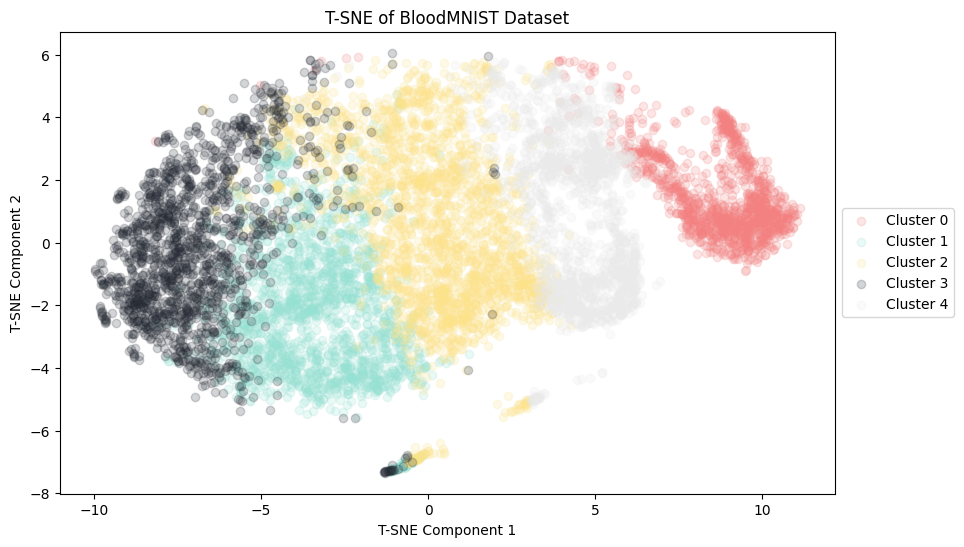

In [116]:
plot_tsne_AE(x_tsne_AE, cluster_labels)

100%|██████████| 5/5 [01:45<00:00, 21.11s/it]


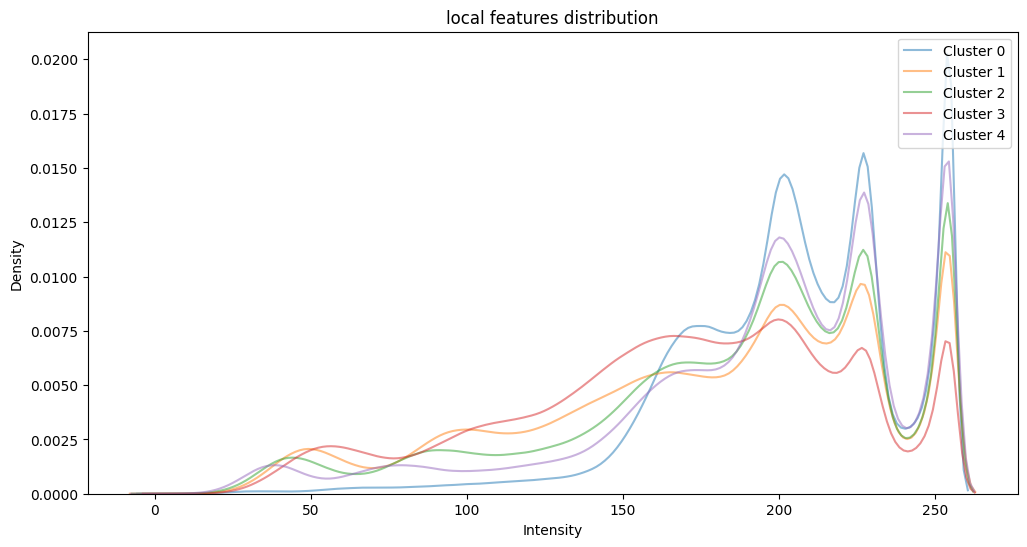

In [117]:
plot_features_distribution(X_combined_us, cluster_labels)

In [118]:
def split_nonIID_features(clusters, global_cluster_idx, train_split=0.8, test_split=0.2, shuffle=False, random_state=42):
    """
    Splits data into non-IID (independent and identically distributed) local sets based on clusters.

    Args:
    - clusters (array-like): Array indicating cluster assignments for each data point.
    - global_cluster_idx (int): Index of the global cluster.
    - train_split (float, optional): Fraction of data to be used for training (default is 0.8).
    - test_split (float, optional): Fraction of data to be used for testing (default is 0.2).
    - shuffle (bool, optional): Whether to shuffle data within each cluster (default is False).
    - random_state (int, optional): Random seed for shuffling (default is 42).

    Returns:
    - local_splits (list): List of tuples containing train and test indices for each local cluster.
    """

    # Get the local sets for each cluster
    local_splits = []
    for i in range(len(np.unique(clusters))):
        if i != global_cluster_idx:
            local_splits.append(np.where(clusters == i)[0])

    # Add the global set at the end
    local_splits.append(np.where(clusters == global_cluster_idx)[0])

    # Shuffle the data within each local split if shuffle is True
    for split in local_splits:
        if shuffle:
            np.random.seed(random_state)
            np.random.shuffle(split)

    # Determine train and test indices for each local cluster
    client_split = []
    for i in range(len(local_splits)):
        client_split.append((int(train_split * len(local_splits[i])), int(test_split * len(local_splits[i]))))

    # Split each local cluster into train and test sets
    for i in range(len(client_split)):
        train_idx, _ = client_split[i]
        train_indices = local_splits[i][:train_idx]
        test_indices = local_splits[i][train_idx:]
        local_splits[i] = (train_indices.tolist(), test_indices.tolist())

    return local_splits


In [119]:
local_splits = split_nonIID_features(cluster_labels, 0, shuffle=True)

In [121]:
# For each client local set
for i in range(len(local_splits)-1):
    ## Get train and test indicies for each client
    train_idx, val_idx = local_splits[i]
    print(f"Client {i+1} has {np.round((len(train_idx)/len(y_combined_us[train_idx+val_idx])),2)} train and {np.round((len(val_idx)/len(y_combined_us[train_idx+val_idx])),2)} test.")


Client 1 has 0.8 train and 0.2 test.
Client 2 has 0.8 train and 0.2 test.
Client 3 has 0.8 train and 0.2 test.
Client 4 has 0.8 train and 0.2 test.


## II. Build the auto-encoder model

In [122]:
class autoencoder(nn.Module):
    """
    This class inherite from the Module class to build
    the Auto-Encoder model architecture.

    Atributes:
    - encoder: The encoder sequence of layers.
    - decoder: The decoder sequence of layers.
    """

    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28 * 3), nn.Tanh())

    def forward(self, x):
        """
        This function implements the forward pass.

        Parameters:
        - x: Input features.

        Returns:
        - x: The output of the auto-encoder model.
        """

        x = self.encoder(x)
        x = self.decoder(x)
        return x

## III. Define the client/strategy for auto-encoder

In [123]:
class Client:
    """
     A class representing a client.

      Attributes:
      - device: The device on which the client's model and data will be loaded (CPU or CUDA).
      - model: The initial model assigned to the client.
      - optimizer: An optimizer for the model.
      - criterion: The loss function.
      - data: The dataloader assigned to the client.
      - id: A unique identifier for the client.
    """
    def __init__(self, initial_model, optimizer, learning_rate, criterion, dataloader, id):
      """
        Parameters:
        - initial_model: the intial model.
        - optimizer: An optimizer for the model.
        - learning_rate: The learning rate of the model.
        - criterion: The loss function.
        - dataloader: The train dataloader.
        - id: A unique identifier for the client.
      """

      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.model = copy.deepcopy(initial_model.to(self.device))
      self.optimizer = optimizer(self.model.parameters(), lr=learning_rate)
      self.criterion = criterion
      self.data = dataloader
      self.id = id

    def get_model_params(self):
      """
       Returns the state dictionary of the client's model.

       Returns:
       - state_dict: The state dictionary of the client's model.
      """

      return self.model.state_dict()

    def set_model_params(self, params):
      """
      Sets the state dictionary of the client's model to the params

      Parameters:
      - params: The parameter to load into the client state_dict.
      """

      self.model.load_state_dict(params)


    def train_client(self, nbre_epochs):
      """
        This function handles the training of the client model. You just have to provide the number
        of epochs to run for and at the end it will return a report in a dictionnary format that containes
        items like the client id ( to specify who's model we trained ), the training accuracy and
        the training loss.

        Parameters:
        - nbre_epochs: Number of epochs to run the training for.

        Returns:
        - dict: A dictionnairy that has the client id, the training accuracy, and the training loss

      """

      self.model.train() # set the model to train

      train_acc = []
      train_loss = []

      for epoch in range(nbre_epochs):
        losses = []

        for img in tqdm(self.data, desc="train"):

          self.optimizer.zero_grad()

          img = img.view(img.size(0), -1)
          # Forward pass
          outputs = self.model(img.to(self.device))

          # PyTorch cross entropy loss automatically applies softmax
          # hence why we don't need to explicit it
          loss = self.criterion(outputs, img)

          # Backward pass and optimization
          loss.backward()
          self.optimizer.step()

          losses.append(loss.item())

        # Calculate the accuracy after one epoch
        # and append it with the average of the losses the the train_acc list
        # and train_loss list.
        train_loss.append(np.round(np.mean(losses), 8))

        print(f'[{self.id}] ==> Epoch {epoch}: train_loss: {np.round(np.mean(losses), 8)}')
      return {
            'client_id': self.id,
            'train_loss': train_loss
        }

In [124]:
# Define the class FedAvg that inherits from AggregationStrategy

class FedAvg(AggregationStrategy):
    """
    This class implements the FedAvg aggregation strategy.

    Attributes:
    - strategy_title (str): The title of the aggregation strategy.
    - clients (list[Client]): A list of clients.
    - server (Server): The server.
    """

    def __init__(self, strategy_title, list_clients, server, local_avg=False):
        """
        Parameters:
        - strategy_title (str): The title of the aggregation strategy.
        - list_clients (list[Client]): A list of clients.
        - server (Server): The server.
        - local_avg: Mimicking if we are sending the weights from server to client with averaging or without.
          Default: False.
        """
        self.strategy_title = strategy_title
        self.clients = copy.deepcopy(list_clients)
        self.server = copy.deepcopy(server)
        self.local_avg = local_avg

    def aggregate(self):
        """
        This function will first implement aggregate the weights from the clients and then average them.

        Parameters:
        - clients: A list of clients.
        """

        ##Let's a copy of the state_dict of the global_model
        global_dict = self.server.get_server_params().copy()

        ## For each layer in the model architecture

        ## We iterate for each layer in the model architecture
        for k in global_dict.keys():

            ## Aggregate the clients weights of the selected layer. And the averaging using the 'mean' function in PyTorch
            global_dict[k] = torch.stack([self.clients[i].get_model_params()[k] for i in range(len(self.clients))], 0).float().mean(0)

        ## Update the server model weights
        self.server.set_server_params(global_dict)

    def update(self):
        """
        This function updates the local clients weights.
        """

        if self.local_avg:

          # Update the clients
          print("Update clients with averaging")

          self.update_with_local_avg()
        else:

          # Update the clients
          print("Update clients without averaging")

          self.update_without_local_avg()



    def train(self, nbre_epochs:int, nbre_rounds:int) -> dict:
        """
        Training all clients on a number of epochs for a number of rounds.

        Parameters:
        - nbre_epochs (int): The number of epochs to train the clients.
        - nbre_rounds (int): The number of rounds to train the clients.

        Returns:
        - dict: A dictionnairy
        """

        client_metrics = []

        # For each round
        for round_ in range(nbre_rounds):

            print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)
            print("/"*4,"ROUND "+str(round_),"/"*4)
            print("/"*4,"/"*len("ROUND "+str(round_)),"/"*4)

            # Train each client for "n" epochs
            for client in self.clients:

                metrics = client.train_client(nbre_epochs)

                # We check if we are in the first round (round 0) or not
                # if not we already have the clients previous round metrics so
                # we concatenate the new metrics.

                if round_ > 0:
                  client_metrics[metrics['client_id']]["train_loss"].extend(metrics["train_loss"])
                else:
                  client_metrics.append(metrics)

            # Apply FedAVG on the global model
            if round_ < nbre_rounds-1:

                # First we aggregate the clients
                self.aggregate()

                # Second we update the clients weights
                self.update()

        return client_metrics

    def update_without_local_avg(self):
      """
      This function updates the local clients weights by updation them with the server model weights.

      Parameters:
      - clients: A list of the clients we will update their models.
      """

      # Let's copy the state_dict of the global_model
      server_dict = self.server.get_server_params().copy()

      # For each client we have
      for client in self.clients:

        # We update the client weights with the server weights
        client.set_model_params(server_dict)



    def update_with_local_avg(self):
      """
      This function updates the local clients weights by summing the current client weights
      with the server model weights and then averaging them.

      Parameters:
      - clients: A list of the clients we will update their models.
      """

      # Let's copy the state_dict of the global_model
      client_dict = self.server.get_server_params().copy()

      # For each client we have
      for client in self.clients:

        # Then for each layer in the model represented by a key 'k'
        for k in client_dict.keys():

          # We apply the averaging rule by summing the global_model weights
          # and the client_model weights for that layer 'k' and then average them
          client_dict[k] = (self.server.get_server_params()[k] + client.get_model_params()[k])/2

        # We update the client weights
        client.set_model_params(client_dict)

## IV. Prepare the dataset/dataloader

In [125]:

# Create a PyTorch Dataset
class MNISTDataset_AE(Dataset):
    """
    We use this function to turn our dataset into a PyTorch supported dataset.

    Parameters:
    - images: The images array we have from the MedMNIST dataset.
    """
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image


class TransformDataset_AE(Dataset):
    """
    Apply the transform to each element of dataset.

    Parameters:
    - dataset: The dataset we will transform.
    - transform: The transformation module that we will use that containses the steps to follow.
      Example transform the data to a tensor, apply noramlization, apply feature augumentation, etc.
      Default is None.
    - target_transform: This parameture is used in cases where we have non numerical label
      or non OneHotEncoded labels. Default is None.
    """

    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img = self.dataset[index]

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)

        return img

In [126]:
torch.manual_seed(42)

# Convert it to a PyTorch Dataset
train_client_datasets = []
test_client_datasets = []

# We transform each images in the dataset from a numpy array to a PyTorch tensor and then
# We normalize using the mean and standard deviation (std) to ensure that the pixel values are 
# centered around zero and have a standard deviation of one. 
# This helps in achieving faster convergence during training and makes the model more stable.

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0,), (1,))
])

for i in range(len(local_splits)-1):

    # Append to the clients' local train and test datasets
    train_client_datasets.append(TransformDataset_AE(Subset(MNISTDataset_AE(X_combined_us), local_splits[i][0]), transform=transform))
    test_client_datasets.append(TransformDataset_AE(Subset(MNISTDataset_AE(X_combined_us), local_splits[i][1]), transform=transform))

# Append the global test dataset
global_test_dataset = TransformDataset_AE(Subset(MNISTDataset_AE(X_combined_us), local_splits[-1][0]), transform=transform)

# Now we will build our dataloaders, which are modules that help us iterate over each batch of the data

# We set the batch size (you can change it and experiment with other values and look at the results)
BATCH_SIZE = 32

# We start by building a list of loaders for the local train sets for n_clients
train_client_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in train_client_datasets]

# Then we build another list of loaders for the local test sets for n_clients
test_client_loaders = [DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) for dataset in test_client_datasets]

# And we finish with the global test set
global_test_loader = DataLoader(global_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## V. Federated vs non-federated approaches

### 1. Non-Federated local model

In [127]:
# Let's first initialize our initial model model (since we will be using it a lot).
torch.manual_seed(42) # Reminder: we will set a seed for reproducibility
initial_model = autoencoder()

In [128]:
# Initialize non federated client models
LEARNING_RATE = 1e-4

clients_noFed = [
    Client(initial_model, torch.optim.Adam, LEARNING_RATE, nn.MSELoss(), train_client_loaders[i], id=i) for i in range(n_clients)
    ]

In [129]:
# Local training on each client
client_metrics_noFed = []

# Set the hyperparameters for the epochs and rounds
NUM_EPOCHS = 20
# Train each client for "n" epochs
for client in clients_noFed:

  metrics = client.train_client(NUM_EPOCHS)
  client_metrics_noFed.append(metrics)

train: 100%|██████████| 25/25 [00:01<00:00, 17.60it/s]


[0] ==> Epoch 0: train_loss: 0.51771851


train: 100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


[0] ==> Epoch 1: train_loss: 0.46925506


train: 100%|██████████| 25/25 [00:01<00:00, 15.99it/s]


[0] ==> Epoch 2: train_loss: 0.30596501


train: 100%|██████████| 25/25 [00:01<00:00, 13.60it/s]


[0] ==> Epoch 3: train_loss: 0.1163348


train: 100%|██████████| 25/25 [00:01<00:00, 13.92it/s]


[0] ==> Epoch 4: train_loss: 0.04167436


train: 100%|██████████| 25/25 [00:01<00:00, 21.49it/s]


[0] ==> Epoch 5: train_loss: 0.02145287


train: 100%|██████████| 25/25 [00:01<00:00, 19.35it/s]


[0] ==> Epoch 6: train_loss: 0.01577203


train: 100%|██████████| 25/25 [00:01<00:00, 22.45it/s]


[0] ==> Epoch 7: train_loss: 0.01394629


train: 100%|██████████| 25/25 [00:00<00:00, 37.73it/s]


[0] ==> Epoch 8: train_loss: 0.01322993


train: 100%|██████████| 25/25 [00:00<00:00, 36.60it/s]


[0] ==> Epoch 9: train_loss: 0.01268611


train: 100%|██████████| 25/25 [00:00<00:00, 37.59it/s]


[0] ==> Epoch 10: train_loss: 0.0125539


train: 100%|██████████| 25/25 [00:00<00:00, 37.68it/s]


[0] ==> Epoch 11: train_loss: 0.01242713


train: 100%|██████████| 25/25 [00:00<00:00, 37.50it/s]


[0] ==> Epoch 12: train_loss: 0.012451


train: 100%|██████████| 25/25 [00:00<00:00, 38.46it/s]


[0] ==> Epoch 13: train_loss: 0.01245158


train: 100%|██████████| 25/25 [00:00<00:00, 36.33it/s]


[0] ==> Epoch 14: train_loss: 0.0123013


train: 100%|██████████| 25/25 [00:00<00:00, 37.54it/s]


[0] ==> Epoch 15: train_loss: 0.0123134


train: 100%|██████████| 25/25 [00:00<00:00, 32.55it/s]


[0] ==> Epoch 16: train_loss: 0.01226523


train: 100%|██████████| 25/25 [00:00<00:00, 26.50it/s]


[0] ==> Epoch 17: train_loss: 0.01232985


train: 100%|██████████| 25/25 [00:01<00:00, 24.89it/s]


[0] ==> Epoch 18: train_loss: 0.01221684


train: 100%|██████████| 25/25 [00:00<00:00, 27.51it/s]


[0] ==> Epoch 19: train_loss: 0.01220549


train: 100%|██████████| 31/31 [00:00<00:00, 37.10it/s]


[1] ==> Epoch 0: train_loss: 0.55023097


train: 100%|██████████| 31/31 [00:00<00:00, 36.12it/s]


[1] ==> Epoch 1: train_loss: 0.46029794


train: 100%|██████████| 31/31 [00:00<00:00, 36.90it/s]


[1] ==> Epoch 2: train_loss: 0.20137219


train: 100%|██████████| 31/31 [00:00<00:00, 35.15it/s]


[1] ==> Epoch 3: train_loss: 0.05280726


train: 100%|██████████| 31/31 [00:00<00:00, 36.39it/s]


[1] ==> Epoch 4: train_loss: 0.02274576


train: 100%|██████████| 31/31 [00:00<00:00, 38.18it/s]


[1] ==> Epoch 5: train_loss: 0.01655333


train: 100%|██████████| 31/31 [00:00<00:00, 37.12it/s]


[1] ==> Epoch 6: train_loss: 0.01474917


train: 100%|██████████| 31/31 [00:00<00:00, 35.91it/s]


[1] ==> Epoch 7: train_loss: 0.0140968


train: 100%|██████████| 31/31 [00:00<00:00, 36.44it/s]


[1] ==> Epoch 8: train_loss: 0.01378001


train: 100%|██████████| 31/31 [00:00<00:00, 37.27it/s]


[1] ==> Epoch 9: train_loss: 0.01365634


train: 100%|██████████| 31/31 [00:00<00:00, 37.16it/s]


[1] ==> Epoch 10: train_loss: 0.01358141


train: 100%|██████████| 31/31 [00:01<00:00, 29.48it/s]


[1] ==> Epoch 11: train_loss: 0.0135377


train: 100%|██████████| 31/31 [00:01<00:00, 25.04it/s]


[1] ==> Epoch 12: train_loss: 0.01356969


train: 100%|██████████| 31/31 [00:01<00:00, 24.54it/s]


[1] ==> Epoch 13: train_loss: 0.0135314


train: 100%|██████████| 31/31 [00:00<00:00, 33.56it/s]


[1] ==> Epoch 14: train_loss: 0.01350004


train: 100%|██████████| 31/31 [00:00<00:00, 37.70it/s]


[1] ==> Epoch 15: train_loss: 0.01350505


train: 100%|██████████| 31/31 [00:00<00:00, 35.77it/s]


[1] ==> Epoch 16: train_loss: 0.01347684


train: 100%|██████████| 31/31 [00:00<00:00, 35.80it/s]


[1] ==> Epoch 17: train_loss: 0.01353614


train: 100%|██████████| 31/31 [00:00<00:00, 36.21it/s]


[1] ==> Epoch 18: train_loss: 0.0134862


train: 100%|██████████| 31/31 [00:00<00:00, 34.77it/s]


[1] ==> Epoch 19: train_loss: 0.01347982


train: 100%|██████████| 21/21 [00:00<00:00, 37.10it/s]


[2] ==> Epoch 0: train_loss: 0.4731699


train: 100%|██████████| 21/21 [00:00<00:00, 35.42it/s]


[2] ==> Epoch 1: train_loss: 0.44453546


train: 100%|██████████| 21/21 [00:00<00:00, 35.06it/s]


[2] ==> Epoch 2: train_loss: 0.35564959


train: 100%|██████████| 21/21 [00:00<00:00, 35.52it/s]


[2] ==> Epoch 3: train_loss: 0.1900992


train: 100%|██████████| 21/21 [00:00<00:00, 35.39it/s]


[2] ==> Epoch 4: train_loss: 0.08117418


train: 100%|██████████| 21/21 [00:00<00:00, 36.30it/s]


[2] ==> Epoch 5: train_loss: 0.04019998


train: 100%|██████████| 21/21 [00:00<00:00, 34.78it/s]


[2] ==> Epoch 6: train_loss: 0.026531


train: 100%|██████████| 21/21 [00:00<00:00, 34.64it/s]


[2] ==> Epoch 7: train_loss: 0.0215977


train: 100%|██████████| 21/21 [00:00<00:00, 26.07it/s]


[2] ==> Epoch 8: train_loss: 0.01978357


train: 100%|██████████| 21/21 [00:00<00:00, 25.19it/s]


[2] ==> Epoch 9: train_loss: 0.01887248


train: 100%|██████████| 21/21 [00:00<00:00, 23.45it/s]


[2] ==> Epoch 10: train_loss: 0.01853061


train: 100%|██████████| 21/21 [00:00<00:00, 24.29it/s]


[2] ==> Epoch 11: train_loss: 0.0183765


train: 100%|██████████| 21/21 [00:00<00:00, 30.58it/s]


[2] ==> Epoch 12: train_loss: 0.0182406


train: 100%|██████████| 21/21 [00:00<00:00, 37.18it/s]


[2] ==> Epoch 13: train_loss: 0.01820115


train: 100%|██████████| 21/21 [00:00<00:00, 36.00it/s]


[2] ==> Epoch 14: train_loss: 0.0182579


train: 100%|██████████| 21/21 [00:00<00:00, 37.30it/s]


[2] ==> Epoch 15: train_loss: 0.01814235


train: 100%|██████████| 21/21 [00:00<00:00, 35.32it/s]


[2] ==> Epoch 16: train_loss: 0.01812142


train: 100%|██████████| 21/21 [00:00<00:00, 35.98it/s]


[2] ==> Epoch 17: train_loss: 0.01812242


train: 100%|██████████| 21/21 [00:00<00:00, 35.15it/s]


[2] ==> Epoch 18: train_loss: 0.01821742


train: 100%|██████████| 21/21 [00:00<00:00, 35.29it/s]


[2] ==> Epoch 19: train_loss: 0.01807081


train: 100%|██████████| 19/19 [00:00<00:00, 37.64it/s]


[3] ==> Epoch 0: train_loss: 0.60173586


train: 100%|██████████| 19/19 [00:00<00:00, 34.73it/s]


[3] ==> Epoch 1: train_loss: 0.57414584


train: 100%|██████████| 19/19 [00:00<00:00, 36.83it/s]


[3] ==> Epoch 2: train_loss: 0.49502285


train: 100%|██████████| 19/19 [00:00<00:00, 35.67it/s]


[3] ==> Epoch 3: train_loss: 0.31383534


train: 100%|██████████| 19/19 [00:00<00:00, 37.07it/s]


[3] ==> Epoch 4: train_loss: 0.13541563


train: 100%|██████████| 19/19 [00:00<00:00, 35.66it/s]


[3] ==> Epoch 5: train_loss: 0.05524693


train: 100%|██████████| 19/19 [00:00<00:00, 37.16it/s]


[3] ==> Epoch 6: train_loss: 0.02920873


train: 100%|██████████| 19/19 [00:00<00:00, 34.32it/s]


[3] ==> Epoch 7: train_loss: 0.02008426


train: 100%|██████████| 19/19 [00:00<00:00, 36.33it/s]


[3] ==> Epoch 8: train_loss: 0.01618446


train: 100%|██████████| 19/19 [00:00<00:00, 34.51it/s]


[3] ==> Epoch 9: train_loss: 0.0142486


train: 100%|██████████| 19/19 [00:00<00:00, 26.00it/s]


[3] ==> Epoch 10: train_loss: 0.01320972


train: 100%|██████████| 19/19 [00:00<00:00, 27.42it/s]


[3] ==> Epoch 11: train_loss: 0.01266095


train: 100%|██████████| 19/19 [00:00<00:00, 23.37it/s]


[3] ==> Epoch 12: train_loss: 0.01234656


train: 100%|██████████| 19/19 [00:00<00:00, 24.44it/s]


[3] ==> Epoch 13: train_loss: 0.01216025


train: 100%|██████████| 19/19 [00:00<00:00, 27.34it/s]


[3] ==> Epoch 14: train_loss: 0.01203553


train: 100%|██████████| 19/19 [00:00<00:00, 38.26it/s]


[3] ==> Epoch 15: train_loss: 0.01196026


train: 100%|██████████| 19/19 [00:00<00:00, 34.73it/s]


[3] ==> Epoch 16: train_loss: 0.01191056


train: 100%|██████████| 19/19 [00:00<00:00, 36.18it/s]


[3] ==> Epoch 17: train_loss: 0.01187601


train: 100%|██████████| 19/19 [00:00<00:00, 35.79it/s]


[3] ==> Epoch 18: train_loss: 0.01183478


train: 100%|██████████| 19/19 [00:00<00:00, 37.48it/s]

[3] ==> Epoch 19: train_loss: 0.01182323


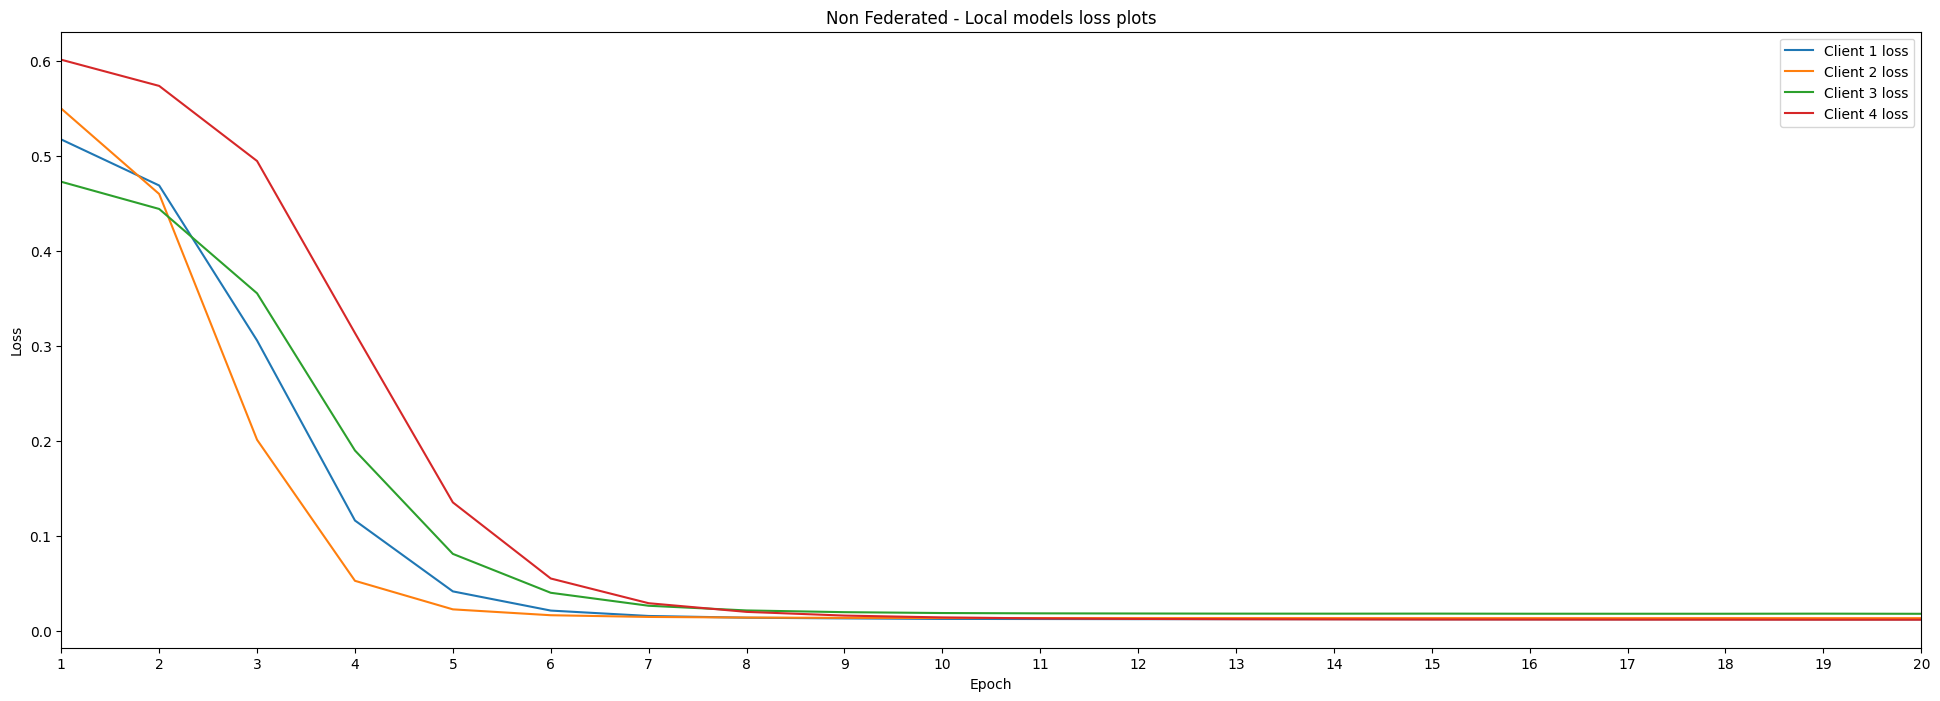

In [130]:
plot_train_loss(client_metrics_noFed, NUM_EPOCHS, title="Non Federated - Local models loss plots")

### 2. Federated local model

In [131]:
# Build the server
server = Server(initial_model)

clients = [
    Client(initial_model, torch.optim.Adam, LEARNING_RATE, nn.MSELoss(), train_client_loaders[i], id=i) for i in range(n_clients)
    ]

In [132]:
# Build the FedAvg aggregation strategy
strategy_fedavg = FedAvg("FedAvg", clients, server, local_avg=False)

In [133]:
m_fedavg = strategy_fedavg.train(nbre_epochs=5, nbre_rounds=4)

//// /////// ////
//// ROUND 0 ////
//// /////// ////


train: 100%|██████████| 25/25 [00:00<00:00, 35.71it/s]


[0] ==> Epoch 0: train_loss: 0.51775026


train: 100%|██████████| 25/25 [00:00<00:00, 36.87it/s]


[0] ==> Epoch 1: train_loss: 0.46882797


train: 100%|██████████| 25/25 [00:00<00:00, 35.33it/s]


[0] ==> Epoch 2: train_loss: 0.30366543


train: 100%|██████████| 25/25 [00:00<00:00, 37.15it/s]


[0] ==> Epoch 3: train_loss: 0.11490998


train: 100%|██████████| 25/25 [00:00<00:00, 37.45it/s]


[0] ==> Epoch 4: train_loss: 0.04123733


train: 100%|██████████| 31/31 [00:00<00:00, 36.13it/s]


[1] ==> Epoch 0: train_loss: 0.55068989


train: 100%|██████████| 31/31 [00:00<00:00, 37.13it/s]


[1] ==> Epoch 1: train_loss: 0.46000157


train: 100%|██████████| 31/31 [00:00<00:00, 37.70it/s]


[1] ==> Epoch 2: train_loss: 0.19603805


train: 100%|██████████| 31/31 [00:00<00:00, 31.39it/s]


[1] ==> Epoch 3: train_loss: 0.0507394


train: 100%|██████████| 31/31 [00:01<00:00, 26.31it/s]


[1] ==> Epoch 4: train_loss: 0.02241412


train: 100%|██████████| 21/21 [00:00<00:00, 23.94it/s]


[2] ==> Epoch 0: train_loss: 0.47283772


train: 100%|██████████| 21/21 [00:00<00:00, 27.29it/s]


[2] ==> Epoch 1: train_loss: 0.44364659


train: 100%|██████████| 21/21 [00:00<00:00, 37.12it/s]


[2] ==> Epoch 2: train_loss: 0.35073734


train: 100%|██████████| 21/21 [00:00<00:00, 37.00it/s]


[2] ==> Epoch 3: train_loss: 0.18621115


train: 100%|██████████| 21/21 [00:00<00:00, 36.15it/s]


[2] ==> Epoch 4: train_loss: 0.08023496


train: 100%|██████████| 19/19 [00:00<00:00, 35.82it/s]


[3] ==> Epoch 0: train_loss: 0.60175707


train: 100%|██████████| 19/19 [00:00<00:00, 33.38it/s]


[3] ==> Epoch 1: train_loss: 0.57335513


train: 100%|██████████| 19/19 [00:00<00:00, 36.15it/s]


[3] ==> Epoch 2: train_loss: 0.49082406


train: 100%|██████████| 19/19 [00:00<00:00, 36.78it/s]


[3] ==> Epoch 3: train_loss: 0.30936034


train: 100%|██████████| 19/19 [00:00<00:00, 37.52it/s]


[3] ==> Epoch 4: train_loss: 0.13469397
Update clients without averaging
//// /////// ////
//// ROUND 1 ////
//// /////// ////


train: 100%|██████████| 25/25 [00:00<00:00, 37.31it/s]


[0] ==> Epoch 0: train_loss: 0.02943265


train: 100%|██████████| 25/25 [00:00<00:00, 37.19it/s]


[0] ==> Epoch 1: train_loss: 0.01708861


train: 100%|██████████| 25/25 [00:00<00:00, 37.03it/s]


[0] ==> Epoch 2: train_loss: 0.01400734


train: 100%|██████████| 25/25 [00:00<00:00, 36.56it/s]


[0] ==> Epoch 3: train_loss: 0.01304558


train: 100%|██████████| 25/25 [00:00<00:00, 36.63it/s]


[0] ==> Epoch 4: train_loss: 0.01261846


train: 100%|██████████| 31/31 [00:00<00:00, 35.99it/s]


[1] ==> Epoch 0: train_loss: 0.02913315


train: 100%|██████████| 31/31 [00:00<00:00, 38.41it/s]


[1] ==> Epoch 1: train_loss: 0.01720423


train: 100%|██████████| 31/31 [00:01<00:00, 26.76it/s]


[1] ==> Epoch 2: train_loss: 0.01476022


train: 100%|██████████| 31/31 [00:01<00:00, 24.81it/s]


[1] ==> Epoch 3: train_loss: 0.01402751


train: 100%|██████████| 31/31 [00:01<00:00, 26.77it/s]


[1] ==> Epoch 4: train_loss: 0.01372474


train: 100%|██████████| 21/21 [00:00<00:00, 35.49it/s]


[2] ==> Epoch 0: train_loss: 0.03412407


train: 100%|██████████| 21/21 [00:00<00:00, 36.40it/s]


[2] ==> Epoch 1: train_loss: 0.02401008


train: 100%|██████████| 21/21 [00:00<00:00, 35.63it/s]


[2] ==> Epoch 2: train_loss: 0.02060665


train: 100%|██████████| 21/21 [00:00<00:00, 38.55it/s]


[2] ==> Epoch 3: train_loss: 0.01930593


train: 100%|██████████| 21/21 [00:00<00:00, 35.15it/s]


[2] ==> Epoch 4: train_loss: 0.01866585


train: 100%|██████████| 19/19 [00:00<00:00, 36.86it/s]


[3] ==> Epoch 0: train_loss: 0.02986043


train: 100%|██████████| 19/19 [00:00<00:00, 34.49it/s]


[3] ==> Epoch 1: train_loss: 0.01878294


train: 100%|██████████| 19/19 [00:00<00:00, 36.98it/s]


[3] ==> Epoch 2: train_loss: 0.01517916


train: 100%|██████████| 19/19 [00:00<00:00, 37.44it/s]


[3] ==> Epoch 3: train_loss: 0.01362643


train: 100%|██████████| 19/19 [00:00<00:00, 36.61it/s]


[3] ==> Epoch 4: train_loss: 0.0128469
Update clients without averaging
//// /////// ////
//// ROUND 2 ////
//// /////// ////


train: 100%|██████████| 25/25 [00:00<00:00, 37.69it/s]


[0] ==> Epoch 0: train_loss: 0.01430413


train: 100%|██████████| 25/25 [00:00<00:00, 36.65it/s]


[0] ==> Epoch 1: train_loss: 0.01256174


train: 100%|██████████| 25/25 [00:00<00:00, 37.59it/s]


[0] ==> Epoch 2: train_loss: 0.01236138


train: 100%|██████████| 25/25 [00:00<00:00, 38.34it/s]


[0] ==> Epoch 3: train_loss: 0.01233444


train: 100%|██████████| 25/25 [00:00<00:00, 37.49it/s]


[0] ==> Epoch 4: train_loss: 0.01238785


train: 100%|██████████| 31/31 [00:00<00:00, 35.49it/s]


[1] ==> Epoch 0: train_loss: 0.0141753


train: 100%|██████████| 31/31 [00:01<00:00, 26.14it/s]


[1] ==> Epoch 1: train_loss: 0.01368278


train: 100%|██████████| 31/31 [00:01<00:00, 23.44it/s]


[1] ==> Epoch 2: train_loss: 0.01356378


train: 100%|██████████| 31/31 [00:01<00:00, 21.16it/s]


[1] ==> Epoch 3: train_loss: 0.01357063


train: 100%|██████████| 31/31 [00:01<00:00, 18.33it/s]


[1] ==> Epoch 4: train_loss: 0.0135281


train: 100%|██████████| 21/21 [00:00<00:00, 36.69it/s]


[2] ==> Epoch 0: train_loss: 0.02083298


train: 100%|██████████| 21/21 [00:00<00:00, 37.16it/s]


[2] ==> Epoch 1: train_loss: 0.01865795


train: 100%|██████████| 21/21 [00:00<00:00, 37.32it/s]


[2] ==> Epoch 2: train_loss: 0.01835854


train: 100%|██████████| 21/21 [00:00<00:00, 35.64it/s]


[2] ==> Epoch 3: train_loss: 0.01828502


train: 100%|██████████| 21/21 [00:00<00:00, 37.27it/s]


[2] ==> Epoch 4: train_loss: 0.01806615


train: 100%|██████████| 19/19 [00:00<00:00, 35.65it/s]


[3] ==> Epoch 0: train_loss: 0.01522318


train: 100%|██████████| 19/19 [00:00<00:00, 32.96it/s]


[3] ==> Epoch 1: train_loss: 0.01262525


train: 100%|██████████| 19/19 [00:00<00:00, 38.08it/s]


[3] ==> Epoch 2: train_loss: 0.01213865


train: 100%|██████████| 19/19 [00:00<00:00, 34.54it/s]


[3] ==> Epoch 3: train_loss: 0.01197193


train: 100%|██████████| 19/19 [00:00<00:00, 37.86it/s]


[3] ==> Epoch 4: train_loss: 0.01191197
Update clients without averaging
//// /////// ////
//// ROUND 3 ////
//// /////// ////


train: 100%|██████████| 25/25 [00:00<00:00, 35.62it/s]


[0] ==> Epoch 0: train_loss: 0.01388592


train: 100%|██████████| 25/25 [00:00<00:00, 36.08it/s]


[0] ==> Epoch 1: train_loss: 0.01239966


train: 100%|██████████| 25/25 [00:00<00:00, 28.42it/s]


[0] ==> Epoch 2: train_loss: 0.01230388


train: 100%|██████████| 25/25 [00:00<00:00, 26.04it/s]


[0] ==> Epoch 3: train_loss: 0.012318


train: 100%|██████████| 25/25 [00:01<00:00, 24.20it/s]


[0] ==> Epoch 4: train_loss: 0.0121542


train: 100%|██████████| 31/31 [00:00<00:00, 31.13it/s]


[1] ==> Epoch 0: train_loss: 0.01386941


train: 100%|██████████| 31/31 [00:00<00:00, 36.06it/s]


[1] ==> Epoch 1: train_loss: 0.01353853


train: 100%|██████████| 31/31 [00:00<00:00, 36.59it/s]


[1] ==> Epoch 2: train_loss: 0.01349848


train: 100%|██████████| 31/31 [00:00<00:00, 36.90it/s]


[1] ==> Epoch 3: train_loss: 0.01348555


train: 100%|██████████| 31/31 [00:00<00:00, 35.82it/s]


[1] ==> Epoch 4: train_loss: 0.0134698


train: 100%|██████████| 21/21 [00:00<00:00, 36.94it/s]


[2] ==> Epoch 0: train_loss: 0.02020962


train: 100%|██████████| 21/21 [00:00<00:00, 38.68it/s]


[2] ==> Epoch 1: train_loss: 0.01849699


train: 100%|██████████| 21/21 [00:00<00:00, 37.38it/s]


[2] ==> Epoch 2: train_loss: 0.01819219


train: 100%|██████████| 21/21 [00:00<00:00, 37.02it/s]


[2] ==> Epoch 3: train_loss: 0.01818786


train: 100%|██████████| 21/21 [00:00<00:00, 35.67it/s]


[2] ==> Epoch 4: train_loss: 0.01817114


train: 100%|██████████| 19/19 [00:00<00:00, 37.32it/s]


[3] ==> Epoch 0: train_loss: 0.01489415


train: 100%|██████████| 19/19 [00:00<00:00, 34.96it/s]


[3] ==> Epoch 1: train_loss: 0.01236965


train: 100%|██████████| 19/19 [00:00<00:00, 37.02it/s]


[3] ==> Epoch 2: train_loss: 0.01198054


train: 100%|██████████| 19/19 [00:00<00:00, 34.70it/s]


[3] ==> Epoch 3: train_loss: 0.01186344


train: 100%|██████████| 19/19 [00:00<00:00, 34.60it/s]


[3] ==> Epoch 4: train_loss: 0.0118345


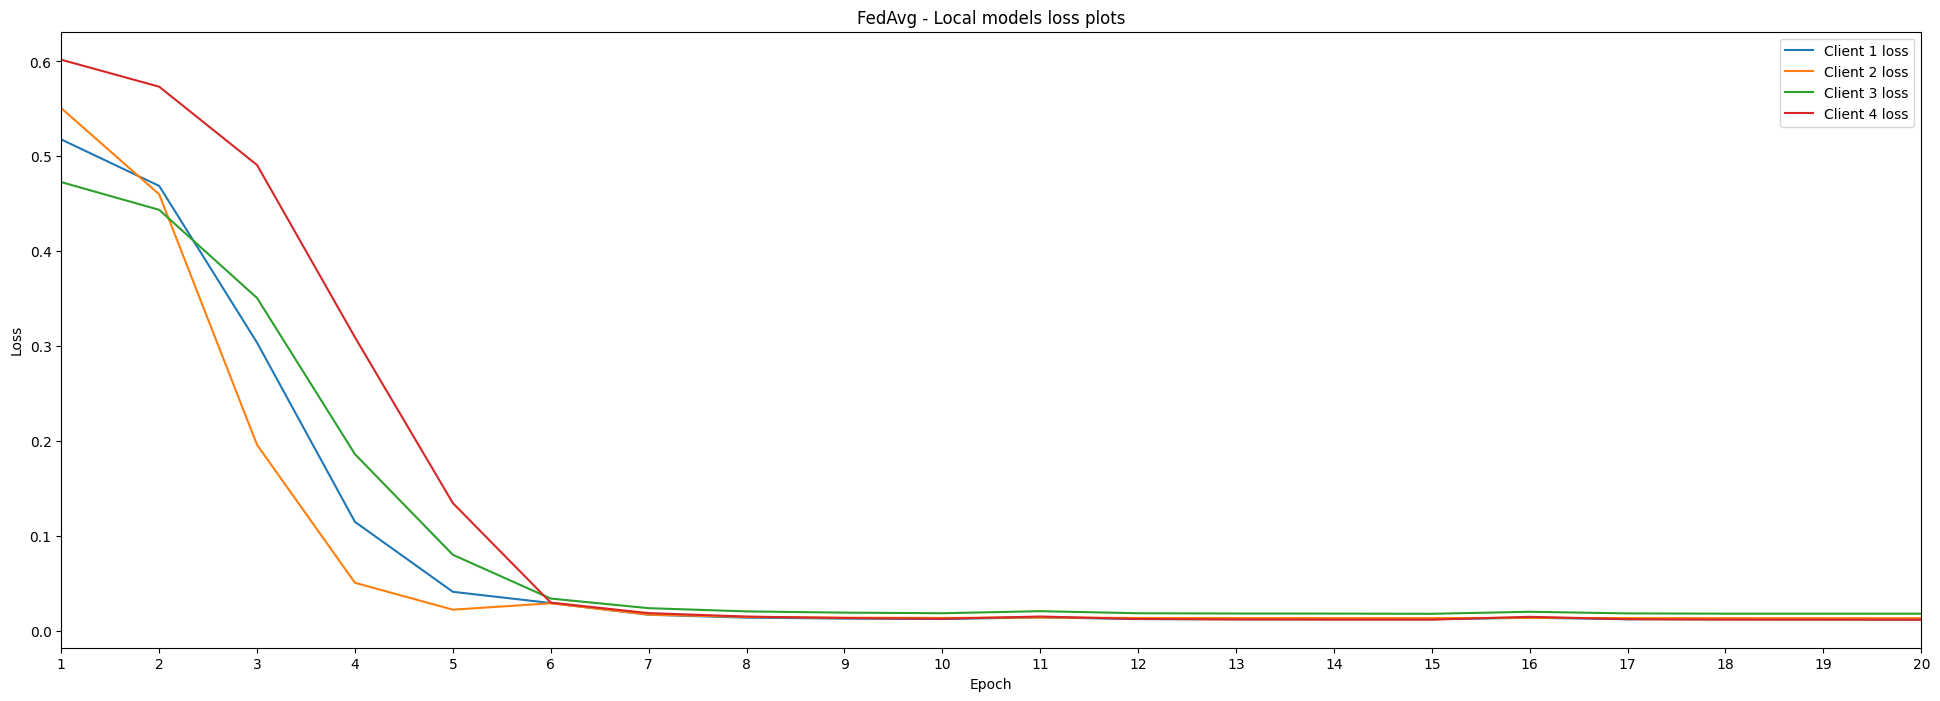

In [134]:
NUM_EPOCHS = 5
NUM_ROUNDS = 4

plot_train_loss(m_fedavg, NUM_EPOCHS * NUM_ROUNDS, title="FedAvg - Local models loss plots")

**Question 5**:

Based of the training loss plot, can we stop earlier?

## VI. Evaluate the performance of the auto-encoder

In [135]:
# Validate the model (using one of the client loaders as an example)

def validate_model(model, val_loader):
  """
  This function takes the loader for the test data, infer the predicted labels and then
  calculates the mean absolute error and the mean squared error.

  Parameters:
  - model: The model used for the prediction.
  - val_loader: The testing DataLoader.

  Returns:
  - dict: a dictionnary of the averageed mean absolute error
   and the mean squared error.
  """

  # Set the device
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.eval()

  mae = []
  mse = []

  with torch.no_grad():
    for img in val_loader:

      img = img.view(img.size(0), -1)

      outputs = model(img.to(DEVICE))

      # Append the metric to its appropriate list
      mae.append(mean_absolute_error(img, outputs))
      mse.append(mean_squared_error(img, outputs))


  return {
      'val_mae': np.round(np.mean(mae), 8),
      'val_mse': np.round(np.mean(mse), 8),
      }

In [136]:
mae_metrics = []
mse_metrics = []


# Iterate on the clients
for i, client_noFed, client_fed in zip(range(n_clients), clients_noFed, strategy_fedavg.clients):
  print(f"Client {i+1}")

  # We pass the local test sets
  metric_nofed = validate_model(client_noFed.model, test_client_loaders[i])
  metric_fed = validate_model(client_fed.model, test_client_loaders[i])

  # We pass the global set
  metric_glob_nofed = validate_model(client_noFed.model, global_test_loader)
  metric_glob_fed = validate_model(client_fed.model, global_test_loader)


  mae_metrics.append({
      "client_id": f"Client_{i+1}",
      "mae_noFed": metric_nofed['val_mae'],
      "mae_Fed": metric_fed['val_mae'],
      "mae_global_noFed": metric_glob_nofed['val_mae'],
      "mae_global_Fed": metric_glob_fed['val_mae'],
  })

  mse_metrics.append({
      "client_id": f"Client_{i+1}",
      "mse_noFed": metric_nofed['val_mse'],
      "mse_Fed": metric_fed['val_mse'],
      "mse_global_noFed": metric_glob_nofed['val_mse'],
      "mse_global_Fed": metric_glob_fed['val_mse'],
  })

Client 1
Client 2
Client 3
Client 4


In [137]:
# Let us now calculate the average and add them to their respective metric list

mae_metrics.append({
    "client_id": f"Average",
    "mae_noFed": np.round(np.mean([m['mae_noFed'] for m in mae_metrics]), 8),
    "mae_Fed": np.round(np.mean([m['mae_Fed'] for m in mae_metrics]), 8),
    "mae_global_noFed": np.round(np.mean([m['mae_global_noFed'] for m in mae_metrics]), 8),
    "mae_global_Fed": np.round(np.mean([m['mae_global_Fed'] for m in mae_metrics]), 8),
})

mse_metrics.append({
    "client_id": f"Average",
    "mse_noFed": np.round(np.mean([m['mse_noFed'] for m in mse_metrics]), 8),
    "mse_Fed": np.round(np.mean([m['mse_Fed'] for m in mse_metrics]), 8),
    "mse_global_noFed": np.round(np.mean([m['mse_global_noFed'] for m in mse_metrics]), 8),
    "mse_global_Fed": np.round(np.mean([m['mse_global_Fed'] for m in mse_metrics]), 8),
})


Finally we plot the Bar plots of the metrics where in x-axis we have the client and the legends are the keys to the model used (fed or no fed) and the local or global testing sets (we will only use "global" to define the global sets).

In [138]:
# Set up the styles for each metric
mae_style={
    "mae_noFed": ("#008dda", None),
    "mae_Fed": ("#ace2e1", "///"),
    "mae_global_noFed": ("#ffcf81", None),
    "mae_global_Fed": ("#f7eedd", "///"),
}

mse_style={
    "mse_noFed": ("#008dda", None),
    "mse_Fed": ("#ace2e1", "///"),
    "mse_global_noFed": ("#ffcf81", None),
    "mse_global_Fed": ("#f7eedd", "///"),
}



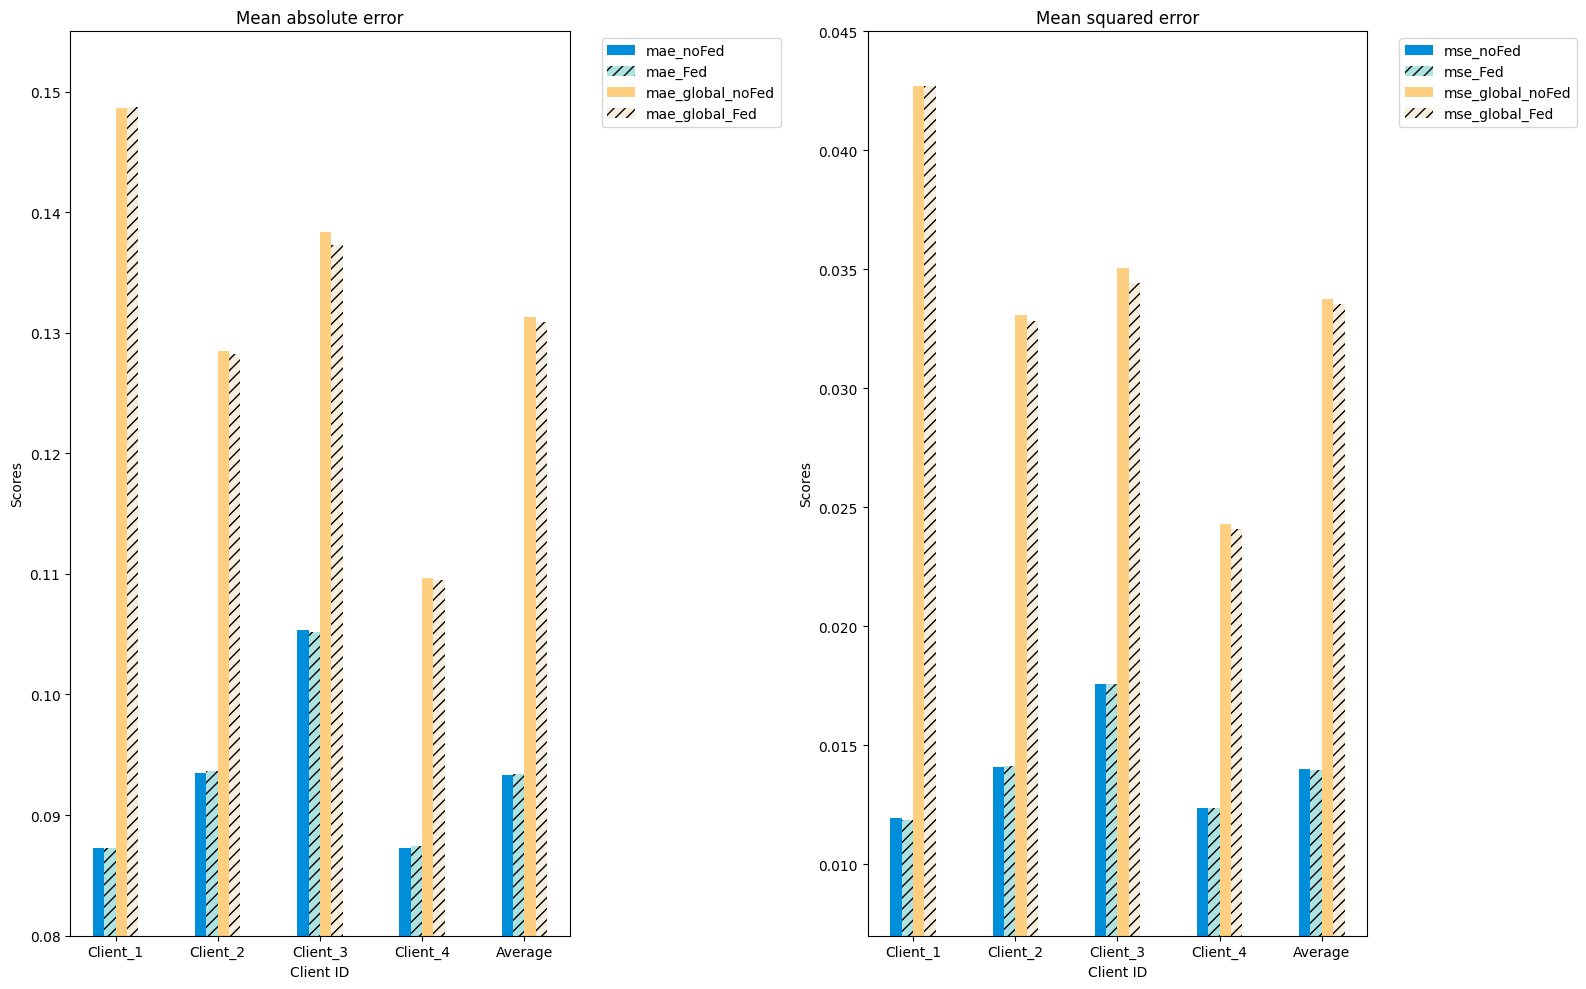

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

# Plot Mean absolute error
plot_acc_sens_spec(mae_metrics, ax[0], title="Mean absolute error", limit=(0.08, 0.155), style=mae_style)

# Plot Mean squared error
plot_acc_sens_spec(mse_metrics, ax[1], title="Mean squared error", limit=(0.007, 0.045), style=mse_style)


fig.tight_layout()
plt.show()

**Question 6**:

What can you spot in these barplots?

# References 📎

[1]   **(MedMNIST)** Yang, J., Shi, R., Wei, D., Liu, Z., Zhao, L., Ke, B., ... & Ni, B. (2023). Medmnist v2-a large-scale lightweight benchmark for 2d and 3d biomedical image classification. Scientific Data, 10(1), 41.

[2]   **(Metrics reloaded)** Reinke, A., Tizabi, M. D., Baumgartner, M., Eisenmann, M., Heckmann-Nötzel, D., Kavur, A. E., ... & Maier-Hein, L. (2024). Understanding metric-related pitfalls in image analysis validation. Nature methods, 21(2), 182-194.

[3]   **(FedAvg)** McMahan, B., Moore, E., Ramage, D., Hampson, S., & y Arcas, B. A. (2017, April). Communication-efficient learning of deep networks from decentralized data. In Artificial intelligence and statistics (pp. 1273-1282). PMLR.

[4]  **(FedProx)** Li, T., Sahu, A. K., Zaheer, M., Sanjabi, M., Talwalkar, A., & Smith, V. (2020). Federated optimization in heterogeneous networks. Proceedings of Machine learning and systems, 2, 429-450.

[5]  **(FedALA)** Zhang, J., Hua, Y., Wang, H., Song, T., Xue, Z., Ma, R., & Guan, H. (2023, June). Fedala: Adaptive local aggregation for personalized federated learning. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 37, No. 9, pp. 11237-11244).


# Extra resources 📎

https://github.com/basiralab/Awesome-Federated-Learning-on-Graph-and-GNN-papers

